# Generic notebook to study calibraded  spectra for HD205905 data 8 jun 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- affiliation : LAL/IN2P3/CNRS FRANCE
- creation date   : 10th October 2017
- update : April 29th 2020 : For Figure of holospec article
- last update June 24th 2020
- Last update July 3st 2020
- Last update October 16th 2020


In [3]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

print(theNotebook)
from IPython.display import Image, display
import sys
sys.path.append("../../common_tools/")
from common_notebook import *

init_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
StudyCalibratedSpectraContaminationSimple
ccdproc version 1.1.0
bottleneck version 1.3.2
/Users/dagoret/MacOSX/GitHub/LSST/CTIOAnaJun2017/CTIOAnaJun2017/ana_08jun17/HD205905


In [5]:
%config InlineBackend.rc = {}
matplotlib.rc_file("../../templates/matplotlibrc")


Bad key "axes.color_cycle" on line 215 in
../../templates/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [6]:
#matplotlib.rcParams.update({'font.size': 10})
#matplotlib.rcParams.update({'font.size': 10})
#matplotlib.rcParams.update({'figure.figsize' : (10, 5)})

In [88]:
matplotlib.rcParams.update({'font.size': 15, 'lines.linewidth': 2, 'lines.markersize': 15})
#matplotlib.rcParams["axes.labelsize"]="large"
matplotlib.rcParams["axes.labelsize"]=20
matplotlib.rcParams["axes.linewidth"]=2.0
matplotlib.rcParams["xtick.major.size"]=10
matplotlib.rcParams["ytick.major.size"]=10
matplotlib.rcParams["ytick.minor.size"]=6
matplotlib.rcParams["xtick.labelsize"]="large"
matplotlib.rcParams["ytick.labelsize"]="large"
matplotlib.rcParams["figure.figsize"]=(8,4)
matplotlib.rcParams['axes.titlesize'] = 15
matplotlib.rcParams['axes.titleweight'] = 'bold'
#matplotlib.rcParams['axes.facecolor'] = 'blue'
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
matplotlib.rcParams['lines.markersize'] = 10  # markersize, in points
matplotlib.rcParams['grid.alpha'] = 1. # transparency, between 0.0 and 1.0
matplotlib.rcParams['grid.linestyle'] = '-' # simple line
matplotlib.rcParams['grid.linewidth'] = 0.6 # in points 
plt.rc('legend',fontsize='medium') # using a named size

In [8]:
from scipy import interpolate

# Configuration 

## Constants for conversions

In [9]:
m_to_mm=1000.
mm_to_m=1e-3
inch_to_mm=25.4
mm_to_inch=1./inch_to_mm
mm_to_micr=1e3
micr_to_m=1e-6
micr_to_mm=1e-3
m_to_micr=1./micr_to_m
m_to_cm=100.
m_to_nm=1e9
nm_to_m=1./m_to_nm
nm_to_micr=0.001

In [10]:
arcdeg_to_arcmin=60.
arcmin_to_arcdeg=1./arcdeg_to_arcmin
arcmin_to_arcsec=60.
arcdeg_to_arcsec=arcdeg_to_arcmin*arcmin_to_arcsec
arcsec_to_arcdeg=1./arcdeg_to_arcsec

In [11]:
deg_to_rad=np.pi/180.

In [12]:
rad_to_deg=1./deg_to_rad
rad_to_arcsec=rad_to_deg*arcdeg_to_arcsec
rad_to_arcmin=rad_to_deg*arcdeg_to_arcmin
arcmin_to_rad=1./rad_to_arcmin

## Constants for telescope

### Telescope

In [13]:
Tel_Focal_Length=12.6 # m : Focal length of the telescope
Tel_Diameter=0.9 # m : Diameter of the telescope    
Tel_Fnum=Tel_Focal_Length/Tel_Diameter
plt_scale=206265/(Tel_Focal_Length*m_to_mm)  # arcsec per mm

### Filter

In [14]:
Filt_D=0.05769 # m distance of the filter position wrt CCD plane
Filt_size=3*inch_to_mm

#### CCD detector

In [15]:
Det_xpic=24.0 # microns per pixel
#Det_NbPix=2048 # number of pixels per CCD side
Det_NbPix=2512 # number of pixels per CCD side For 400 only
Det_size=Det_xpic*Det_NbPix*micr_to_mm # CCD size in mm, 5 cm or 2 inch

## Dispersion functions

### Utility

In [16]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

### Dispersion

In [17]:
def Dispersion(wl,a,D):
    """ 
    Dispersion(wl,a,D) : number of dx per wavelength
    input arguments:
    - wl : wavelength
    - a  : line pitch
    - D  : Distance CCD-Hologram
    
    recommended : all input arguments should be expressed in microns.
    
    - output : dx, x in microns and lambdas in microns
    """
    X=D/a*wl/np.sqrt(1-(wl/a)**2)
    return X

In [18]:
def Dispersion_Rate(wl,a,D):
    """
    Dispersion_Rate(wl) for order 1 : number of dx per wavelength
    input arguments:
    - wl : wavelength
    - a  : line pitch
    - D  : Distance CCD-Hologram
    
    recommended : all input arguments should be expressed in microns.
    
    - output : dx/dlambda, x in microns and lambdas in microns
    
    """
    dxdlambda=D/a*(np.sqrt(1-(wl/a)**2)+ (wl/a)**2)/(1-(wl/a)**2)
    return dxdlambda 

In [19]:
def Dispersion_Rate2(wl,a,D,p=1):
    """
    Dispersion_Rate(wl) for order 2: number of dx per wavelength
    input arguments:
    - wl : wavelength
    - a  : line pitch
    - D  : Distance CCD-Hologram
    - p : order
    
    recommended : all input arguments should be expressed in microns.
    
    - output : dx/dlambda, x in microns and lambdas in microns
    
    """
    dxdlambda=D*p/a/(np.sqrt(1-(p*wl/a)**2))**3
    return dxdlambda 

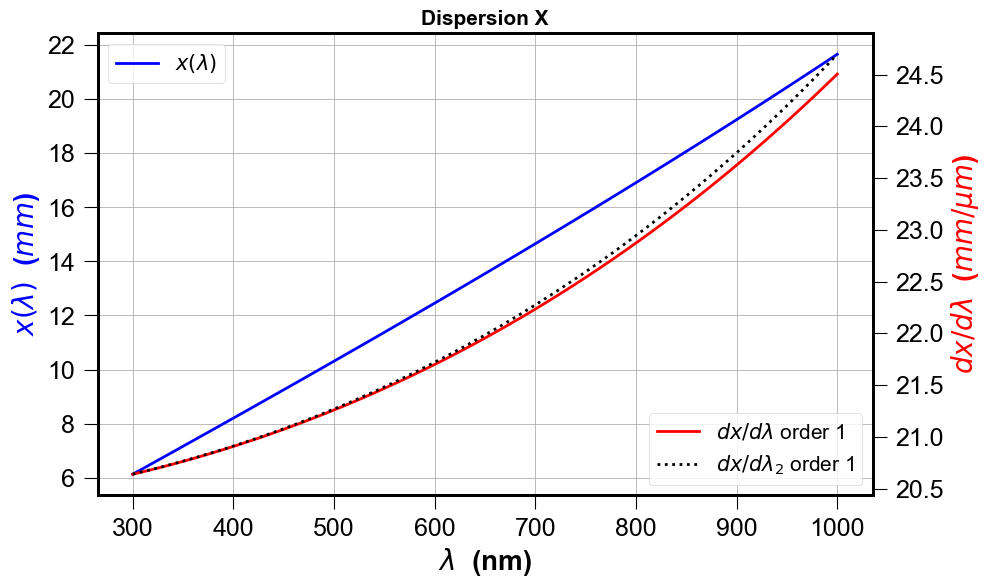

In [20]:
fig, ax1 = plt.subplots(figsize=(10,6))
WL=np.linspace(300.,1000.,100)
a=1/350.*mm_to_micr
D=58*mm_to_micr

Y1=Dispersion(WL*nm_to_micr,a,D)*micr_to_mm
ax1.plot(WL,Y1,"b",label="$x(\lambda)$")

ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$x(\lambda)$  ($mm$)",color="blue")
ax1.set_title("Dispersion X")
ax1.legend(loc="upper left")
ax1.grid(True)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

Y2=Dispersion_Rate(WL*nm_to_micr,a,D)*micr_to_mm  ## mm per microns
Y3=Dispersion_Rate2(WL*nm_to_micr,a,D)*micr_to_mm  ## mm per microns
Y4=Dispersion_Rate2(WL*nm_to_micr,a,D,p=2)*micr_to_mm  ## mm per microns
ax2.plot(WL, Y2,"r",label="$dx/d\lambda$ order 1")
ax2.plot(WL, Y3,"k:",label="$dx/d\lambda_2$ order 1")
#ax2.plot(WL, Y4,"g:",label="$dx/d\lambda$ bis order 2")
ax2.set_xlabel("$\lambda$  (nm)")
ax2.set_ylabel("$dx/d\lambda$  ($mm/\mu m$)",color="red")
#ax2.set_title("Dispersion rate")
ax2.legend(loc="lower right")
ax2.grid(False)

Text(0,0.5,'$dx/d\\lambda$ ratio (no unit)')

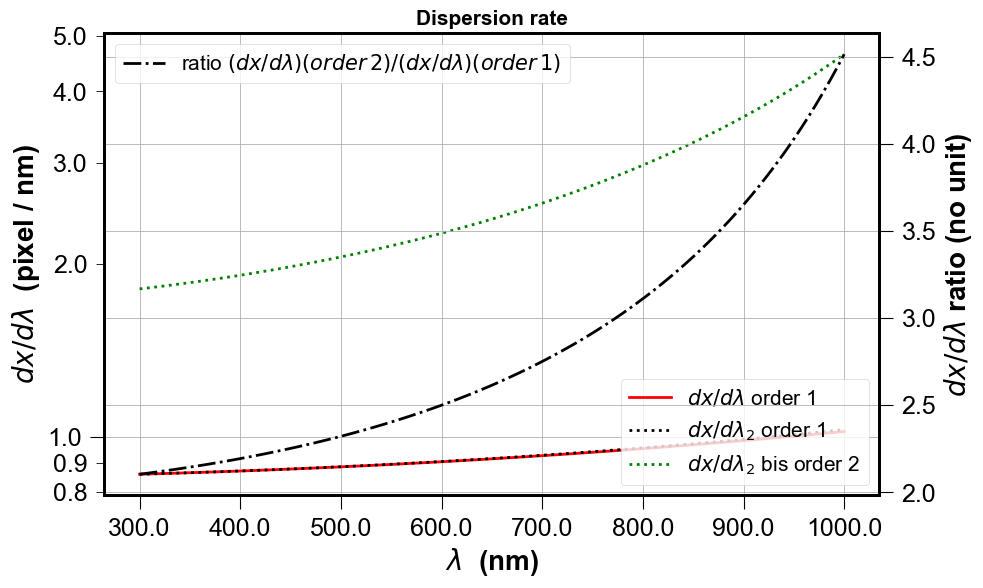

In [21]:
fig, ax1 = plt.subplots(figsize=(10,6))
WL=np.linspace(300.,1000.,100)
a=1/350.*mm_to_micr
D=58*mm_to_micr


Y2=Dispersion_Rate(WL*nm_to_micr,a,D)/Det_xpic*1e-3  ## mm per microns
Y3=Dispersion_Rate2(WL*nm_to_micr,a,D)/Det_xpic*1e-3   ## mm per microns
Y4=Dispersion_Rate2(WL*nm_to_micr,a,D,p=2)/Det_xpic*1e-3   ## mm per microns
ax1.plot(WL, Y2,"r",label="$dx/d\lambda$ order 1")
ax1.plot(WL, Y3,"k:",label="$dx/d\lambda_2$ order 1")
ax1.plot(WL, Y4,"g:",label="$dx/d\lambda_2$ bis order 2")
ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$dx/d\lambda$  (pixel / nm)")
ax1.set_title("Dispersion rate")
ax1.legend(loc="lower right")
ax1.grid(True)
ax1.set_yscale("log")
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
    
formatter = FuncFormatter(lambda y, _: '{:.1f}'.format(y))
    
for axis in [ax1.xaxis,  ax1.yaxis]:
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    axis.set_major_formatter(formatter)
for axis in [ax1.xaxis,  ax1.yaxis]:
    formatter = FuncFormatter(lambda y, _: '{:.1f}'.format(y))
    axis.set_major_formatter(formatter)
    axis.set_minor_formatter(formatter)

    #axarr[1].xaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    #axarr[1].xaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))
    #axarr[1].xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #axarr[1].xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(WL, Y4/Y3,"k-.",label="ratio $(dx/d\\lambda)(order\,2)/(dx/d\\lambda)(order\,1)$")
ax2.legend()
ax2.set_ylabel("$dx/d\lambda$ ratio (no unit)")

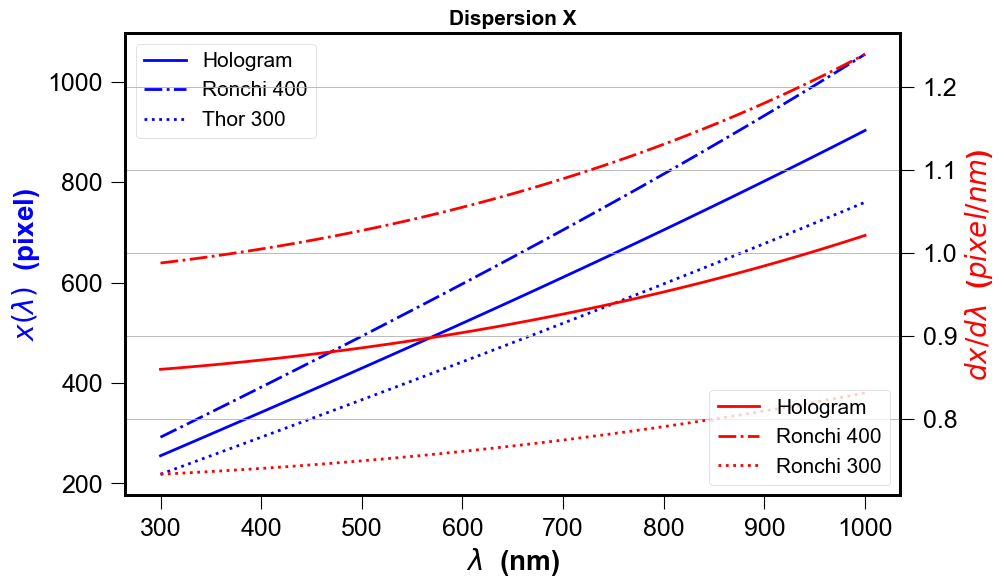

In [22]:
fig, ax1 = plt.subplots(figsize=(10,6))
WL=np.linspace(300.,1000.,100)
a=1/350.*mm_to_micr
D=58*mm_to_micr

Y1=Dispersion(WL*nm_to_micr,a,D)/Det_xpic   # pixel
Y1400=Dispersion(WL*nm_to_micr,1/400.*mm_to_micr,D)/Det_xpic   # pixel
Y1300=Dispersion(WL*nm_to_micr,1/300.*mm_to_micr,D)/Det_xpic   # pixel
ax1.plot(WL,Y1,"b",label="Hologram")
ax1.plot(WL,Y1400,"b-.",label="Ronchi 400")
ax1.plot(WL,Y1300,"b:",label="Thor 300")

ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$x(\lambda)$  (pixel)",color="blue")
ax1.set_title("Dispersion X")
ax1.legend(loc="upper left")
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

Y2=Dispersion_Rate(WL*nm_to_micr,a,D)/Det_xpic*1e-3   # pixel per nm
ax2.plot(WL, Y2,"r",label="Hologram")
Y2400=Dispersion_Rate(WL*nm_to_micr,1/400.*mm_to_micr,D)/Det_xpic*1e-3   # pixel per nm
Y2300=Dispersion_Rate(WL*nm_to_micr,1/300.*mm_to_micr,D)/Det_xpic*1e-3   # pixel per nm
ax2.plot(WL, Y2400,"r-.",label="Ronchi 400")
ax2.plot(WL, Y2300,"r:",label="Ronchi 300")

ax2.set_xlabel("$\lambda$  (nm)")
ax2.set_ylabel("$dx/d\lambda$  ($pixel/nm$)",color="red")
#ax2.set_title("Dispersion rate")
ax2.legend(loc="lower right")
#ax2.grid()

# Initialisation

## Input fits file

- containing the calibrated spectra

In [23]:
inputdir="./spectrum_calibspec"
MIN_IMGNUMBER=144
MAX_IMGNUMBER=357
date="20170608"
object_name='HD205905'
tag = "calibSpectra"
SelectTagRe='^%s_%s_([0-9]+).fits$' % (tag,date) # regular expression to select the file
SearchTagRe='^%s_%s_[0-9]+.fits$' % (tag,date)
NBIMGPERROW=2

## Output directory

In [24]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images
ensure_dir(dir_top_images) # create that directory

outputdir="./study_calibspec"
ensure_dir(outputdir)

# Open input file

In [25]:
sorted_numbers,sorted_files = MakeFileList([inputdir],MIN_IMGNUMBER,MAX_IMGNUMBER,SelectTagRe,SearchTagRe)

In [216]:
sorted_files[:10]

array(['./spectrum_calibspec/calibSpectra_20170608_155.fits',
       './spectrum_calibspec/calibSpectra_20170608_159.fits',
       './spectrum_calibspec/calibSpectra_20170608_160.fits',
       './spectrum_calibspec/calibSpectra_20170608_161.fits',
       './spectrum_calibspec/calibSpectra_20170608_162.fits',
       './spectrum_calibspec/calibSpectra_20170608_165.fits',
       './spectrum_calibspec/calibSpectra_20170608_167.fits',
       './spectrum_calibspec/calibSpectra_20170608_173.fits',
       './spectrum_calibspec/calibSpectra_20170608_176.fits',
       './spectrum_calibspec/calibSpectra_20170608_183.fits'],
      dtype='|S51')

In [215]:
sorted_numbers[:5]

array([155, 159, 160, 161, 162])

In [26]:
all_dates,all_airmass,all_titles,all_header,all_expo, all_leftspectra_data,all_rightspectra_data, all_leftspectra_data_stat_err , all_rightspectra_data_stat_err ,all_leftspectra_wl,all_rightspectra_wl,all_filt,all_filt1,all_filt2=BuildCalibSpec(sorted_files,sorted_numbers,object_name)

# Disperser Sorting

In [27]:
filt0_idx,filt1_idx,filt2_idx,filt3_idx,filt4_idx,filt5_idx,filt6_idx=get_filt_idx(all_filt)

In [28]:
print  Filt_names[0],' \t : filt0_idx :: ',filt0_idx
print  Filt_names[1],' \t : filt1_idx :: ',filt1_idx
print  Filt_names[2],' \t : filt2_idx :: ',filt2_idx
print  Filt_names[3],' \t : filt3_idx :: ',filt3_idx
print  Filt_names[4],' \t : filt4_idx :: ',filt4_idx
print  Filt_names[5],' \t : filt5_idx :: ',filt5_idx
print  Filt_names[6],' \t : filt6_idx :: ',filt6_idx

dia Ron400  	 : filt0_idx ::  []
dia Thor300  	 : filt1_idx ::  [ 6  8 14 15 21 25 26 29 35 37 39 40 48 49 50 52]
dia HoloPhP  	 : filt2_idx ::  [ 1 11 16 17 30 38 41 43 44 51]
dia HoloPhAg  	 : filt3_idx ::  [ 2  3 12 20 22 27 45]
dia HoloAmAg  	 : filt4_idx ::  [ 4  7  9 13 18 23 31 32 36 42 46 47]
dia Ron200  	 : filt5_idx ::  [ 0  5 10 19 24 28 33 34]
Unknown  	 : filt6_idx ::  []


# Show Spectra

/Users/dagoret/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


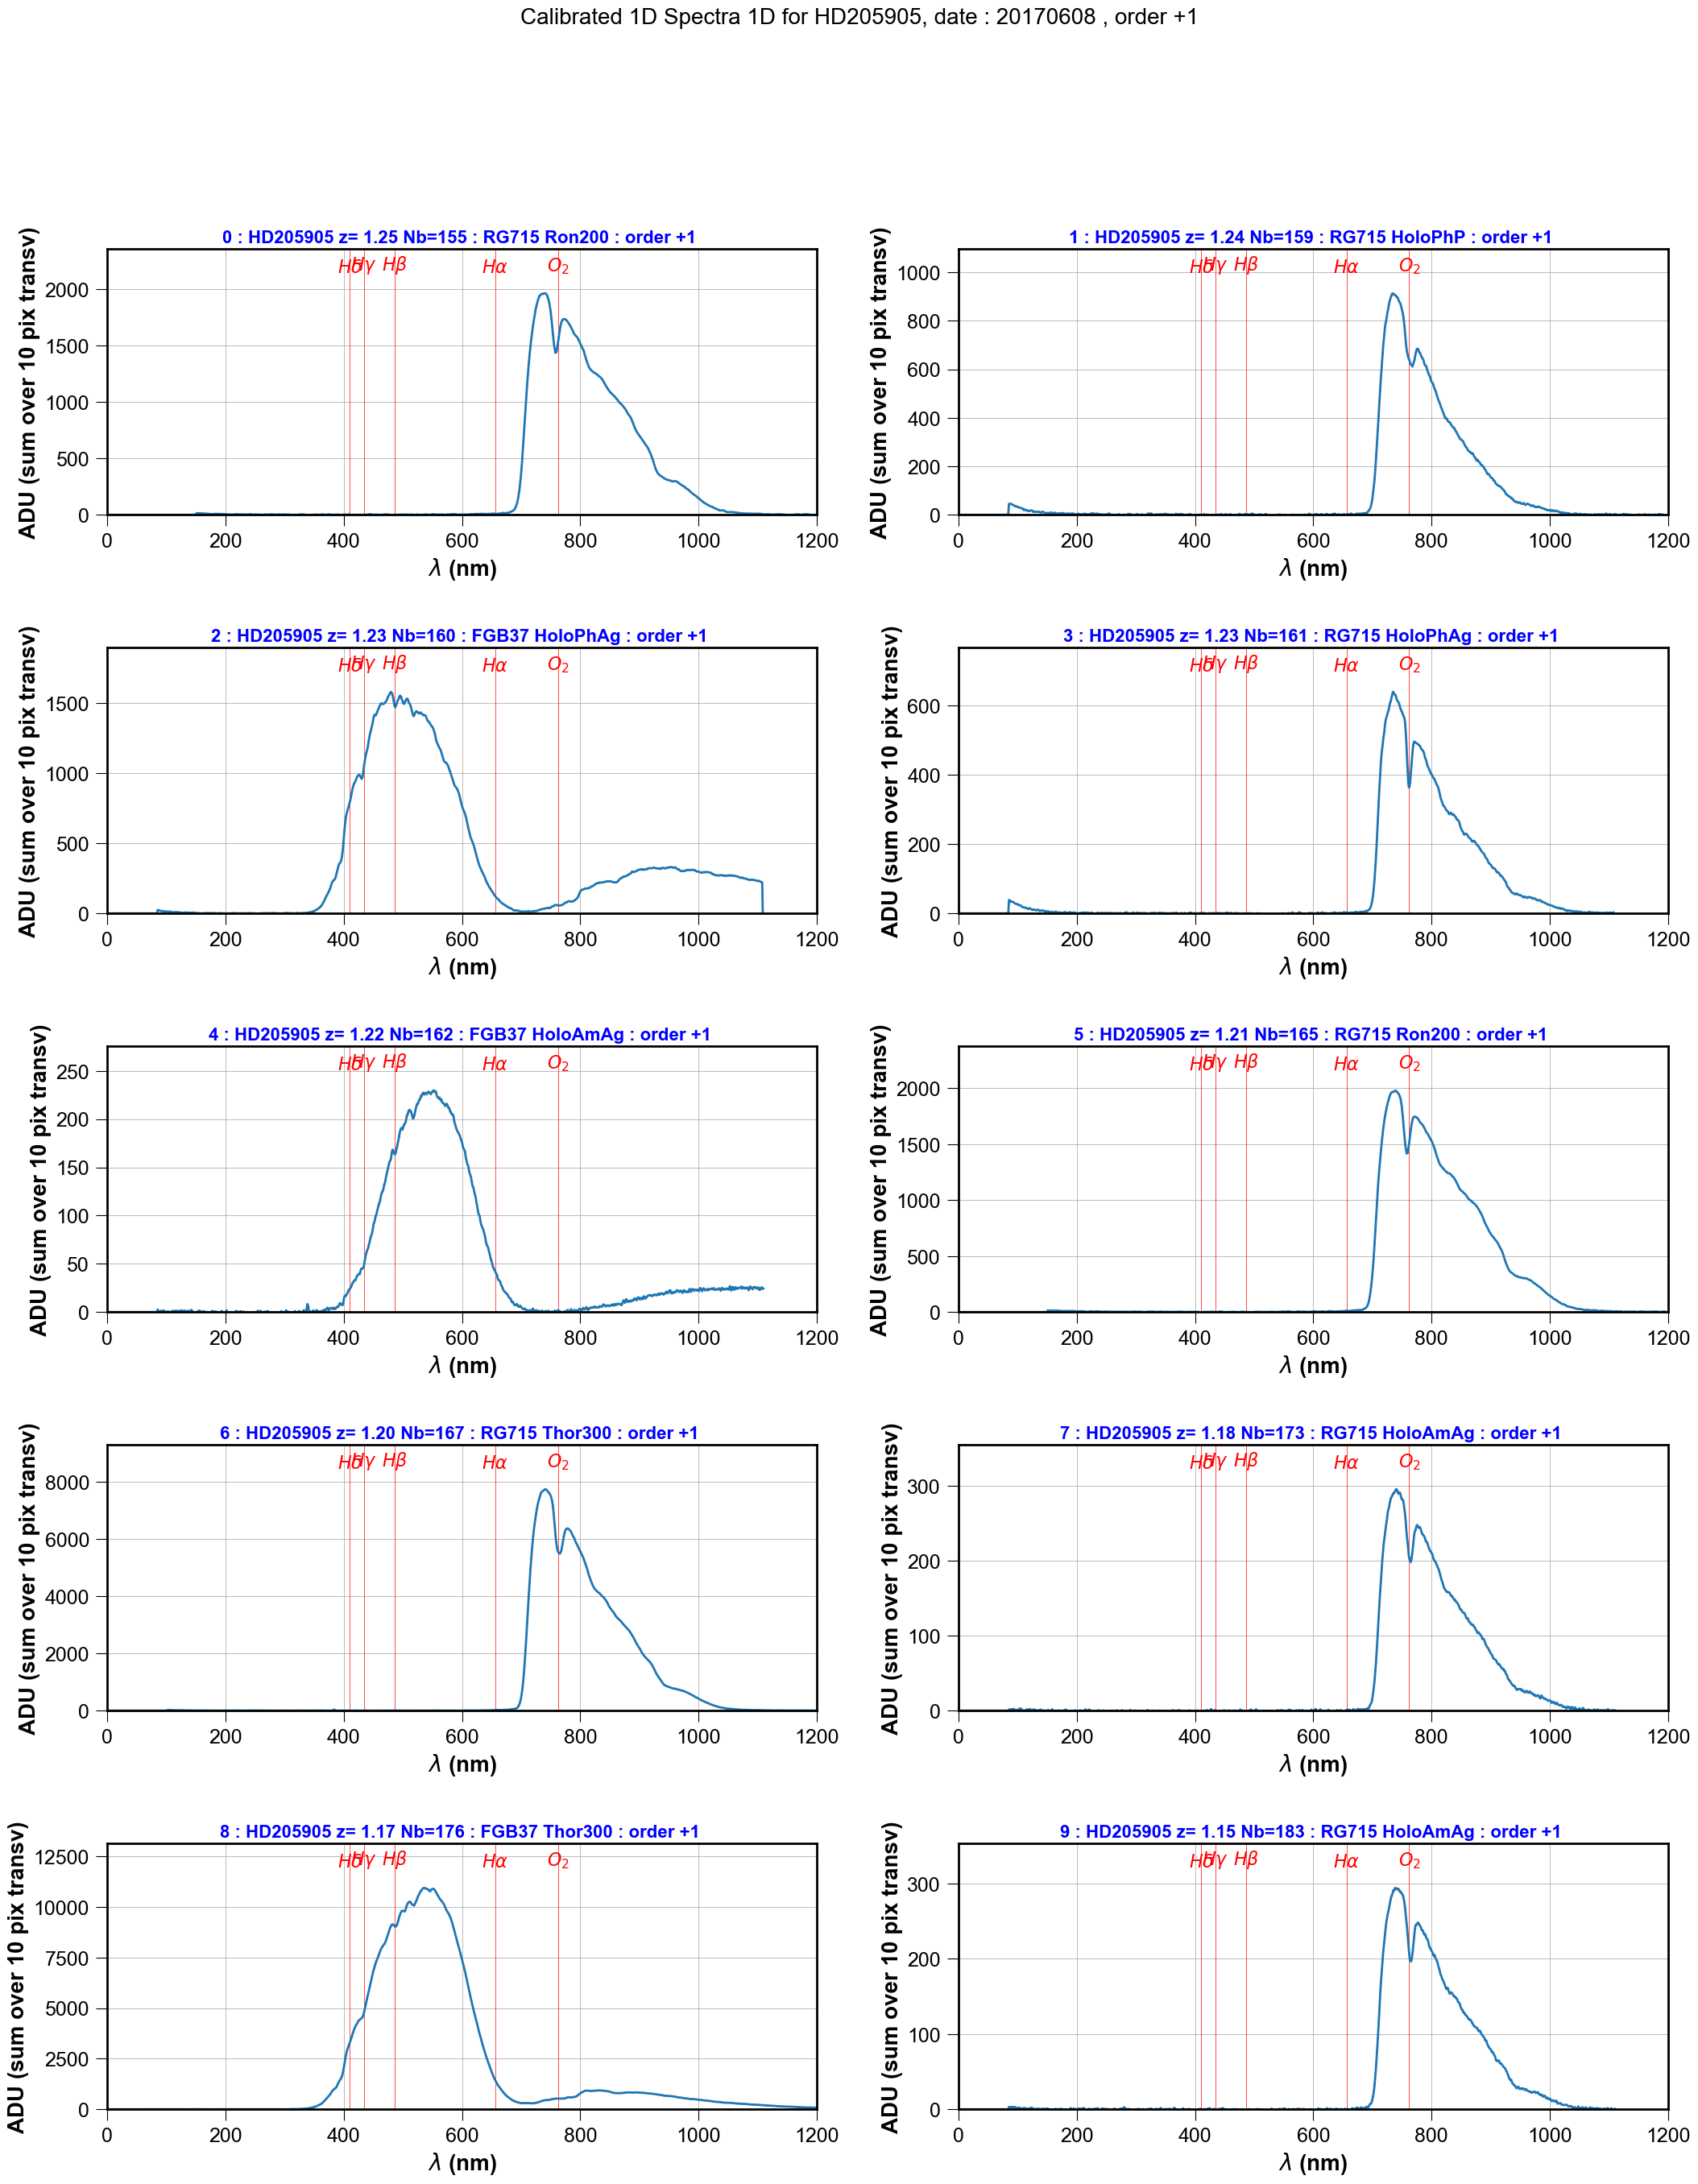

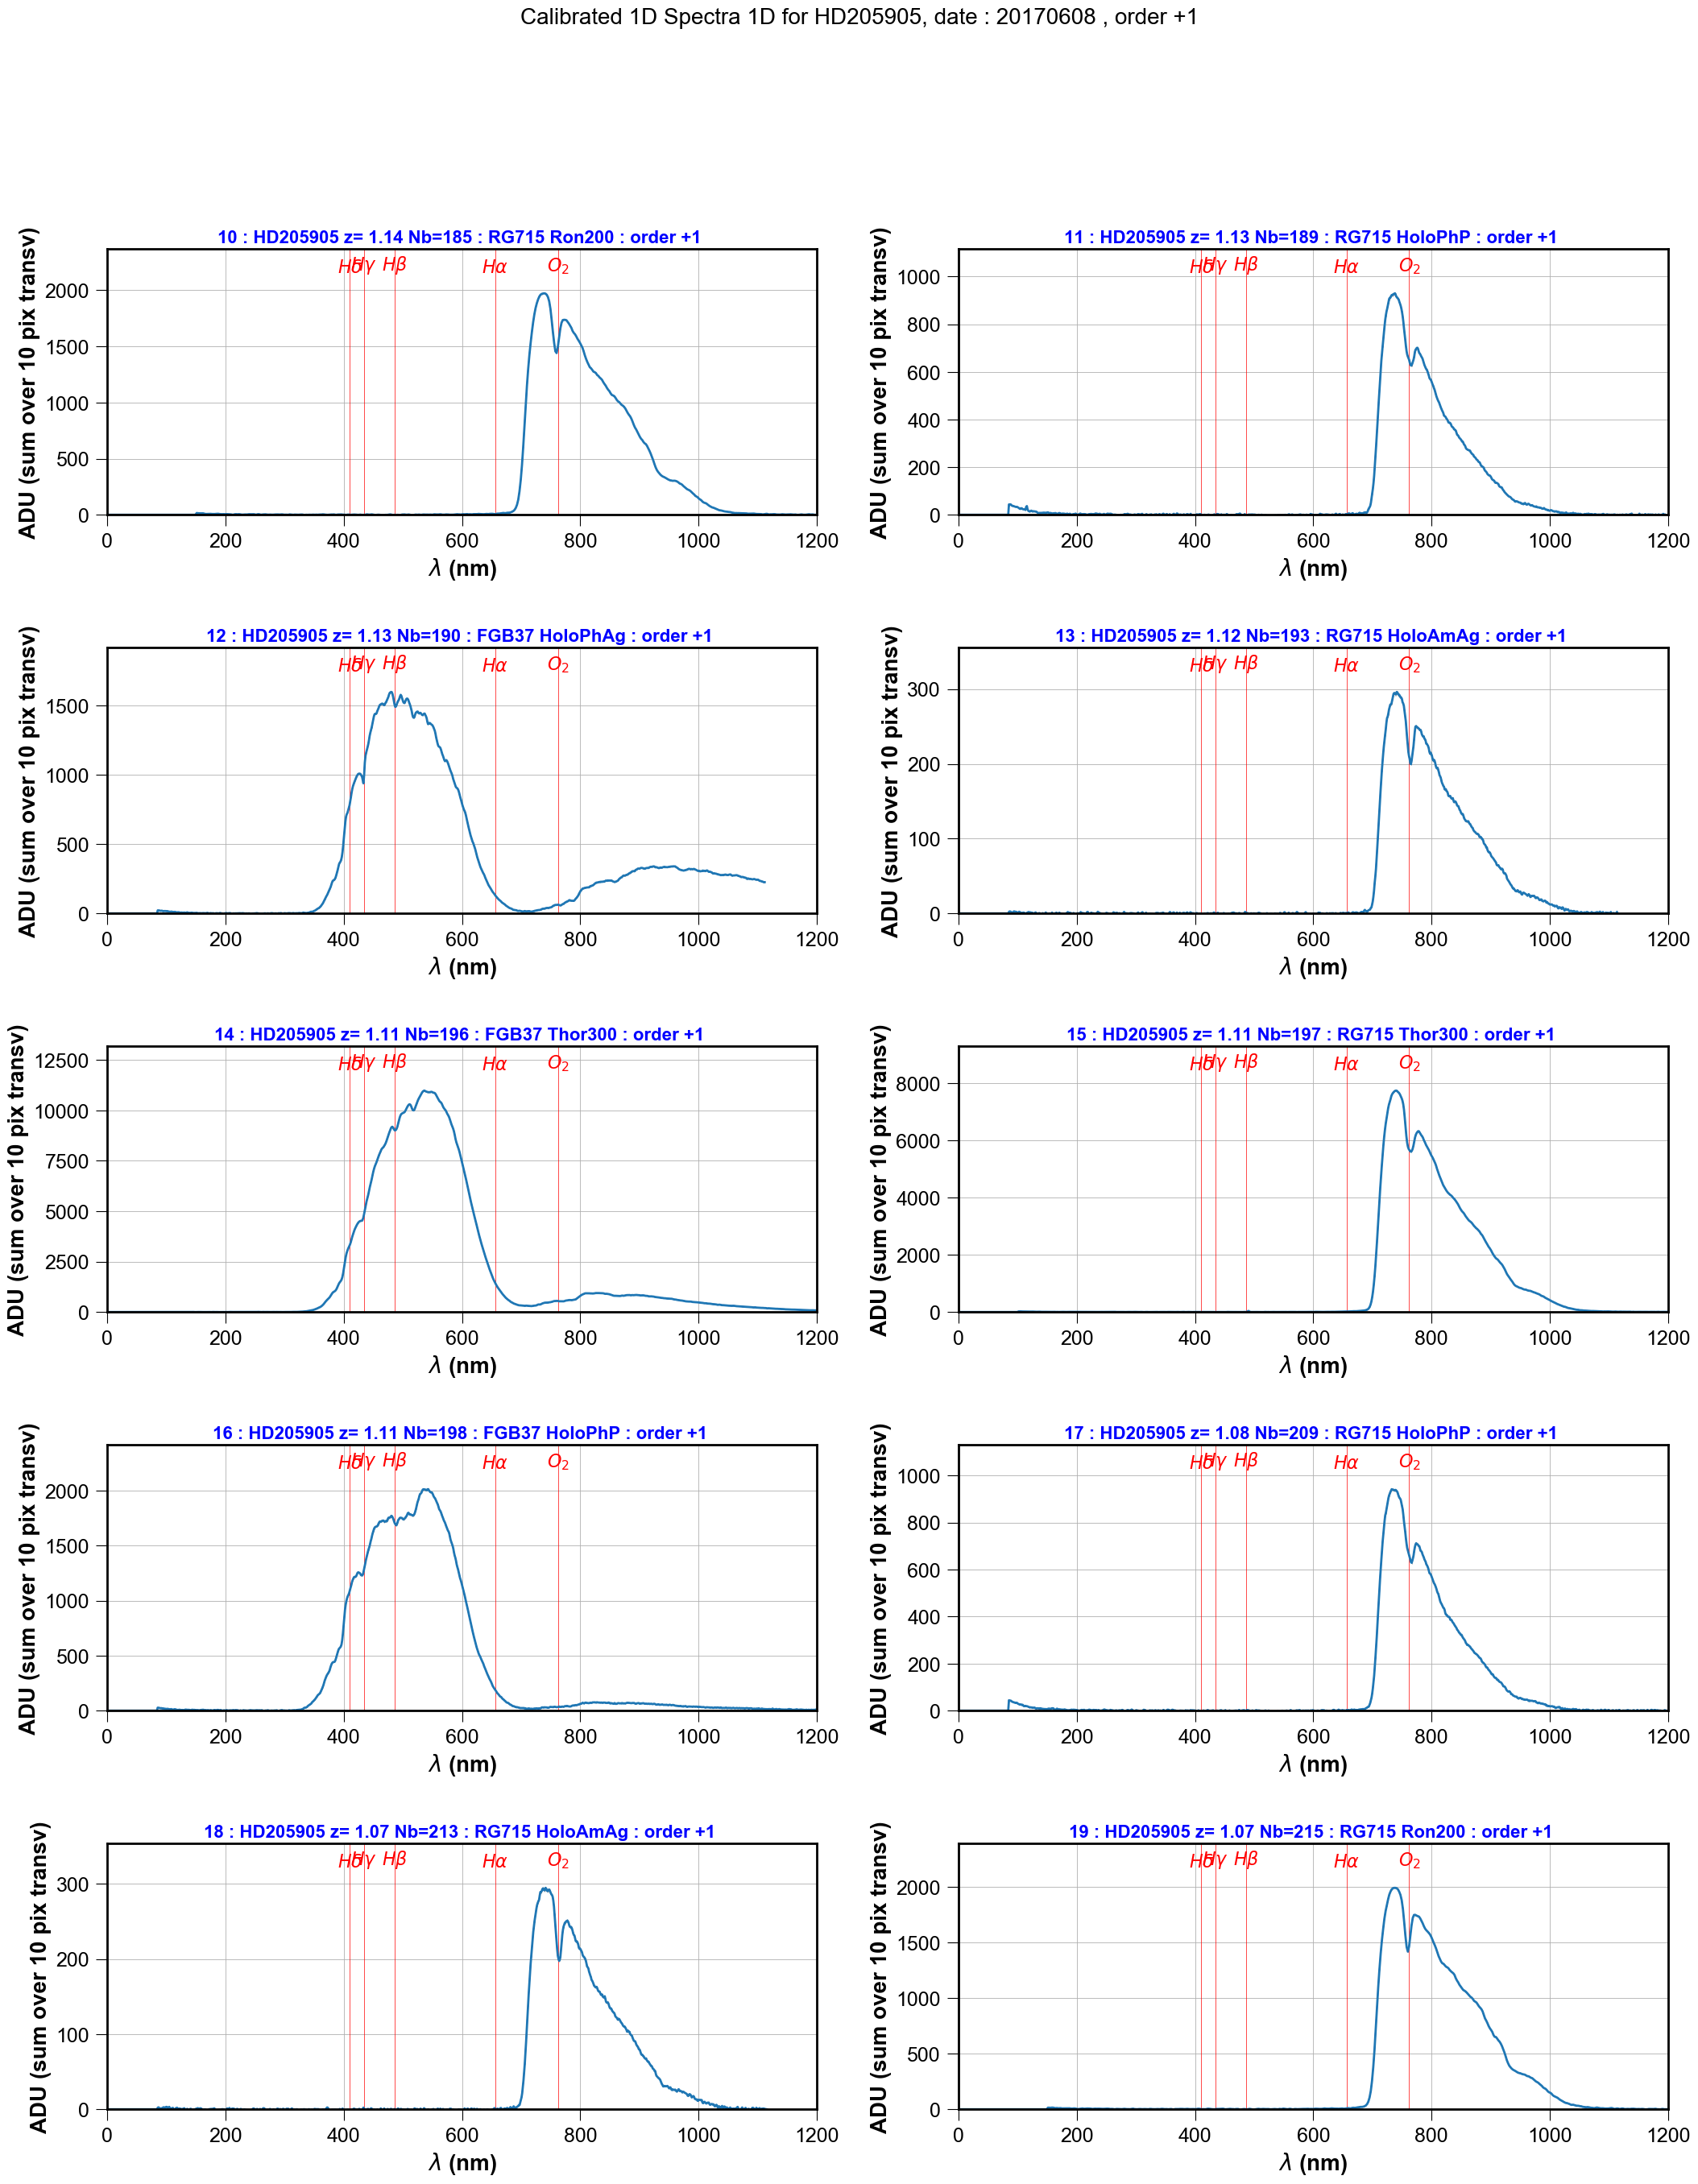

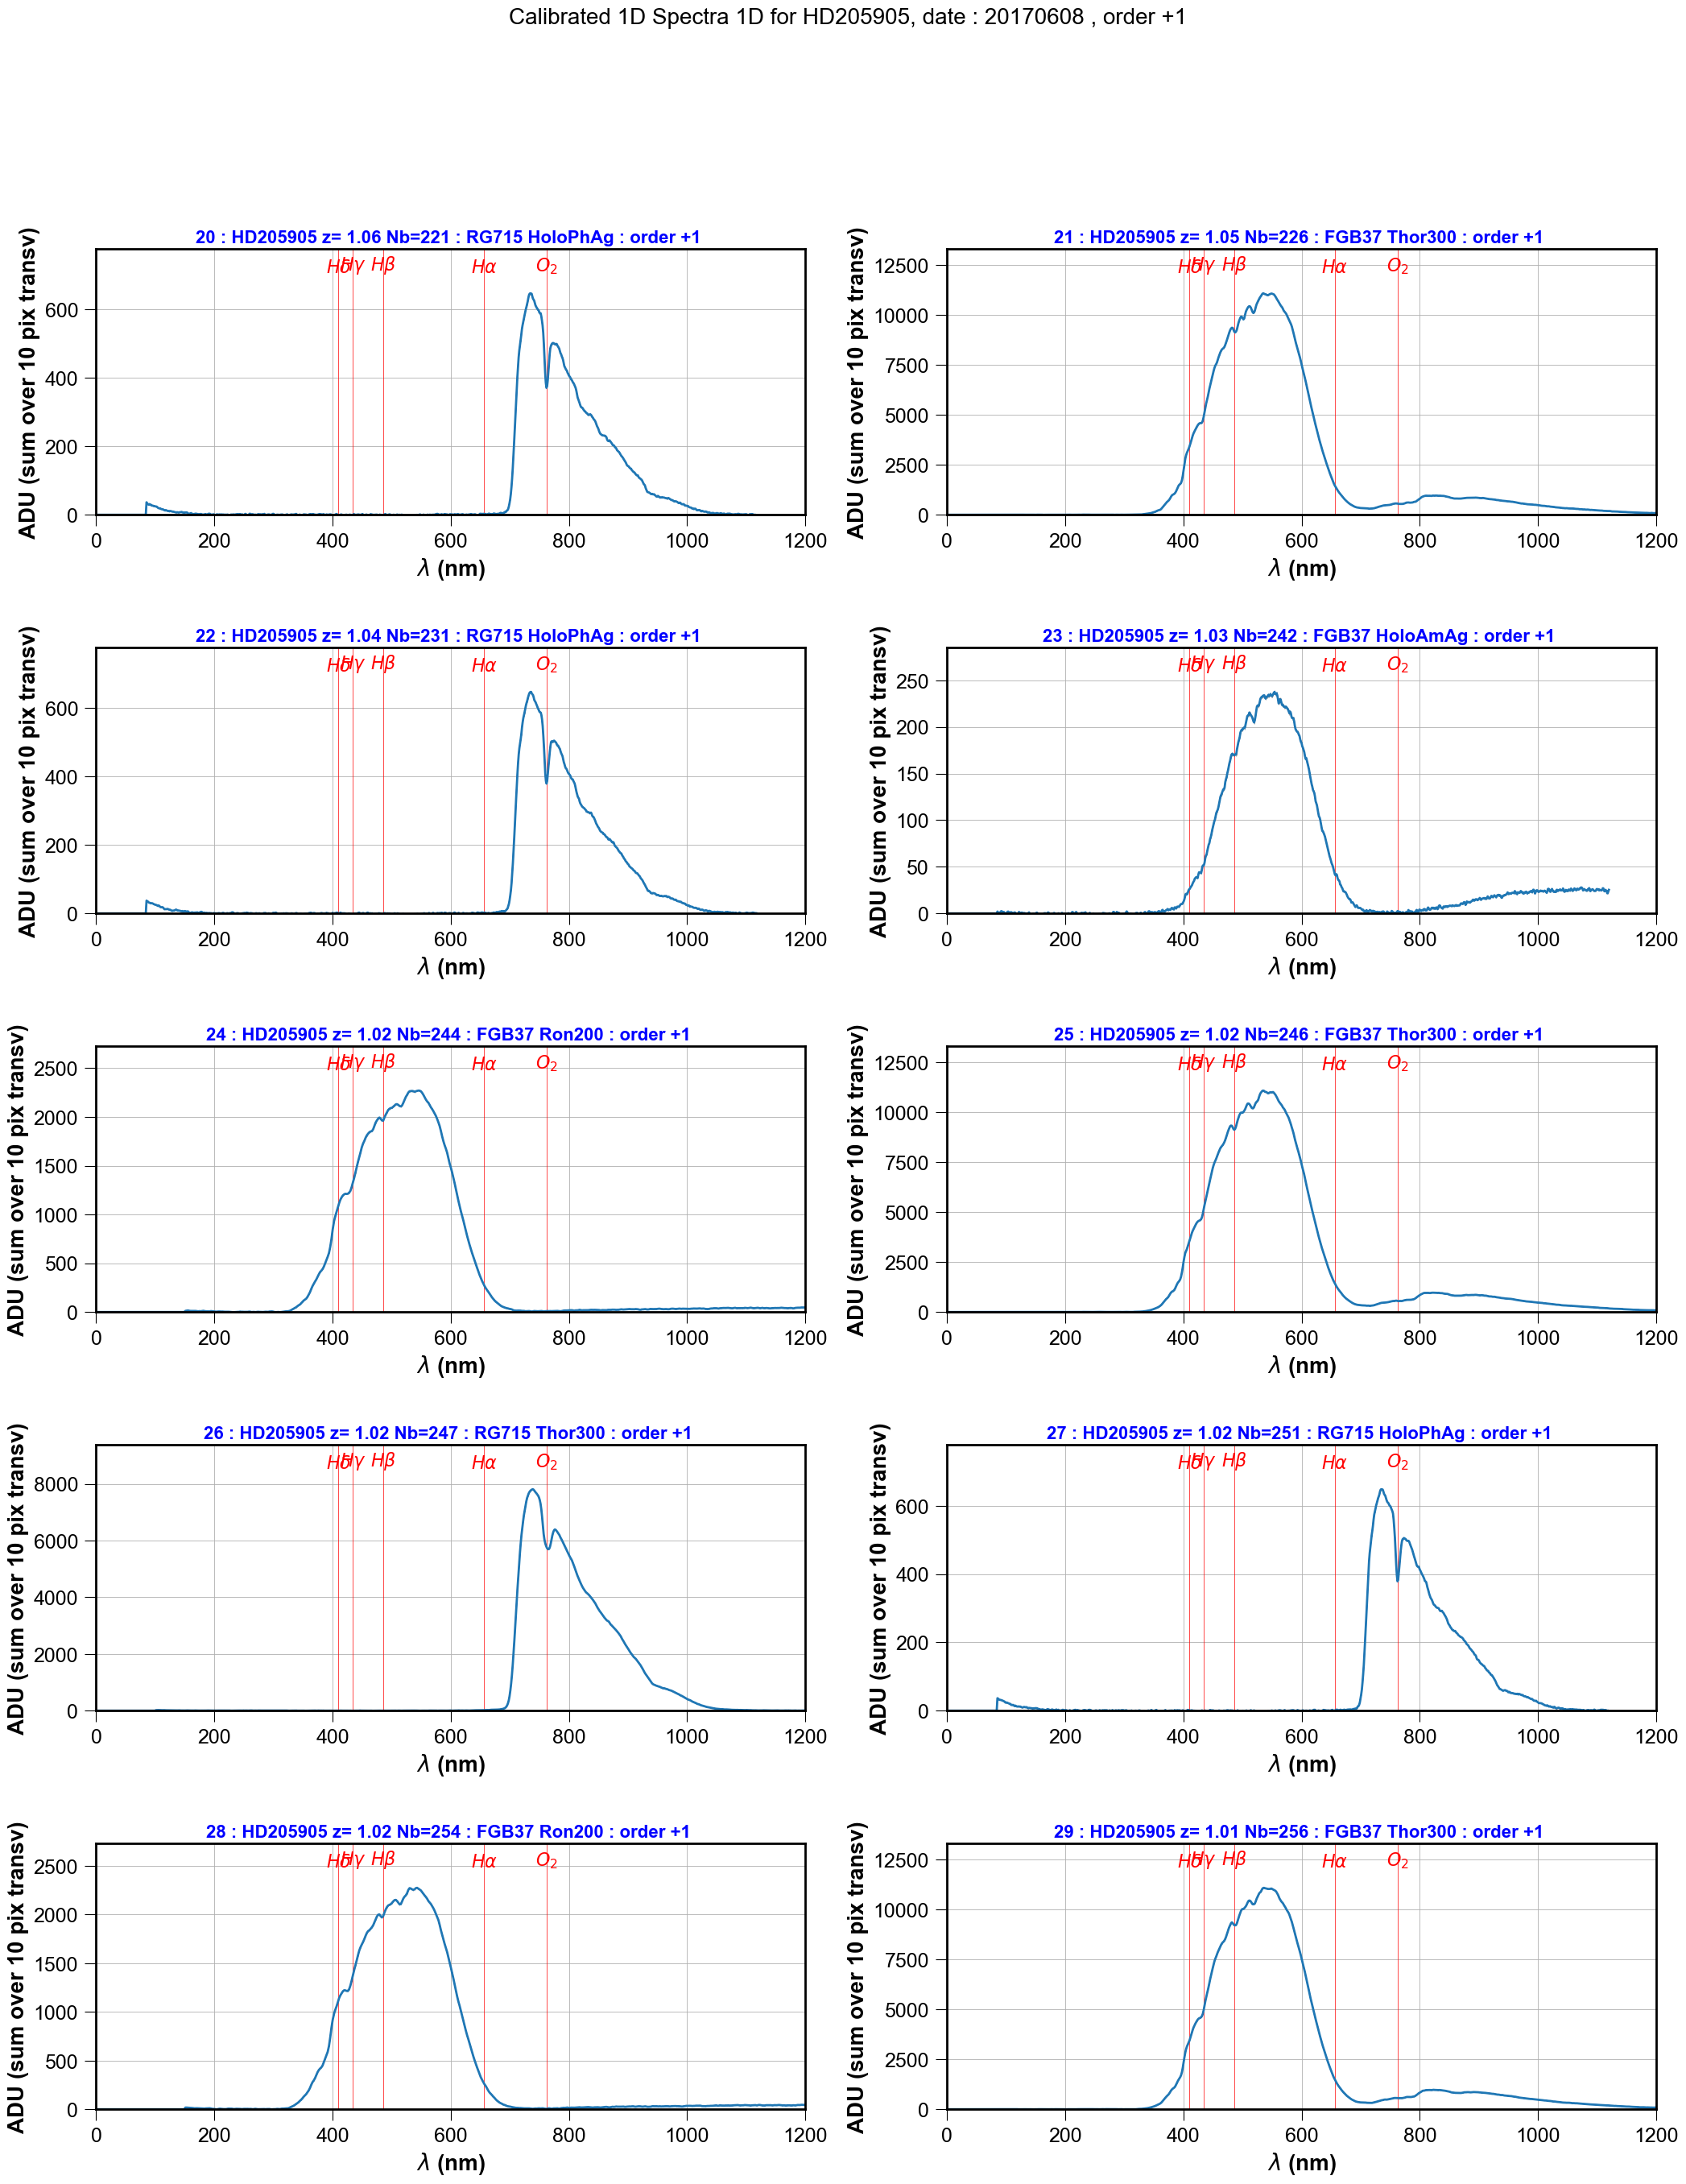

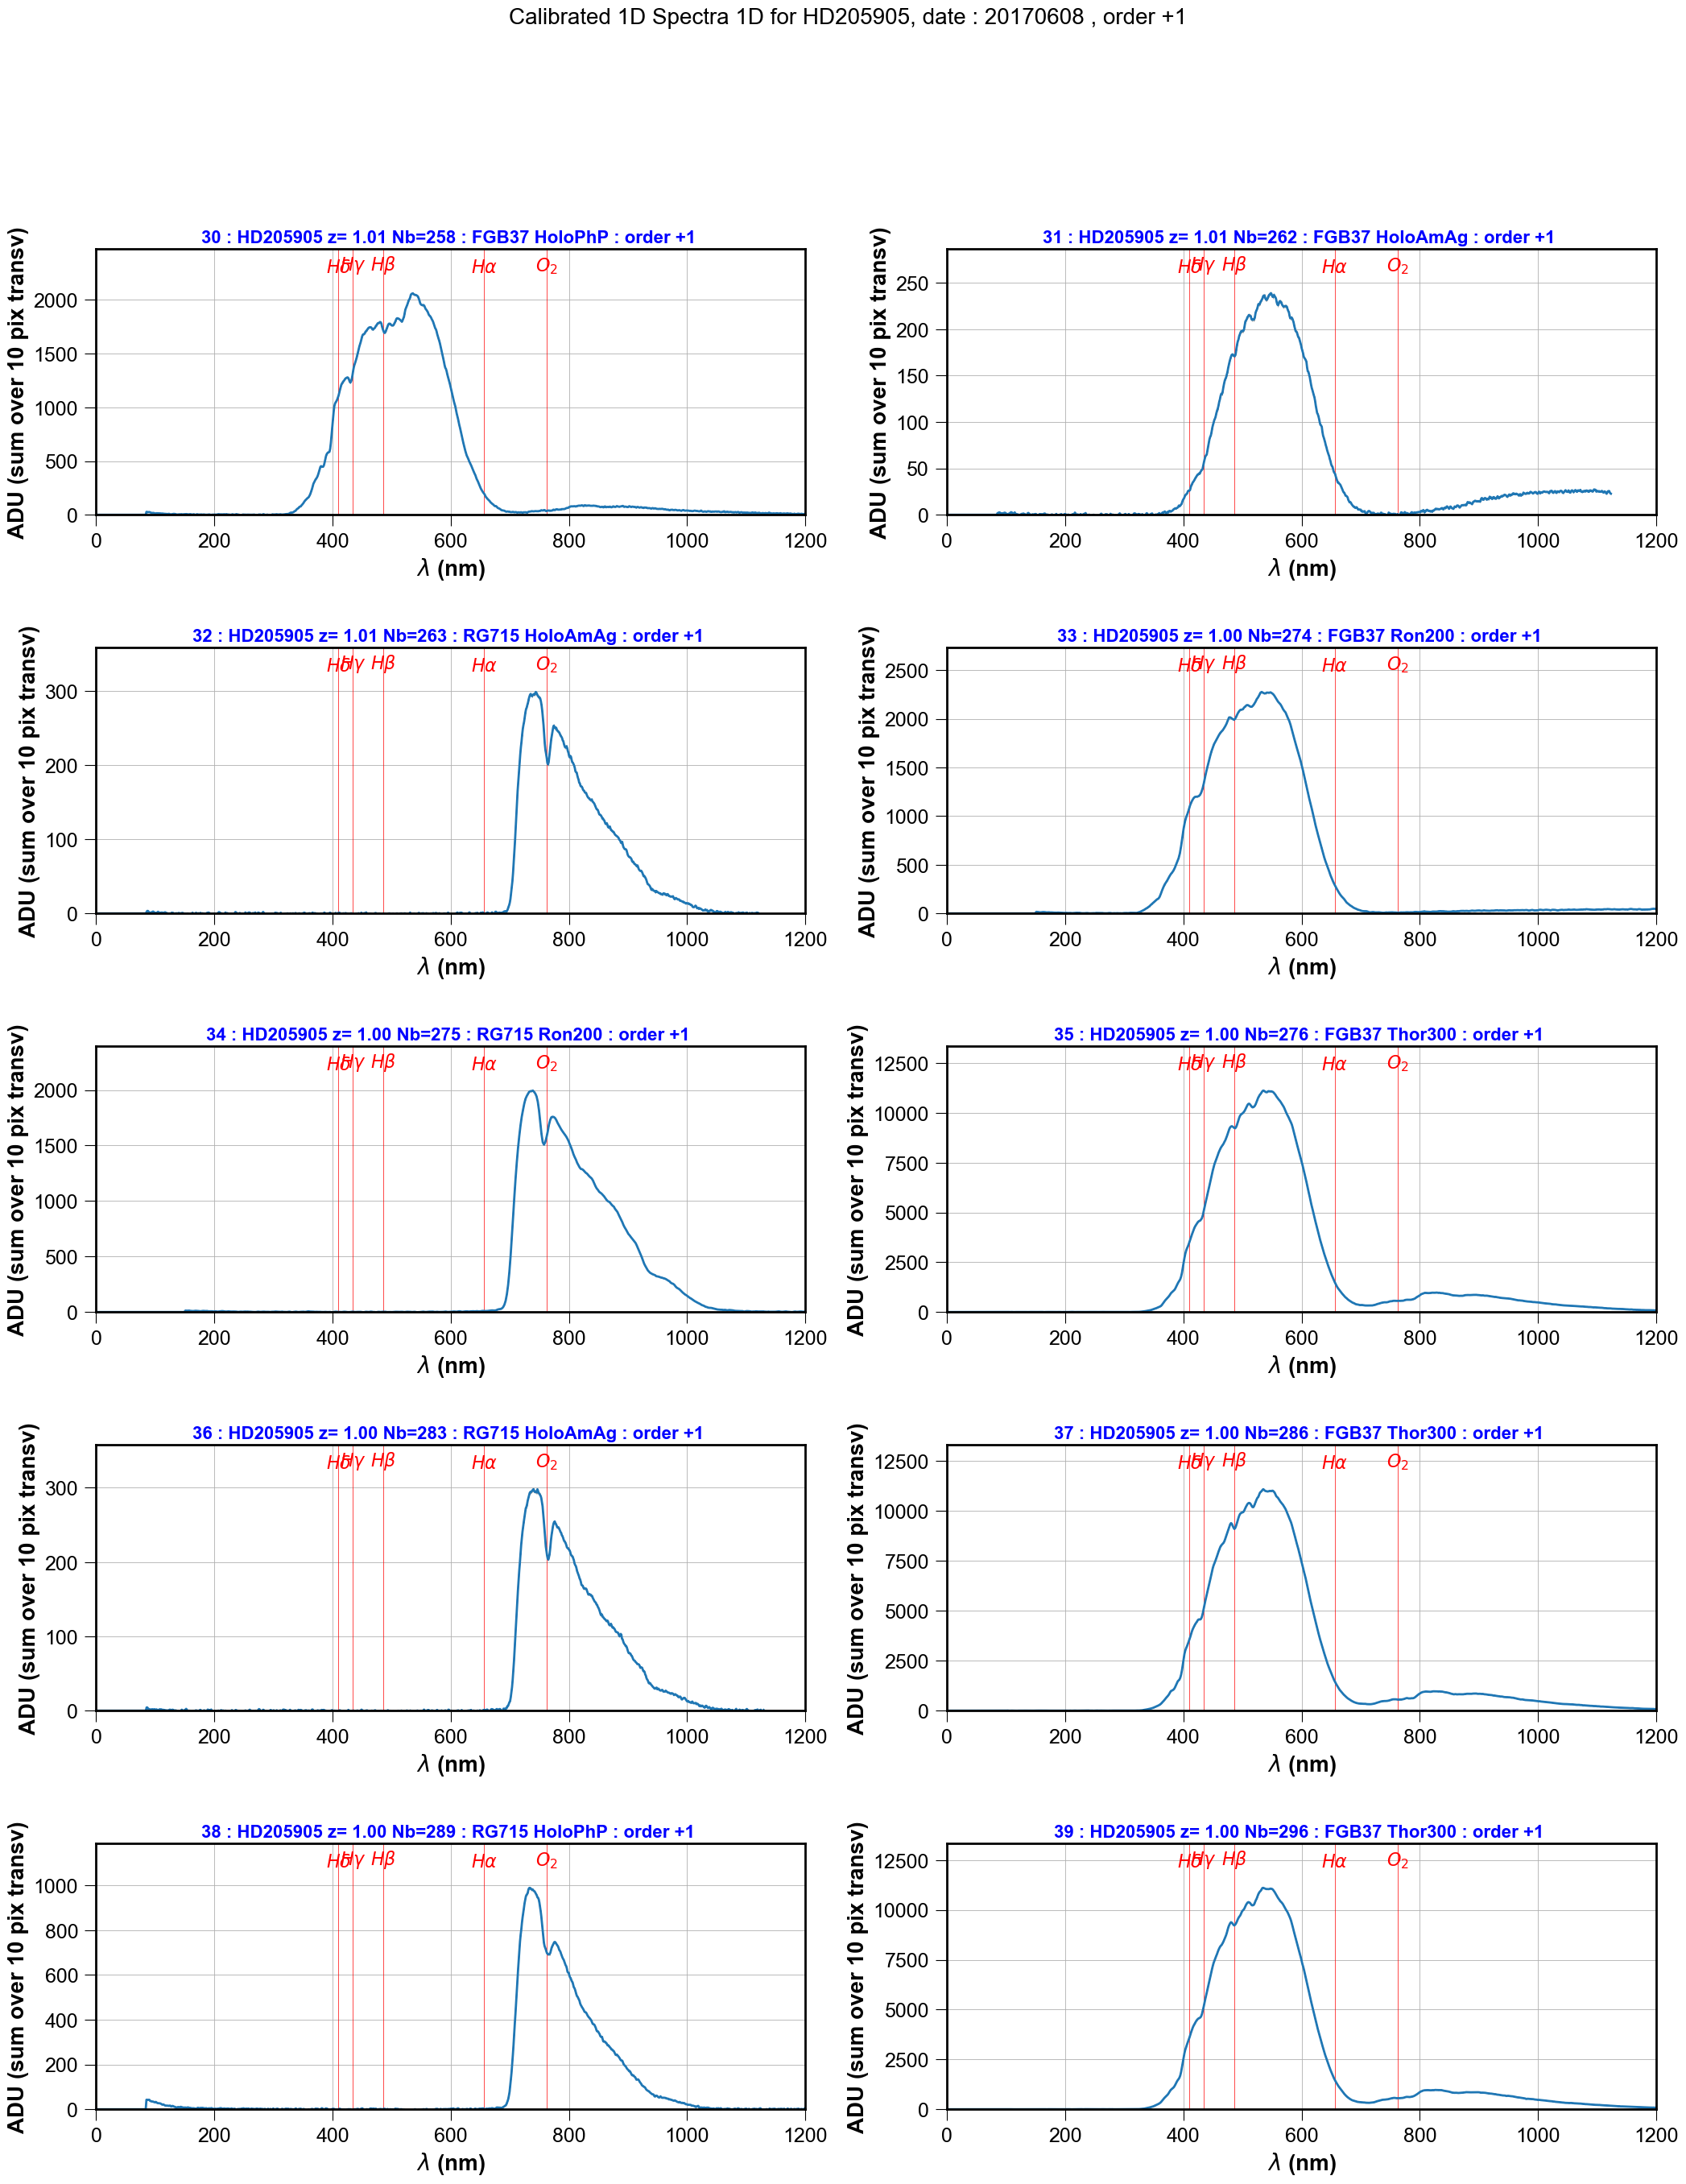

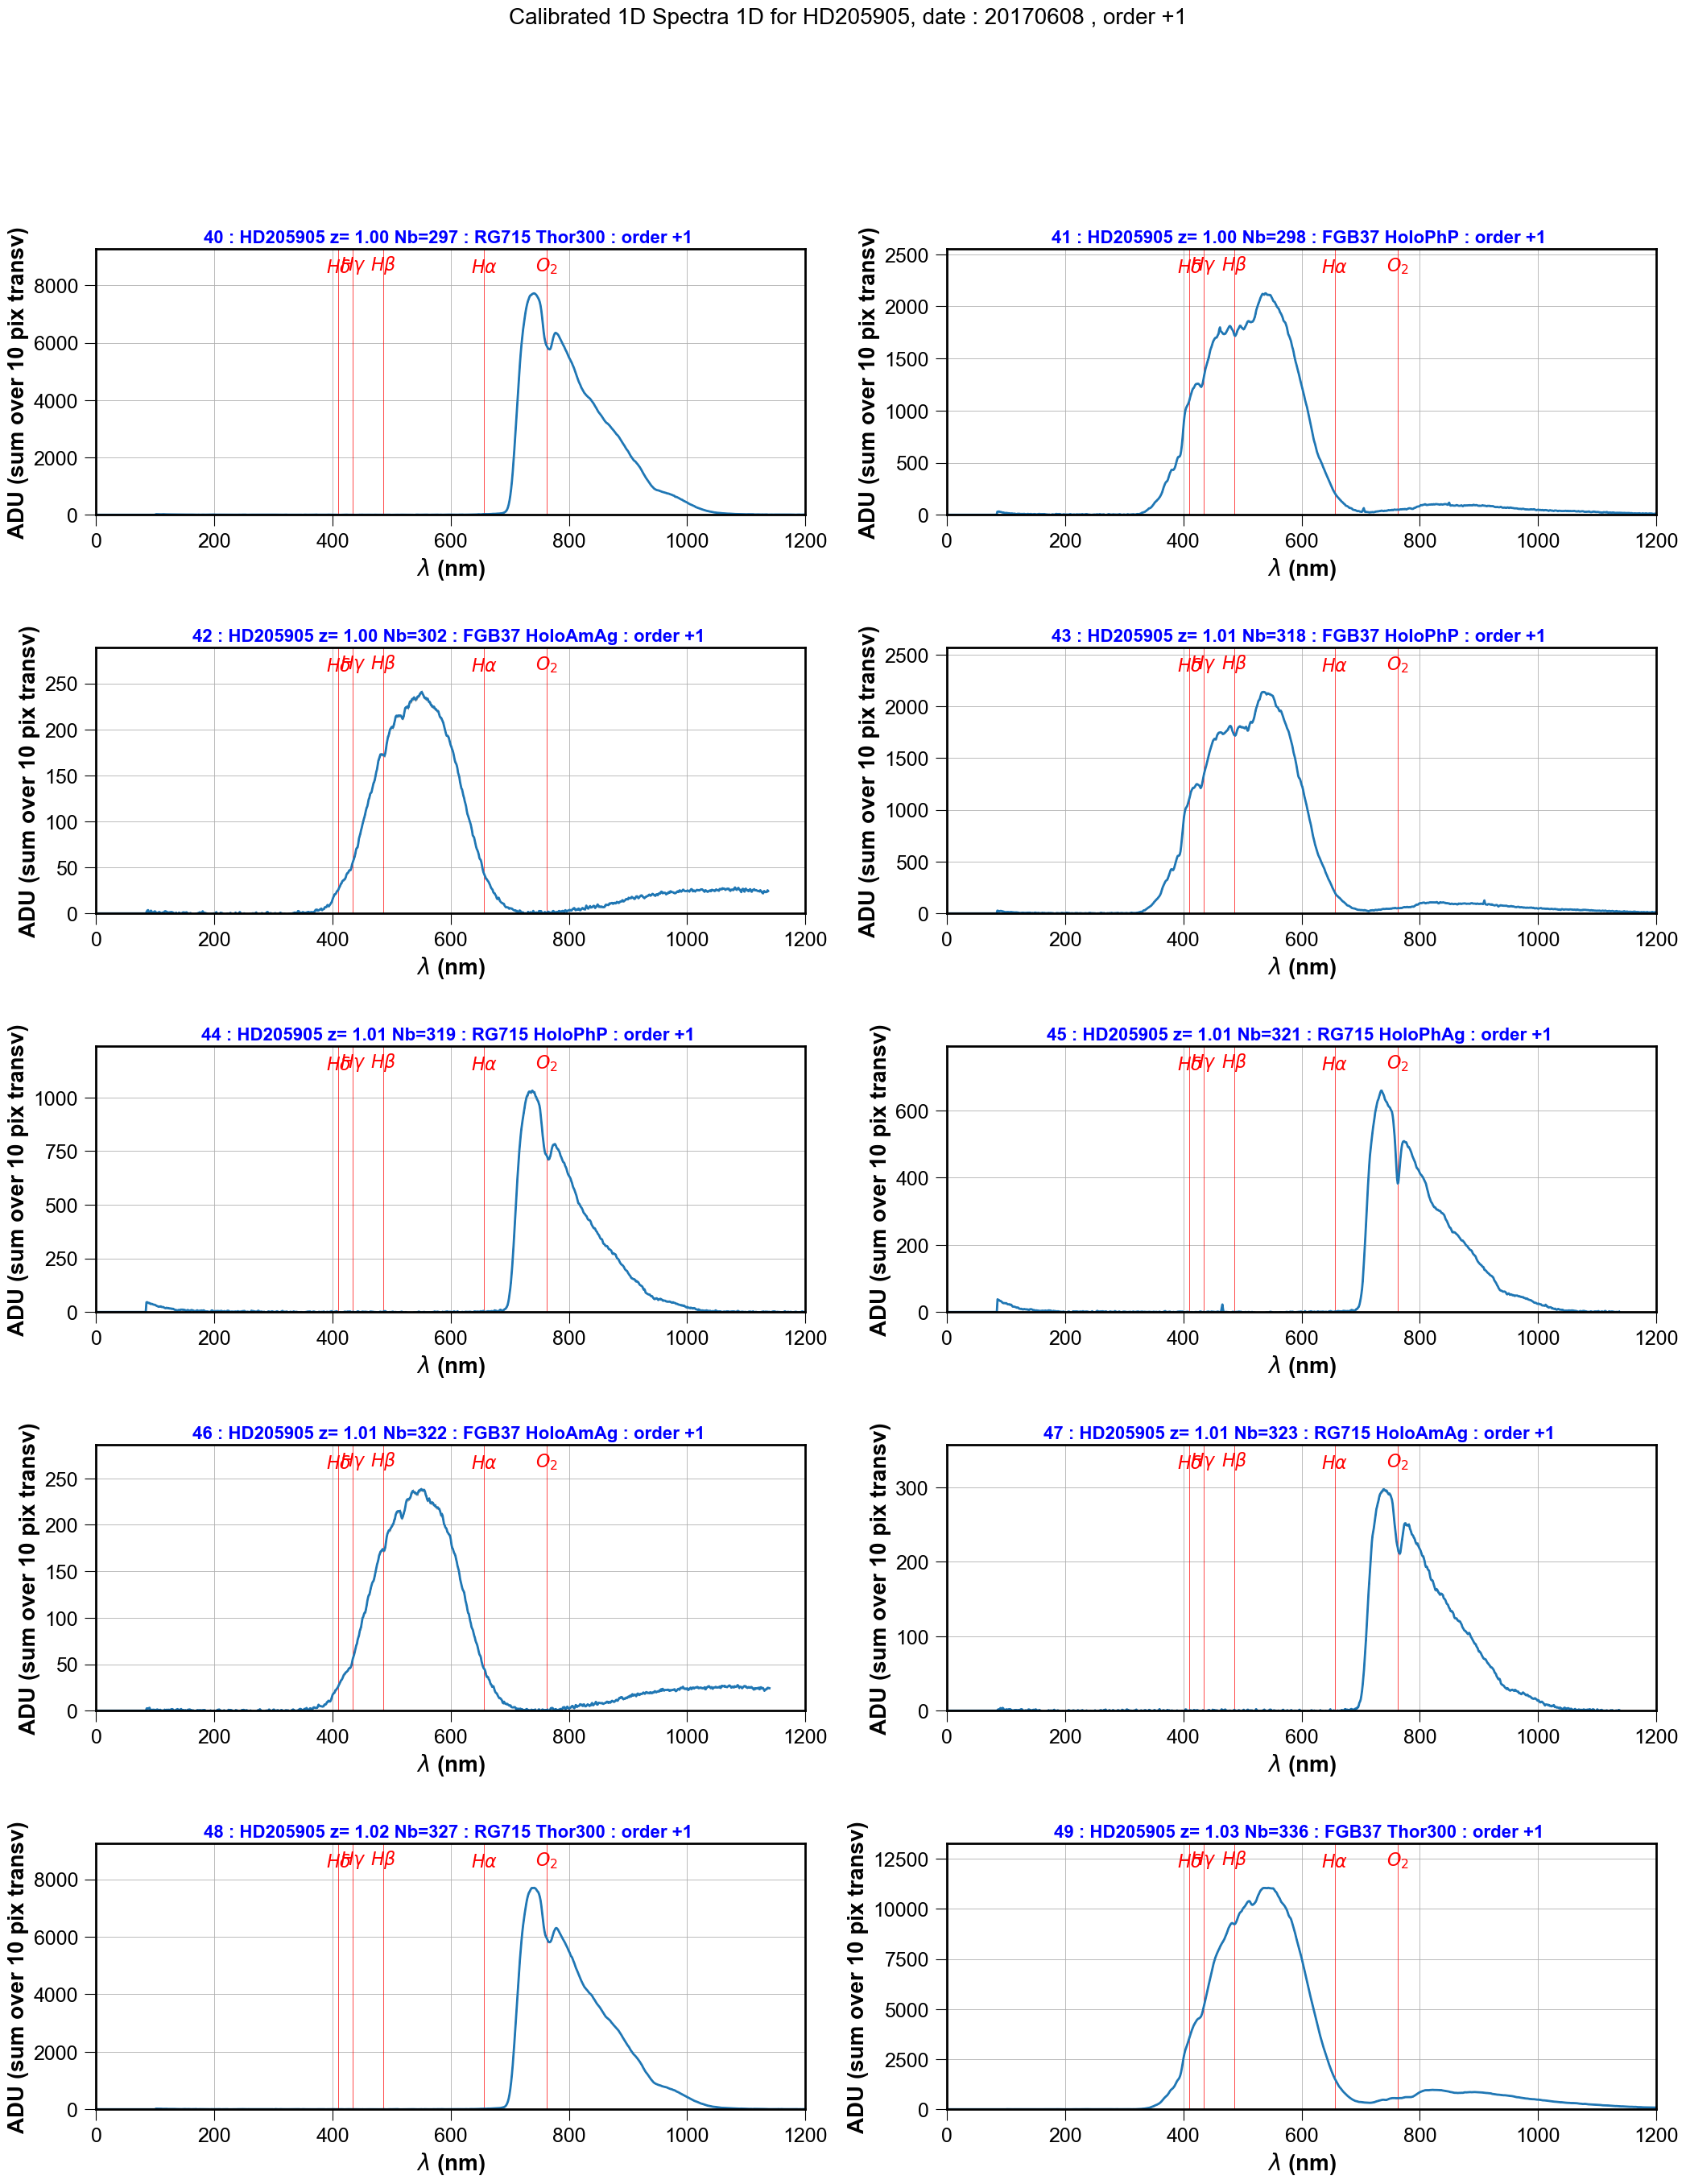

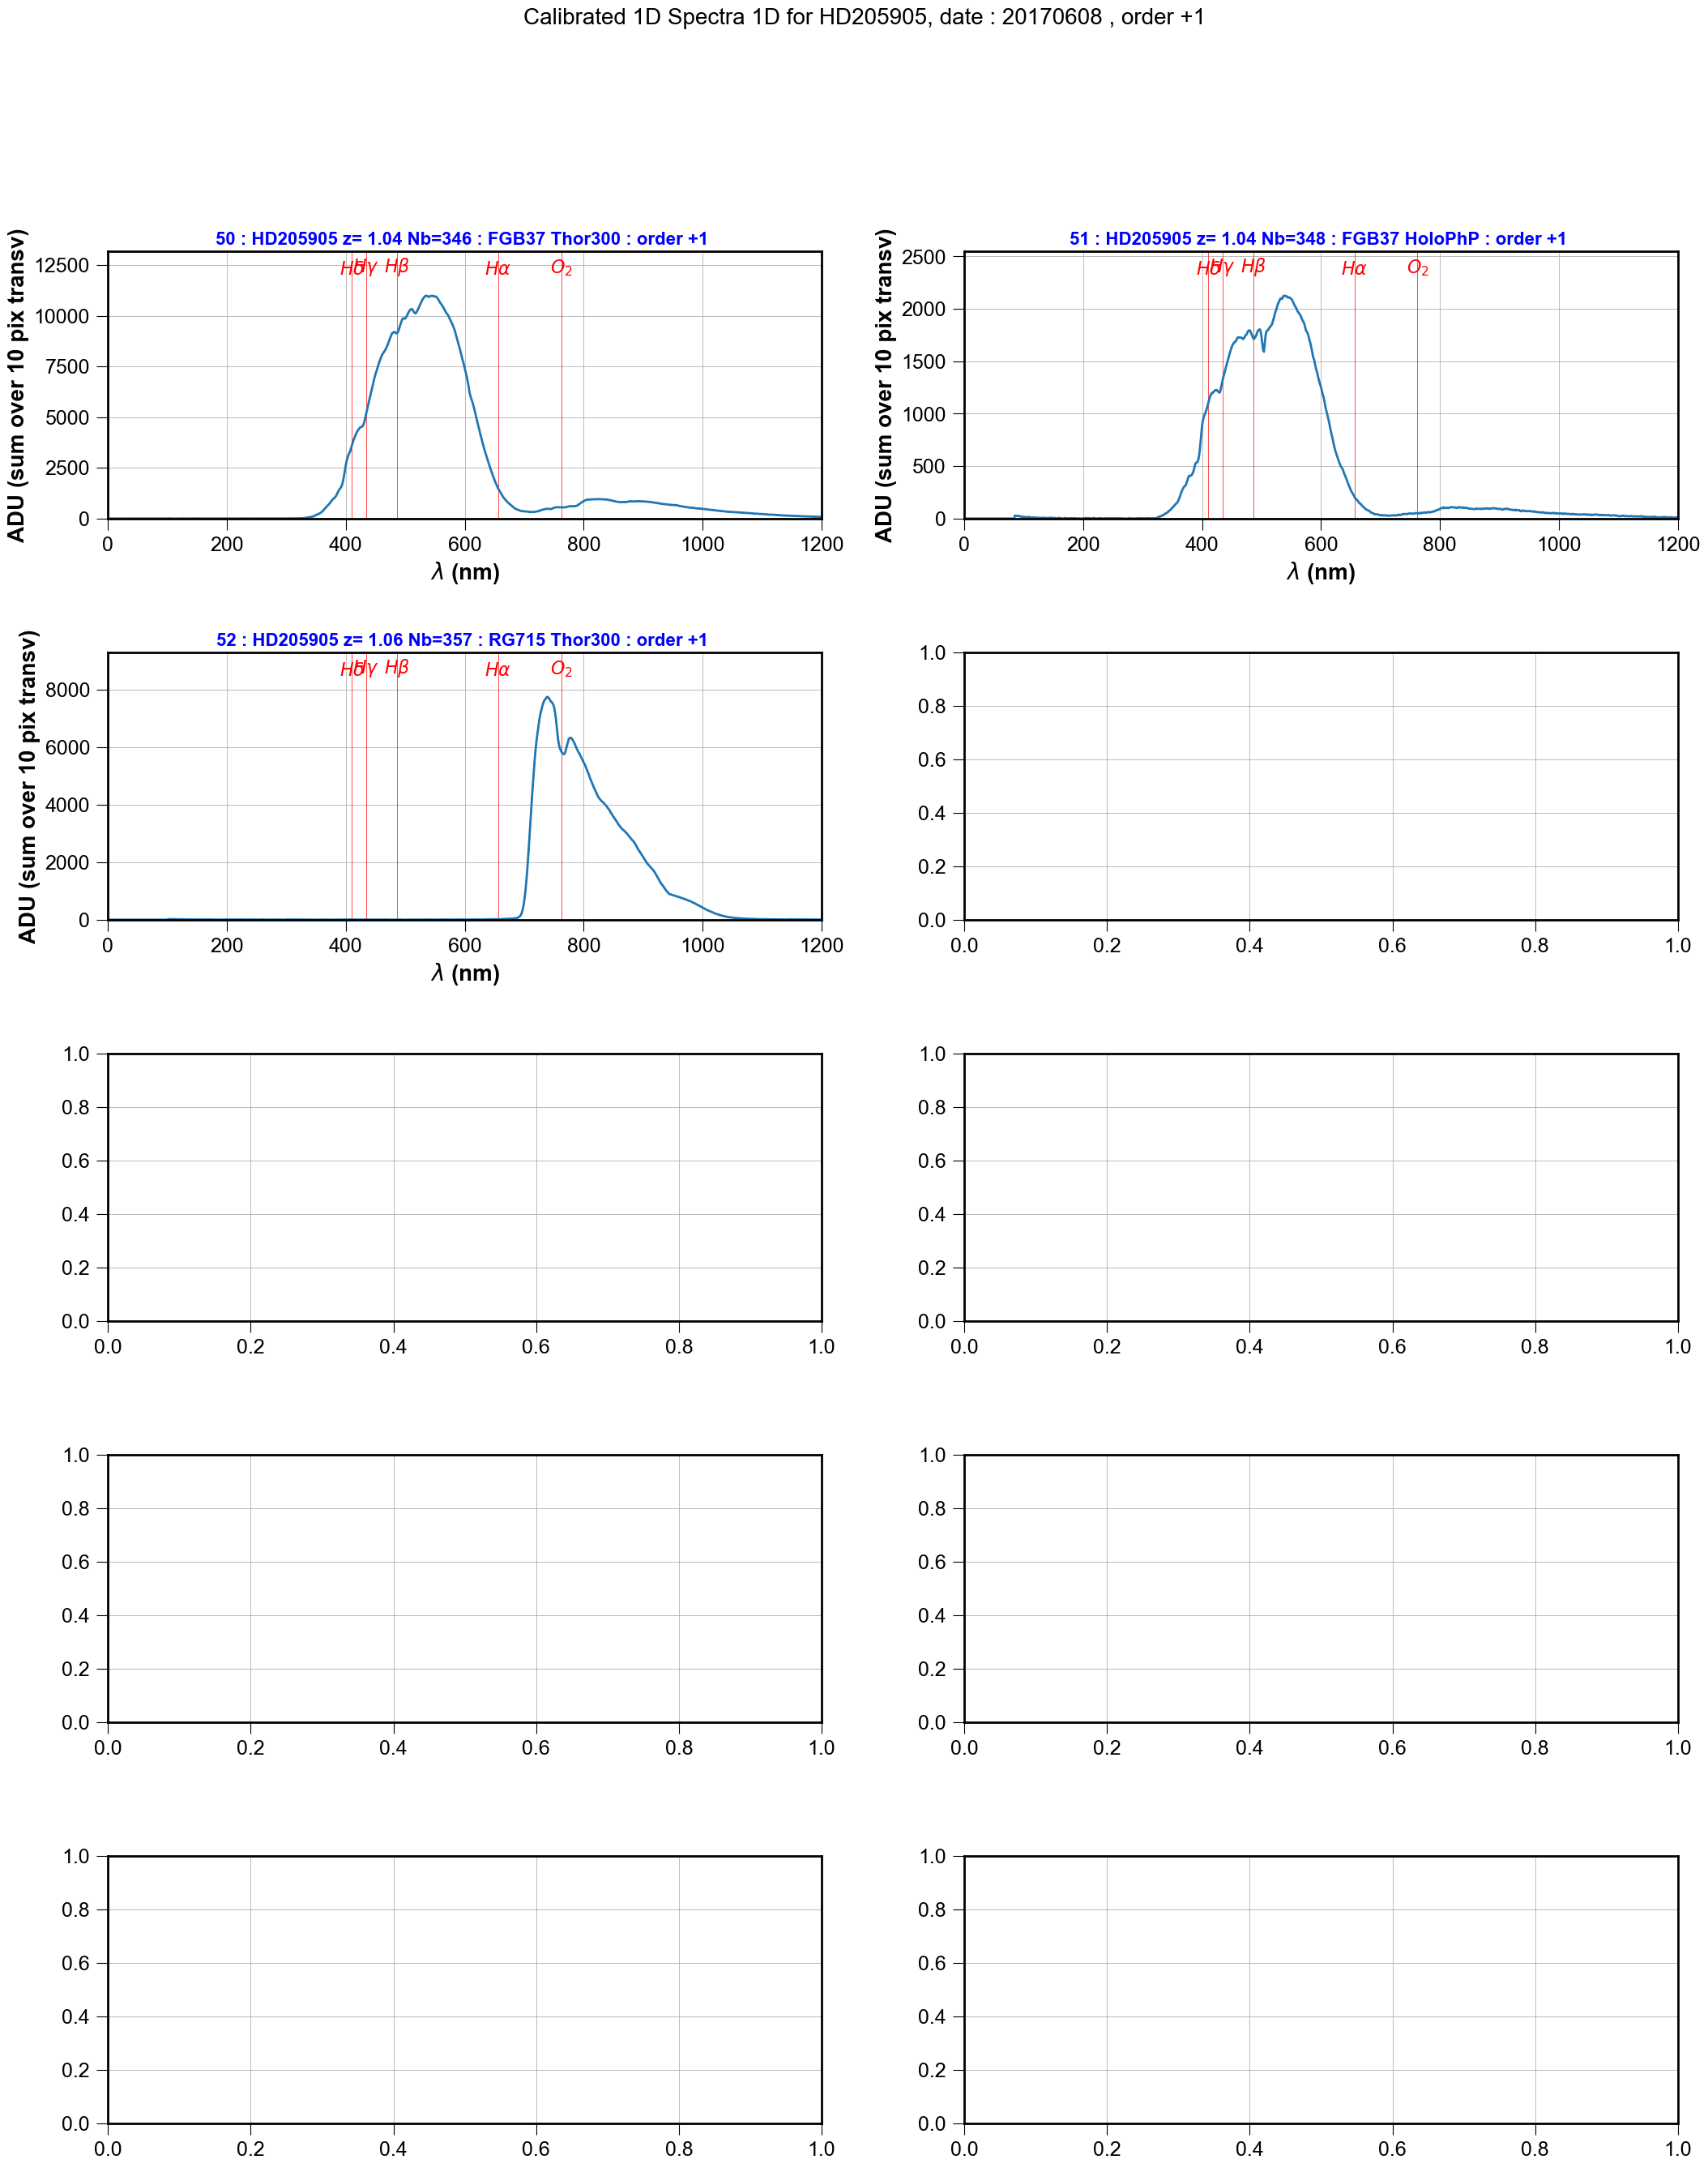

In [29]:
ShowCalibSpectrainPDF(all_rightspectra_data,all_rightspectra_data_stat_err,all_rightspectra_wl,all_titles,object_name,dir_top_images,all_filt,date,'calib1Dspectra_right.pdf','order +1')

In [30]:
#ShowCalibSpectrainPDF(all_leftspectra_data,all_leftspectra_data_stat_err,all_leftspectra_wl,all_titles,object_name,dir_top_images,all_filt,date,'calib1Dspectra_left.pdf','order -1')

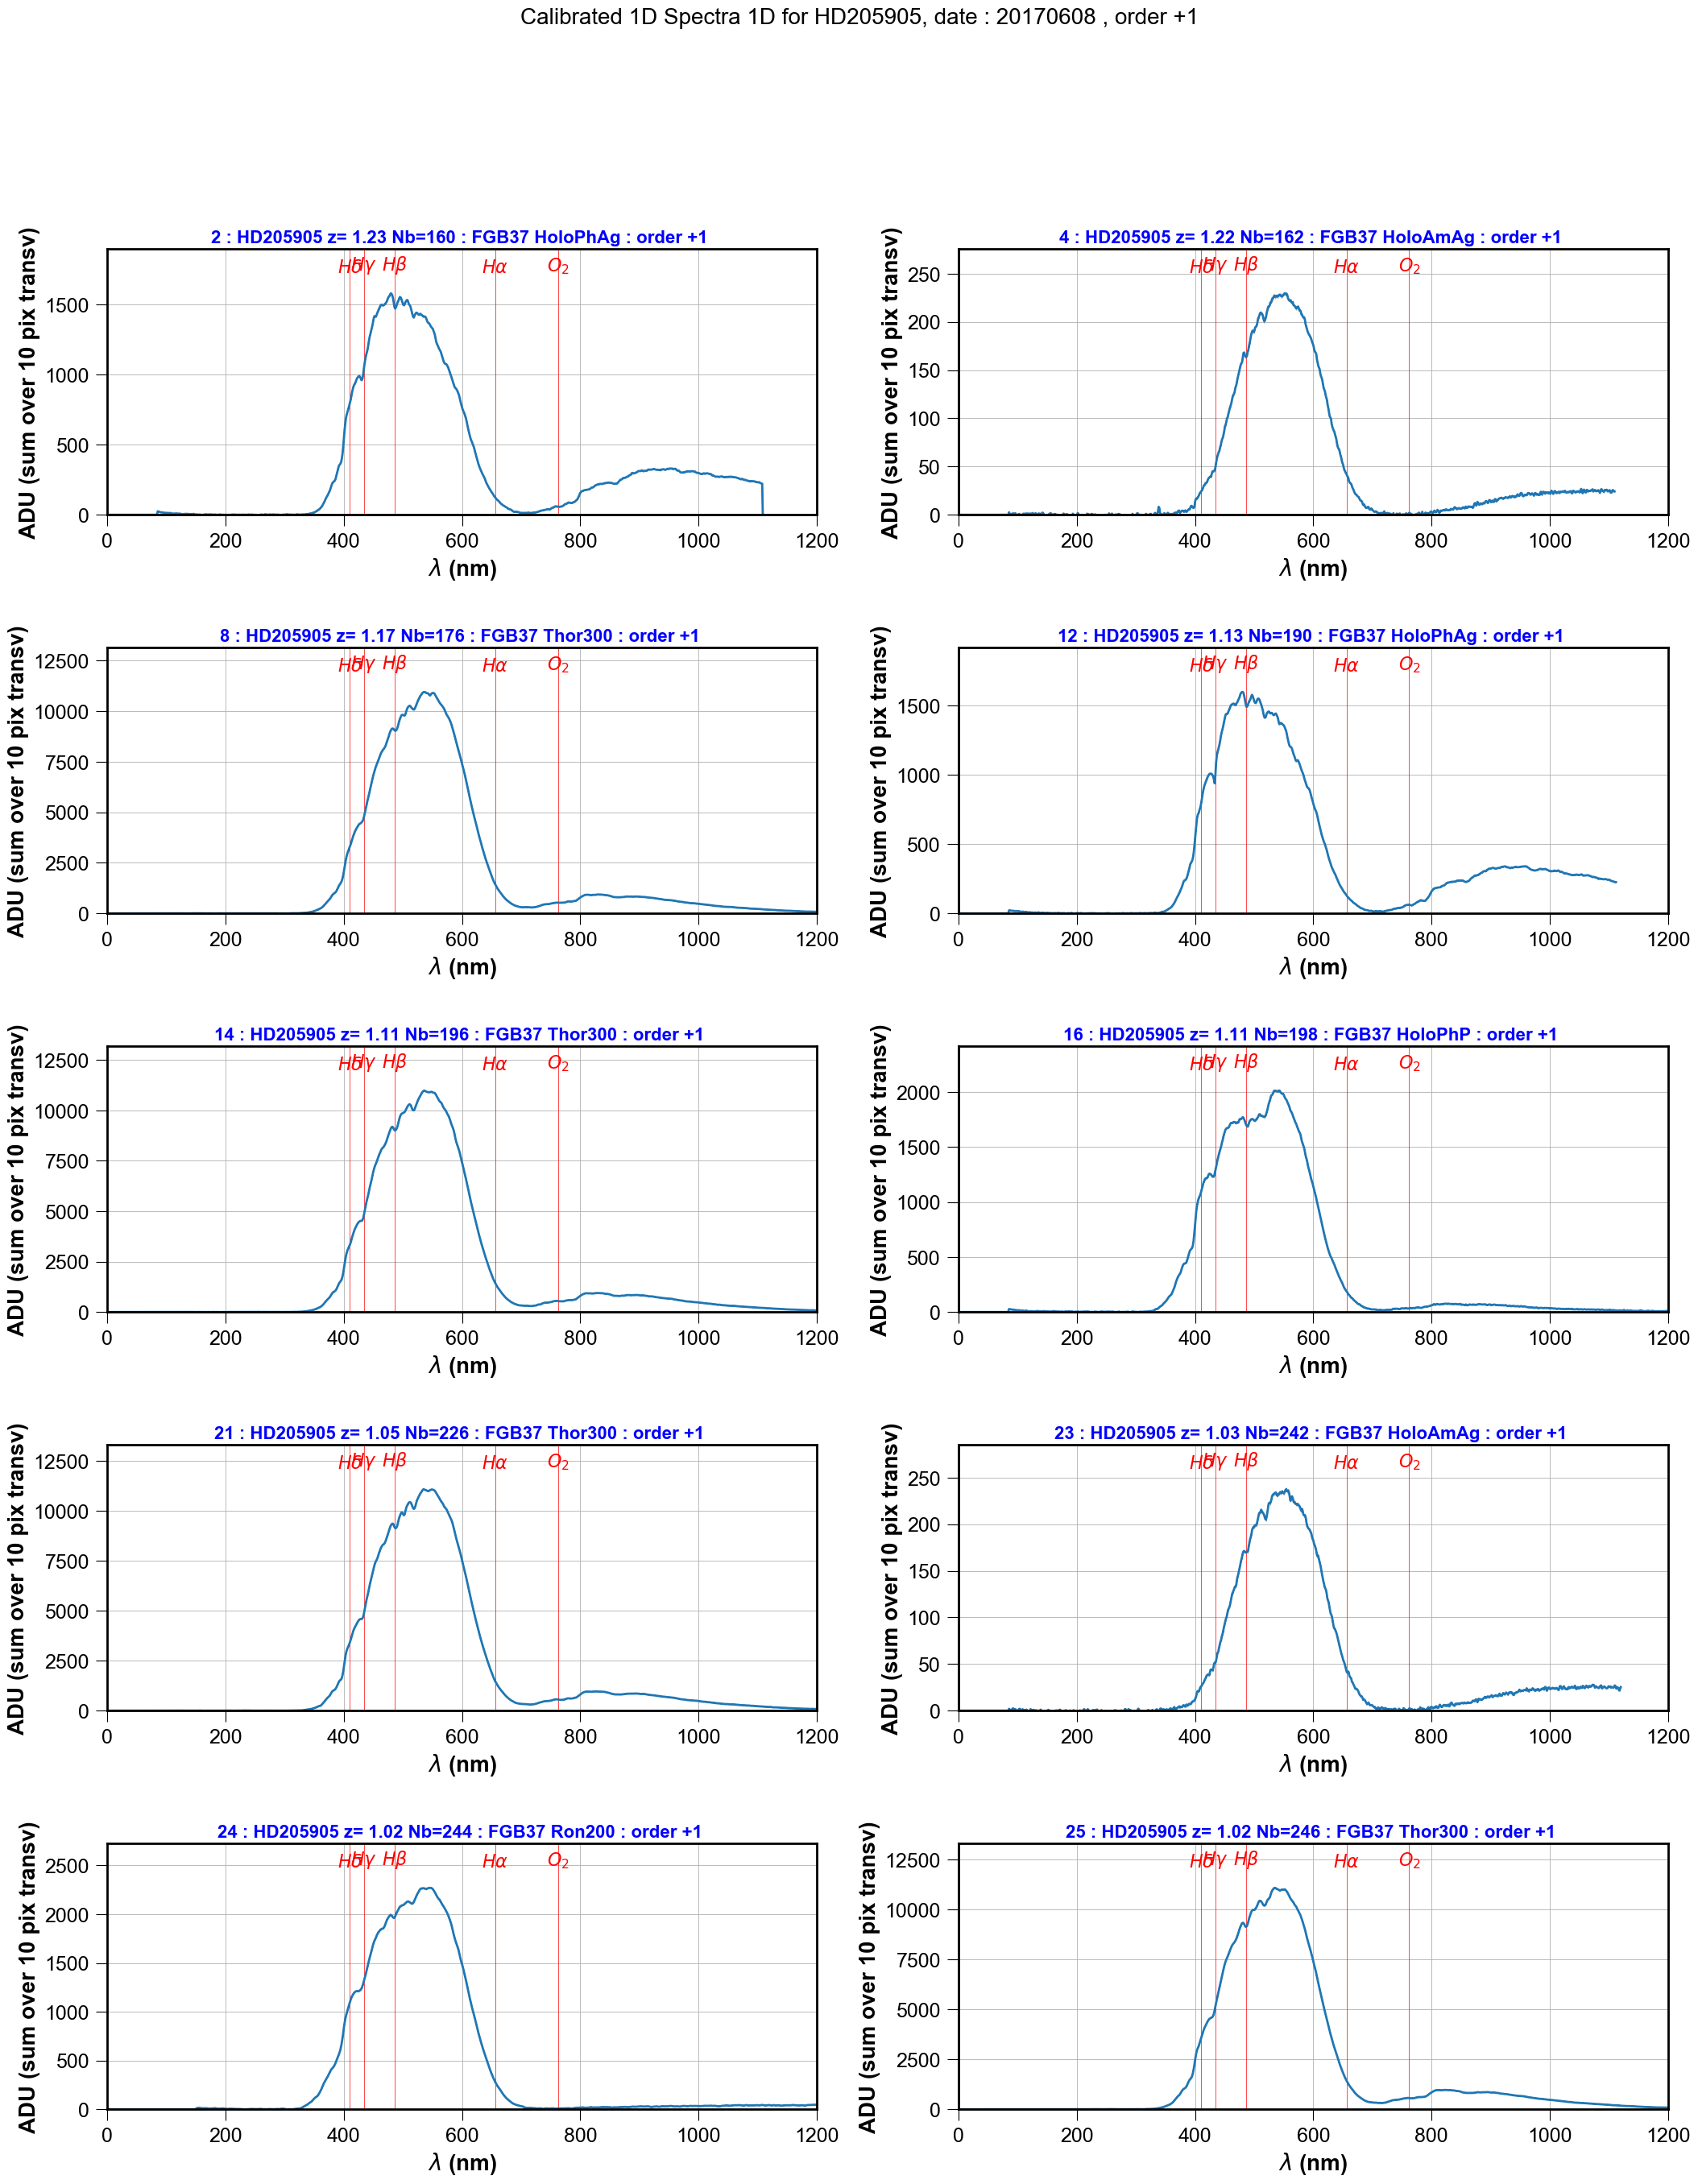

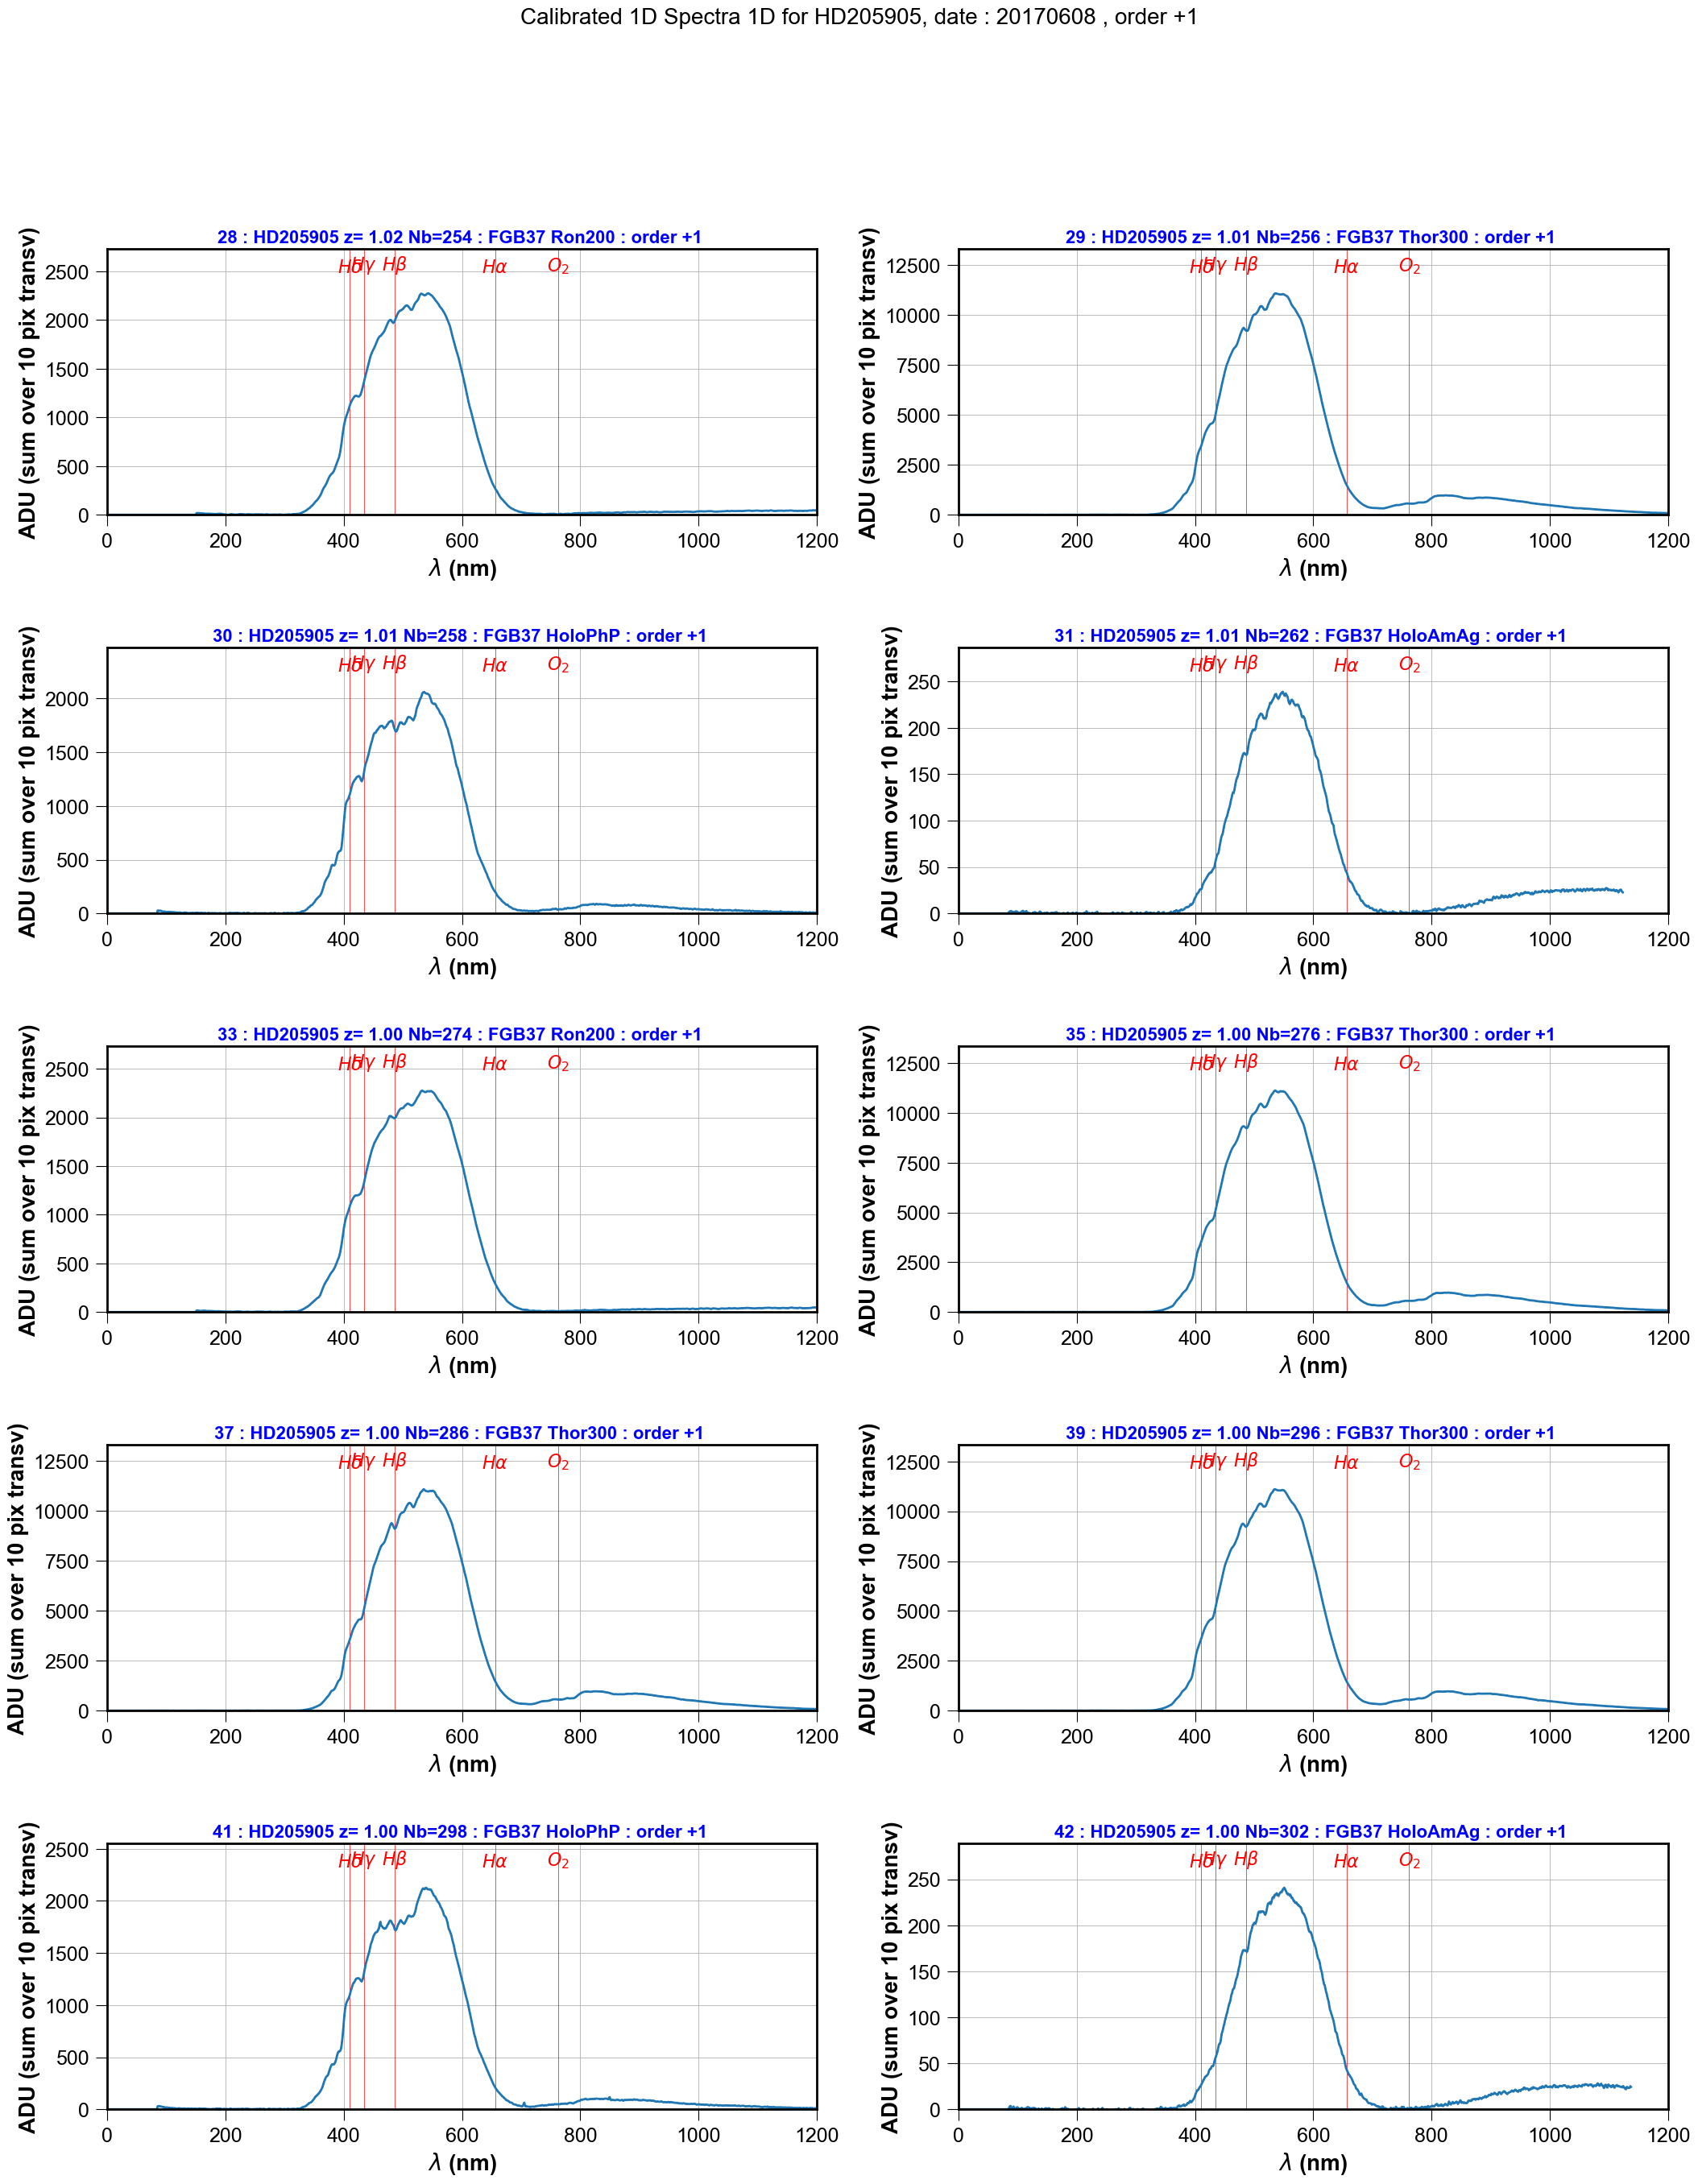

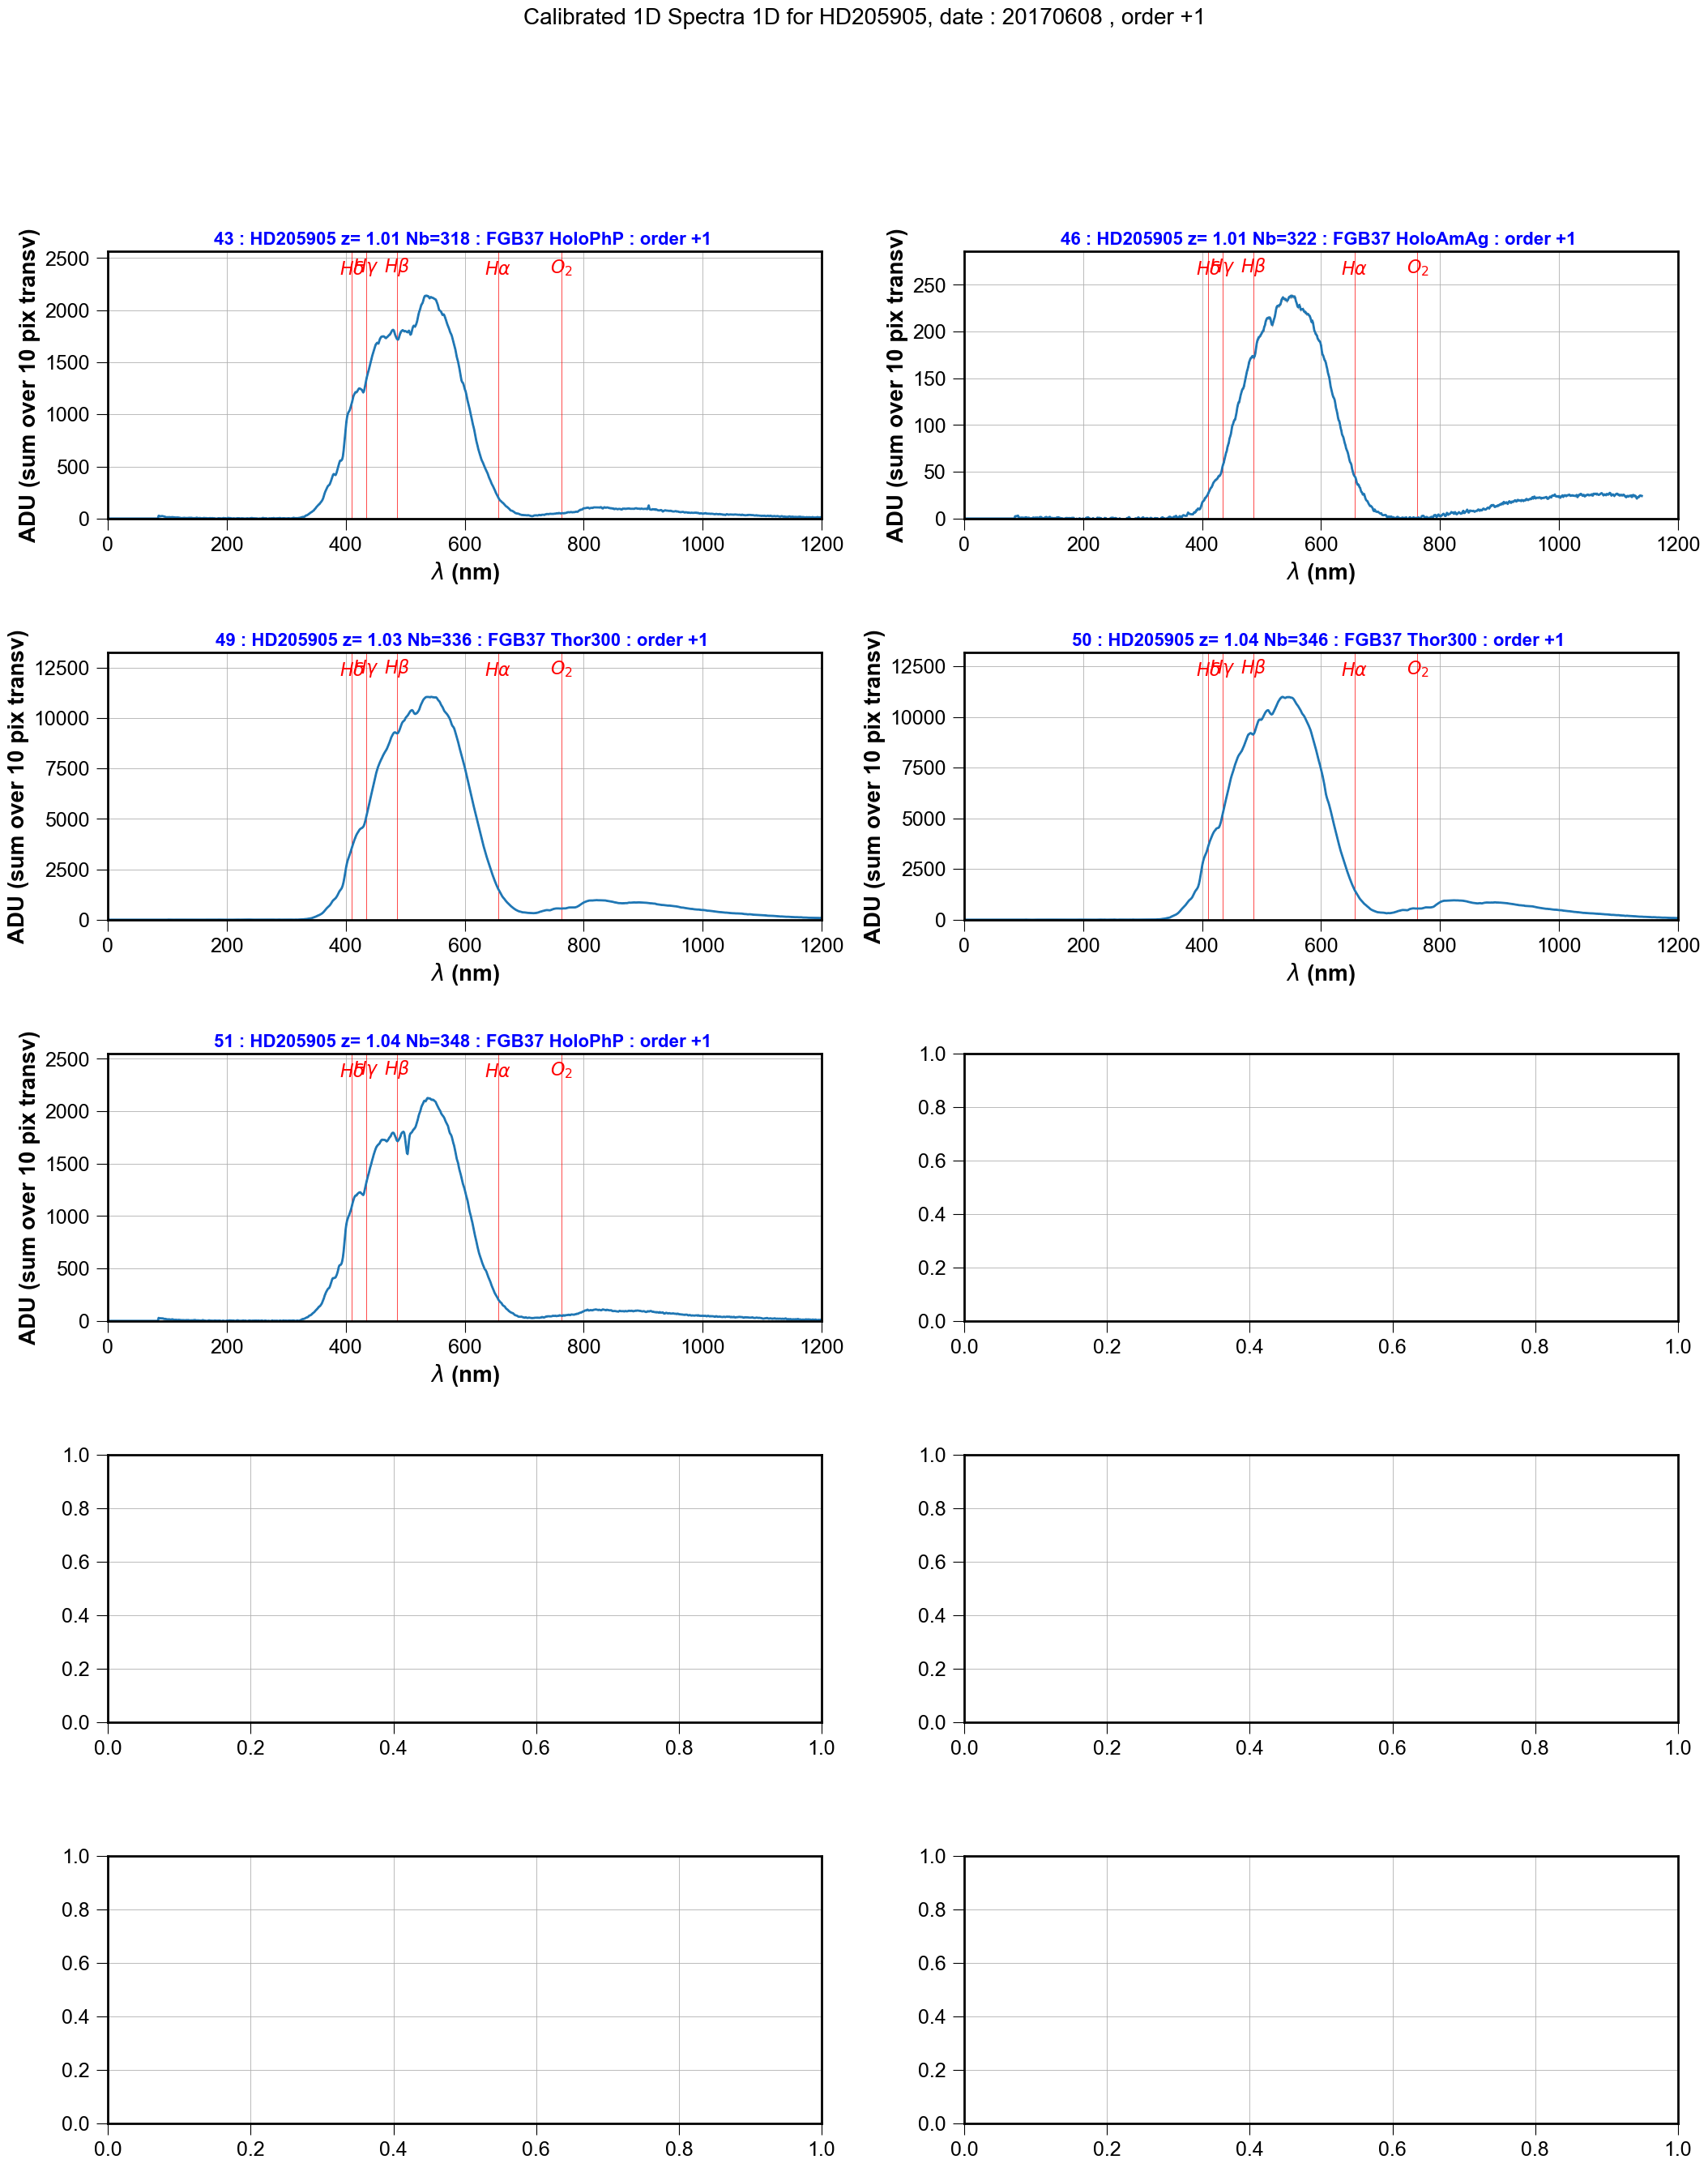

In [31]:
ShowCalibSpectrainPDFSelect(all_rightspectra_data,all_rightspectra_data_stat_err,all_rightspectra_wl,all_titles,object_name,dir_top_images,all_filt,all_filt1,all_filt2,date,'calib1DspectraSel_right.pdf','order +1')

# To study contamination by order 2 ==> Select FGB37 Filter data

In [32]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#plt.rcParams.update({'font.size': MEDIUM_SIZE})

## Find the indexes with tag FGB37

In [33]:
all_filt1=np.array(all_filt1)
Selected_Indexes=np.where(all_filt1=='FGB37')[0]

In [34]:
Selected_Indexes

array([ 2,  4,  8, 12, 14, 16, 21, 23, 24, 25, 28, 29, 30, 31, 33, 35, 37,
       39, 41, 42, 43, 46, 49, 50, 51])

## Remember the corresponding filters and disperser

In [35]:
all_filt2=np.array(all_filt2)
Selected_Dispersers=all_filt2[Selected_Indexes]

In [36]:
Selected_Dispersers

array(['HoloPhAg', 'HoloAmAg', 'Thor300', 'HoloPhAg', 'Thor300',
       'HoloPhP', 'Thor300', 'HoloAmAg', 'Ron200', 'Thor300', 'Ron200',
       'Thor300', 'HoloPhP', 'HoloAmAg', 'Ron200', 'Thor300', 'Thor300',
       'Thor300', 'HoloPhP', 'HoloAmAg', 'HoloPhP', 'HoloAmAg', 'Thor300',
       'Thor300', 'HoloPhP'], dtype='|S8')

In [37]:
all_filt=np.array(all_filt)
Select_Filt=all_filt[Selected_Indexes]

## Build X, Y and interpolation function
## ==============================

In [38]:
all_interpolate = [] # interpolation functions
all_spc= []          # spectrum
lambdas=np.linspace(300.,1100.,800) # spectrum wavelength domain
for idx in Selected_Indexes:
    index=idx
    # define (x,y)    
    x=all_rightspectra_wl[index]
    y=all_rightspectra_data[index]
    # interpolation function y = f(x)
    f = interpolate.interp1d(x, y)
    # calculate y=f(x), where x are the tabulated lambdas
    spc=f(lambdas)
    # save in container
    all_interpolate.append(f)
    all_spc.append(spc)

### Check the interpolation
### ---------------------------

Text(0,0.5,'ADU ')

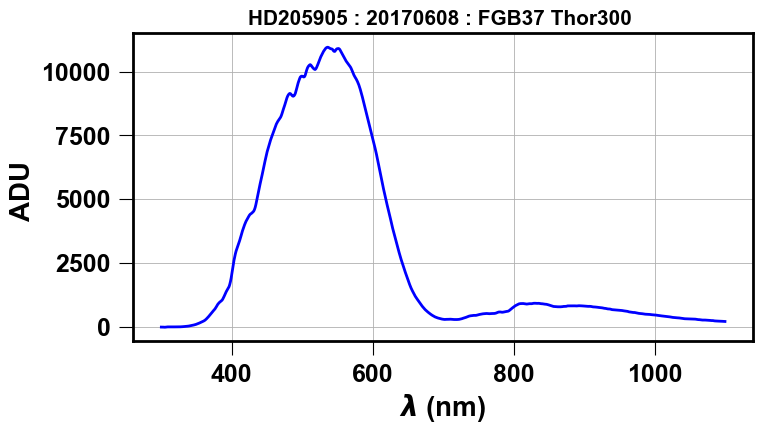

In [89]:
sel=2
title="{} : {} : {} ".format(object_name,date,Select_Filt[sel])
plt.title(title)
plt.plot(lambdas,all_spc[sel],'b-')
plt.xlabel("$\lambda$ (nm) ")
plt.ylabel("ADU ")
#plt.xlim(600.,1100.)

Text(0.5,1.02,'HD205905 : 20170608 : FGB37 Thor300 ')

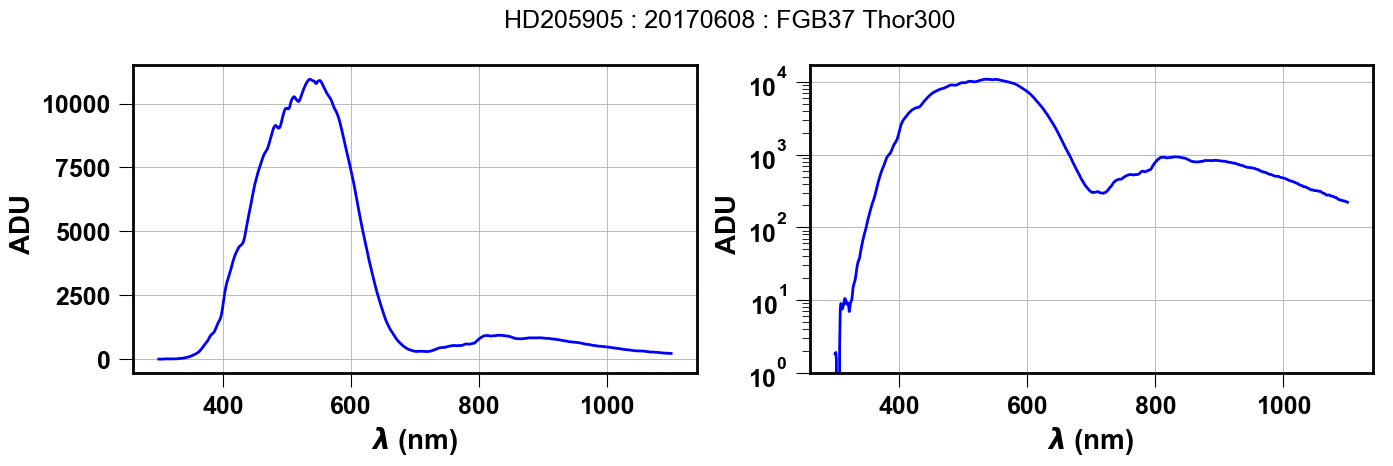

In [95]:
sel=2
title="{} : {} : {} ".format(object_name,date,Select_Filt[sel])

fig=plt.figure(figsize=(16,4))
ax1=fig.add_subplot(121)
ax1.plot(lambdas,all_spc[sel],'b-')
ax1.set_xlabel("$\lambda$ (nm) ")
ax1.set_ylabel("ADU ")

ax2=fig.add_subplot(122)
ax2.plot(lambdas,all_spc[sel],'b-')
ax2.set_xlabel("$\lambda$ (nm) ")
ax2.set_ylabel("ADU ")
ax2.set_yscale("log")

plt.suptitle(title,Y=1.02,fontsize=18)


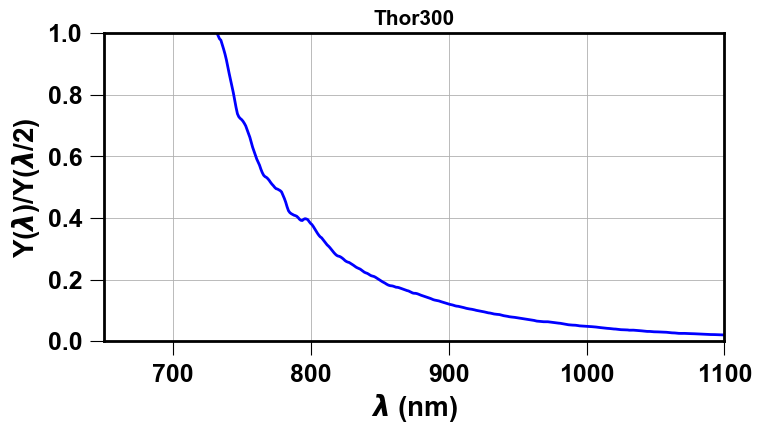

In [112]:
PlotContamination(lambdas,all_spc[sel],all_interpolate[sel],Selected_Dispersers[sel])

In [40]:
from IPython.display import Latex

# Compute the ratio 


$$
\begin{equation}
Y = \frac{Y(\lambda)}{Y(\lambda / 2)}
\end{equation}
$$

In [117]:
def GiveContamination(wavelength,spectrum,interpol_f):
    """
    Compute contamination
    =====================
    
    input:
        - wavelength : array of wavelength
        - spectrum   : spectrum
        - interpol_f : interpolation function
    """
    X=wavelength        # in range 300 nm - 1100 nm, same binning as spectrum
    XMIN=np.min(X)
    XMAX=np.max(X)
    Yfullscale=spectrum
    
    Xhalf=X/2.  # in range 150 nm - 550 nm  same binning as spectrum
    
    #find indexes which are in the range XMIN-XMAX
    sel_index=np.where(np.logical_and(Xhalf>=XMIN,Xhalf<=XMAX))[0] # Xhalf must be in wl domain (XMIN,XMAX)
    
    wl_sel=X[sel_index]  # get indexes of X which half is still in the Xmin-Xmax/2 range
    
    Xcut=X[sel_index]            # should be the second order bump
    Ycut=Yfullscale[sel_index]   # shoudl be the second order bump
    
    Xhalf_cut=Xhalf[sel_index]  # wavelength lambdas/2 in the wl domain, should be the first order bump
    Yhalf_cut=interpol_f(Xhalf_cut)  # interpolate the spectrum at half lambda # should be the first order bump
    
    ratio= Ycut/Yhalf_cut  # shoudl be the ratio order 2/order 1
    
    #print("Input : Wavelength=",wavelength)
    #print("Xhalf =",Xhalf)
    #print("Xcut=",Xcut)
    #print("Xhalf_cut=",Xcut)
    
    return wl_sel,ratio, Xhalf_cut, Yhalf_cut,Xcut,Ycut    

In [122]:
def PlotContamination(wavelength,spectrum,interpol_f,grating_name):
    wl,r,wl1,o1,wl2,o2=GiveContamination(wavelength,spectrum,interpol_f)
    thetitle=grating_name
    
    plt.figure(figsize=(6,4))
    plt.title(thetitle)
    plt.plot(wl,r,'b-',lw=2)
    plt.xlim(650.,1100.)
    plt.ylim(0.,1.0)
    plt.xlabel("$\lambda$ (nm)")
    plt.ylabel("Y($\lambda$)/Y($\lambda$/2)")
    
    return wl1,o1,wl2,o2

In [123]:
def PlotContaminationinPDF(wavelength,spectrum,interpol_f,title,dir_top_img,figname):
    """
    """
    
    figfilename=os.path.join(dir_top_img,figname)
    
    wl,r,wl1,o1,wl2,o2=GiveContamination(wavelength,spectrum,interpol_f)
    
    
    f, (ax1, ax2) = plt.subplots(1, 2,figsize=(6,4))
    f.suptitle(title,size=20)
    ax1.plot(wavelength,spectrum,'b-',lw=2)
    ax1.set_xlabel("$\lambda$ (nm)")
    ax1.set_ylabel("Y($\lambda$) (ADU)")
    
    ax2.plot(wl,r,'b-',lw=2)
    ax2.set_xlim(800.,1100.)
    ax2.set_ylim(0.,0.3)
    ax2.set_xlabel("$\lambda$ (nm)")
    ax2.set_ylabel("Y($\lambda$)/Y($\lambda$/2)")
    
    f.savefig(figfilename)
    return wl1,o1,wl2,o2

### Study one spectrum

#### Raw Spectrum

Text(0.5,1.02,'Spectra per pixel HD205905 : 20170608 : FGB37 Thor300 ')

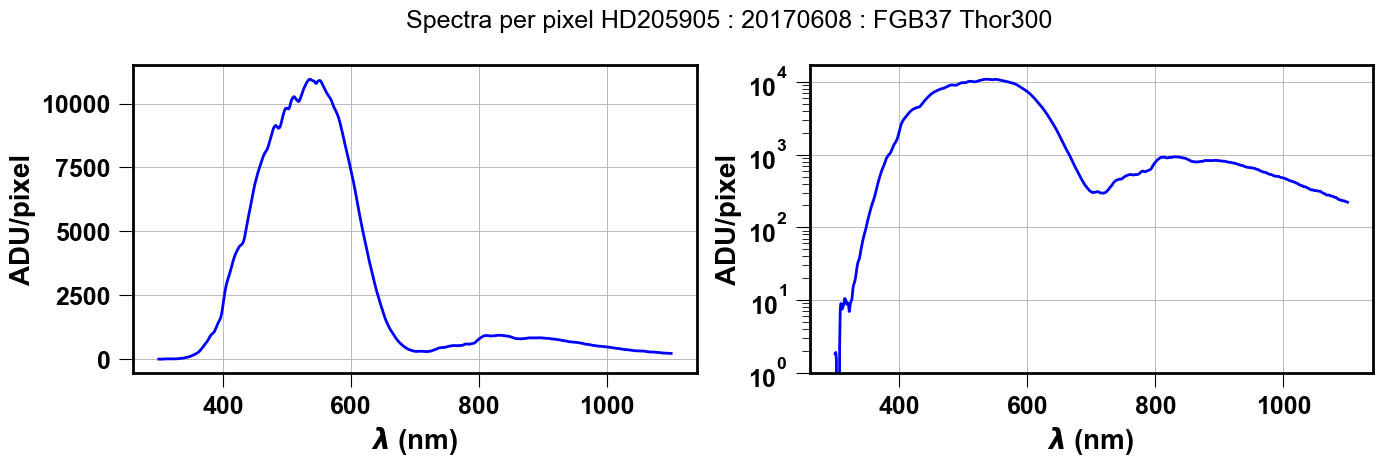

In [142]:
sel=2
title="Spectra per pixel {} : {} : {} ".format(object_name,date,Select_Filt[sel])

fig=plt.figure(figsize=(16,4))
ax1=fig.add_subplot(121)
ax1.plot(lambdas,all_spc[sel],'b-')
ax1.set_xlabel("$\lambda$ (nm) ")
ax1.set_ylabel("ADU/pixel")

ax2=fig.add_subplot(122)
ax2.plot(lambdas,all_spc[sel],'b-')
ax2.set_xlabel("$\lambda$ (nm) ")
ax2.set_ylabel("ADU/pixel")
ax2.set_yscale("log")

plt.suptitle(title,Y=1.02,fontsize=18)

In [204]:
a2=all_interpolate[sel]([1100])

In [205]:
a1=all_interpolate[sel]([550])

In [206]:
a2/a1

array([0.02032594])

#### Separate order 1 order 2

In [136]:
#wl1,o1,wl2,o2=PlotContamination(lambdas,all_spc[sel],all_interpolate[sel],Selected_Dispersers[sel])

In [127]:
wl0,r0,wl1,o1,wl2,o2=GiveContamination(lambdas,all_spc[sel],all_interpolate[sel])

Text(0.5,1.02,'Spectra per pixel : Separamtion order 1 and order 2 and ratio :HD205905 : 20170608 : FGB37 Thor300 ')

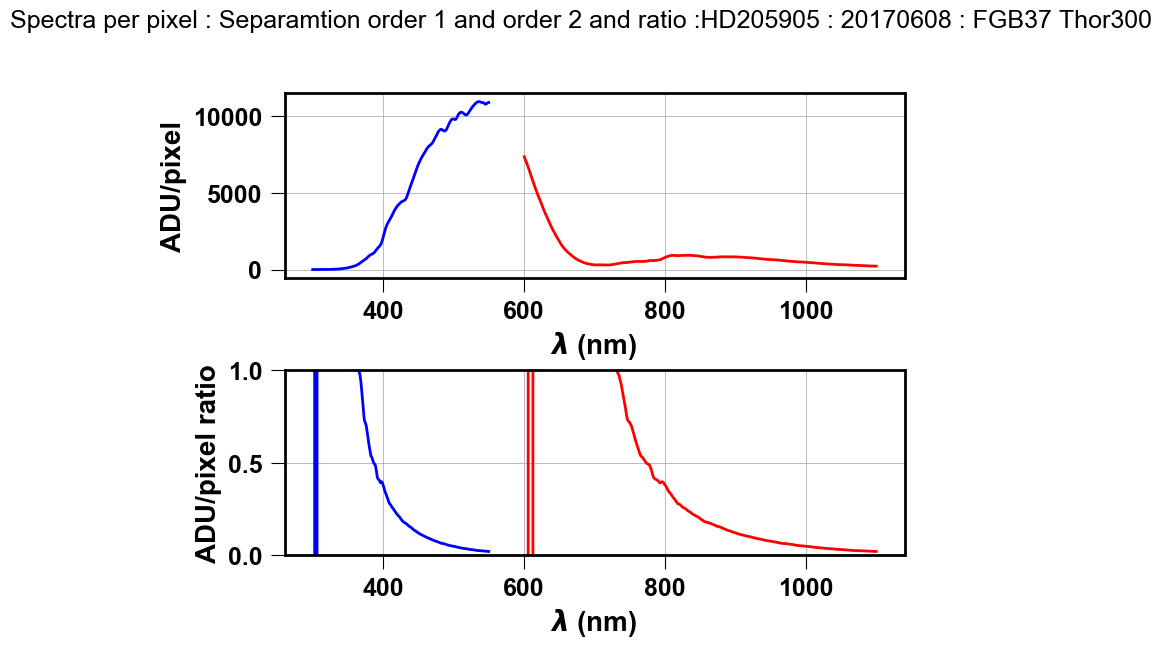

In [148]:
fig=plt.figure(figsize=(8,6))
ax1=fig.add_subplot(211)
ax1.plot(wl1,o1,"b-")
ax1.plot(wl2,o2,"r-")
ax1.set_xlabel("$\lambda$ (nm) ")
ax1.set_ylabel("ADU/pixel")

ax2=fig.add_subplot(212)
ax2.plot(wl0,r0,"r-")

ax2.plot(wl1,r0,"b-")
ax2.set_ylim(0,1)
ax2.set_xlabel("$\lambda$ (nm) ")
ax2.set_ylabel("ADU/pixel ratio")

title="Spectra per pixel : Separamtion order 1 and order 2 and ratio :{} : {} : {} ".format(object_name,date,Select_Filt[sel])
plt.suptitle(title,Y=1.02,fontsize=18)

#### Get spectrum per wavelength unit

In [165]:
WL=np.linspace(300.,1000.,100)
a=1/300.*mm_to_micr
D=58*mm_to_micr
#dxdlambda_R300=Dispersion_Rate(WL*nm_to_micr,1/300.*mm_to_micr,D)/Det_xpic*1e-3   # pixel per nm

dxdlambda_R300_order1=Dispersion_Rate2(WL*nm_to_micr,1/300.*mm_to_micr,D,p=1)/Det_xpic*1e-3 
dxdlambda_R300_order2=Dispersion_Rate2(WL*nm_to_micr,1/300.*mm_to_micr,D,p=2)/Det_xpic*1e-3 

Text(0,0.5,'$dx/d\\lambda$')

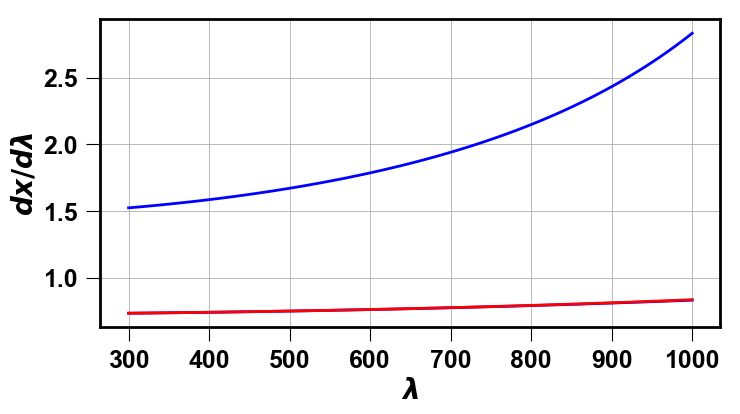

In [167]:
fig=plt.figure(figsize=(8,4))
ax1=fig.add_subplot(111)
ax1.plot(WL,dxdlambda_R300,"b-")
ax1.plot(WL,dxdlambda_R300_order1,"r-")
ax1.plot(WL,dxdlambda_R300_order2,"b-")
ax1.set_xlabel("$\\lambda$")
ax1.set_ylabel("$dx/d\\lambda$")

In [207]:
Kratio=Dispersion_Rate2(wl1*nm_to_micr,a,D,p=2)/Dispersion_Rate2(wl1*nm_to_micr,a,D,p=1)
#mywl=np.array([400.])
mywl=550
Kmywl=Dispersion_Rate2(mywl*nm_to_micr,a,D,p=2)/Dispersion_Rate2(mywl*nm_to_micr,a,D,p=1)

(400, 550)

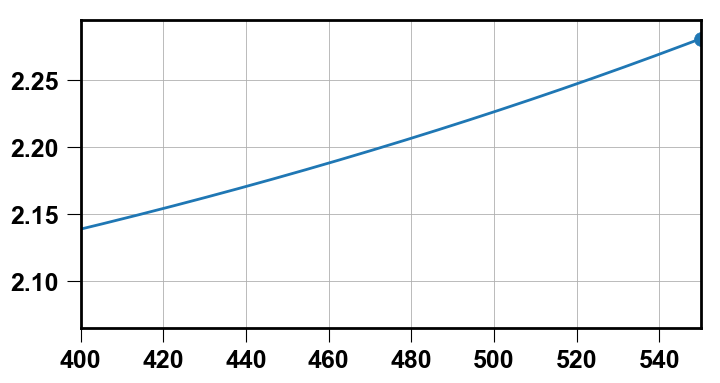

In [208]:
fig=plt.figure(figsize=(8,4))
ax1=fig.add_subplot(111)
ax1.plot(wl1,K)
ax1.scatter([mywl],[Kmywl],marker="o")
ax1.set_xlim(400,550)

In [196]:
Kmywl

2.1390853911888397

In [197]:
a2/a1*Kmywl

array([0.81490114])

Text(0.5,1.02,'Spectra per pixel : Separamtion order 1 and order 2 and ratio :HD205905 : 20170608 : FGB37 Thor300 ')

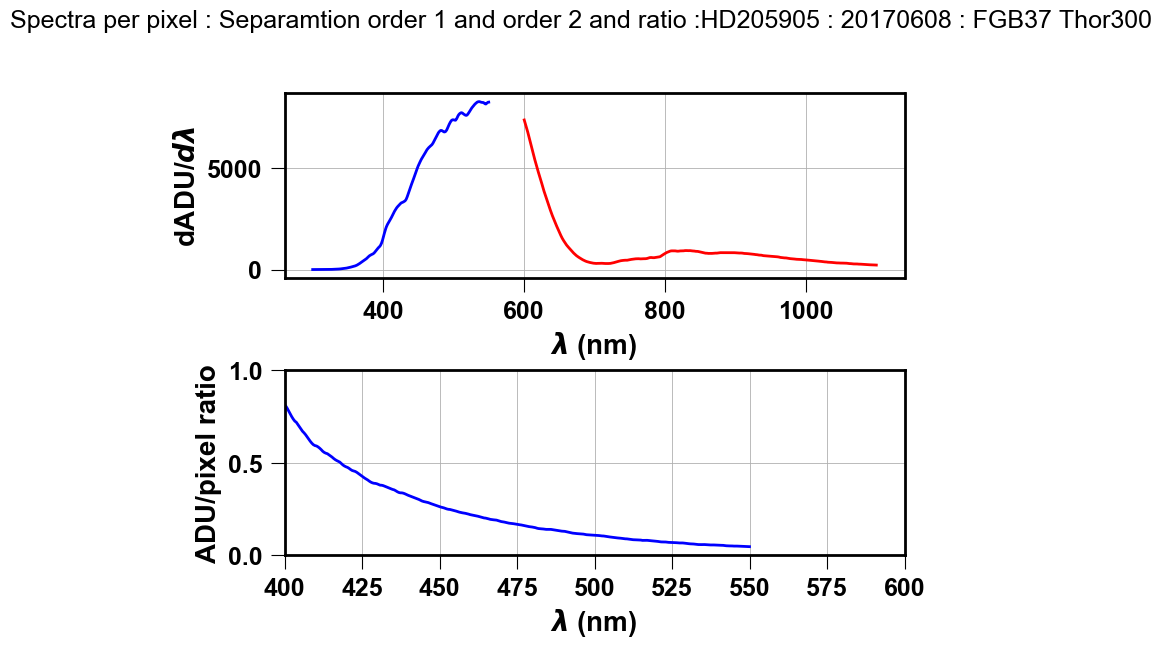

In [211]:
fig=plt.figure(figsize=(8,6))
ax1=fig.add_subplot(211)

i1=o1*Dispersion_Rate2(wl1*nm_to_micr,a,D,p=1)/Det_xpic*1e-3 

ax1.plot(wl1,i1,"b-")


ax1.plot(wl2,o2,"r-")
ax1.set_xlabel("$\lambda$ (nm) ")
ax1.set_ylabel("dADU/$d \\lambda$")

ax2=fig.add_subplot(212)

ax2.plot(wl1,r0*Kratio,"b-")
ax2.set_ylim(0,1)
ax2.set_xlim(400,600)
ax2.set_xlabel("$\lambda$ (nm) ")
ax2.set_ylabel("ADU/pixel ratio")

title="Spectra per pixel : Separamtion order 1 and order 2 and ratio :{} : {} : {} ".format(object_name,date,Select_Filt[sel])
plt.suptitle(title,Y=1.02,fontsize=18)

In [44]:
def FullPagePlotContaminationinPDF(wavelength,all_spectrum,all_interpol_f,all_disperser,dir_top_img,figname):
    """
    old
    """
    # filename
    figfilename=os.path.join(dir_top_img,figname)
    selected_index=np.array([2,5,0,1,8])
    title="obj : {}, date {}, filter FGB37".format(object_name,date)
    
    f, axarr  = plt.subplots(5, 2,figsize=(20,30))
    f.suptitle(title,size=20)
    
    for idx in range(5):
        sel=selected_index[idx]
        spec=all_spectrum[sel]
        interp=all_interpol_f[sel]
        wl,r=GiveContamination(wavelength,spec,interp)
        smooth_r=smooth(r,window_len=21)
        axarr[idx,0].plot(wavelength,spec,'b-',lw=2)
        axarr[idx,0].set_xlabel("$\lambda$ (nm)")
        axarr[idx,0].set_ylabel(" $Y(\lambda)$ (ADU)")
        thetitle="spectrum ({})".format(all_disperser[sel])
        axarr[idx,0].set_title(thetitle,fontsize=16)
    
        axarr[idx,1].plot(wl,smooth_r,'b-',lw=2)
        axarr[idx,1].set_xlabel("$\lambda$ (nm)")
        axarr[idx,1].set_ylabel("ADU")
        thetitle="spectrum ratio ({})".format(all_disperser[sel])
        axarr[idx,1].set_title(thetitle,fontsize=16)
        axarr[idx,1].set_xlabel("$\lambda$ (nm)")
        axarr[idx,1].set_ylabel("$Y(\lambda / Y(\lambda /2)$)")
        axarr[idx,1].set_ylim(0.,0.3)
        axarr[idx,1].set_xlim(800.,1100.)
    

    
    f.savefig(figfilename)

In [45]:
def FullPagePlotContaminationinPDF2(wavelength,all_spectrum,all_interpol_f,all_disperser,dir_top_img,figname):
    """
    old
    """
    # filename
    figfilename=os.path.join(dir_top_img,figname)
    selected_index=np.array([2,5,0,1,8])
    pencil=['r-','b-','g-','c-','m-']
    title="obj : {}, date {}, filter FGB37".format(object_name,date)
    
    f, axarr  = plt.subplots(1, 2,figsize=(20,5))
    f.suptitle(title,size=20)
    
    for idx in range(5):
        sel=selected_index[idx]
        spec=all_spectrum[sel]
        interp=all_interpol_f[sel]
        thelabel=all_disperser[sel]
        wl,r=GiveContamination(wavelength,spec,interp)
        smooth_r=smooth(r,window_len=21)
        if idx==2:
            axarr[0].plot(wavelength,spec,pencil[idx],lw=2,label=thelabel)
            axarr[0].set_xlabel("$\lambda$ (nm)")
            axarr[0].set_ylabel(" $Y(\lambda)$ (ADU)")
            axarr[0].legend(loc=1)
            thetitle="spectrum ({})".format(all_disperser[sel])
            axarr[0].set_title(thetitle,fontsize=16)
    
        axarr[1].plot(wl/2.,smooth_r,pencil[idx],label=thelabel,lw=2)
        axarr[1].set_xlabel("$\lambda$ (nm)")
        axarr[1].set_ylabel("ADU")
        thetitle="spectrum ratio"
        axarr[1].set_title(thetitle,fontsize=16)
        axarr[1].set_xlabel("$\lambda$ (nm)")
        axarr[1].set_ylabel("$Y(\lambda / Y(\lambda /2)$)")
        axarr[1].set_ylim(0.,0.5)
        axarr[1].set_xlim(400.,550.)
        axarr[1].legend(loc=1)
    

    
    f.savefig(figfilename)

In [46]:
def FullPagePlotContaminationinPDF2withRonchi400(wavelength,all_spectrum,all_interpol_f,all_disperser,dir_top_img,figname,wl0,r0):
    """
    (old)
    """
    # filename
    figfilename=os.path.join(dir_top_img,figname)
    selected_index=np.array([2,5,0,1,8])
    pencil=['r-','b-','g-','c-','m-']
    title="obj : {}, date {}, filter FGB37".format(object_name,date)
    
    f, axarr  = plt.subplots(1, 2,figsize=(20,5))
    f.suptitle(title,size=20)
    
    for idx in range(5):
        sel=selected_index[idx]
        spec=all_spectrum[sel]
        interp=all_interpol_f[sel]
        thelabel=all_disperser[sel]
        wl,r=GiveContamination(wavelength,spec,interp)
        smooth_r=smooth(r,window_len=21)
        if idx==2:
            axarr[0].plot(wavelength,spec,pencil[idx],lw=2,label=thelabel)
            axarr[0].set_xlabel("$\lambda$ (nm)")
            axarr[0].set_ylabel(" $Y(\lambda)$ (ADU)")
            axarr[0].legend(loc=1)
            thetitle="spectrum ({})".format(all_disperser[sel])
            axarr[0].set_title(thetitle,fontsize=16)
        if idx!=4:
            axarr[1].plot(wl/2.,smooth_r,pencil[idx],label=thelabel,lw=2)
            axarr[1].set_xlabel("$\lambda$ (nm)")
            axarr[1].set_ylabel("ADU")
            thetitle="spectrum ratio"
            axarr[1].set_title(thetitle,fontsize=16)
            axarr[1].set_xlabel("$\lambda$ (nm)")
            axarr[1].set_ylabel("$Y(\lambda / Y(\lambda /2)$)")
            axarr[1].set_ylim(0.,0.5)
            axarr[1].set_xlim(400.,550.)
            axarr[1].legend(loc=1)
    
    smooth_r0=smooth(r,window_len=21)
    axarr[1].plot(wl0/2.,smooth_r0,'k-',label='Ron400',lw=2)
    axarr[1].set_xlabel("$\lambda$ (nm)")
    axarr[1].set_ylabel("ADU")
    thetitle="spectrum ratio"
    axarr[1].set_title(thetitle,fontsize=16)
    axarr[1].set_xlabel("$\lambda$ (nm)")
    axarr[1].set_ylabel("$Y(\lambda / Y(\lambda /2)$)")
    axarr[1].set_ylim(0.,0.5)
    axarr[1].set_xlim(400.,550.)
    axarr[1].legend(loc=1)

    
    f.savefig(figfilename)

In [47]:
def FullPagePlotContaminationinPDF2withRonchi400_NoPhP(wavelength,all_spectrum,all_interpol_f,all_disperser,dir_top_img,figname,wl0,r0):
    """
    (old)
    """
    # filename
    figfilename=os.path.join(dir_top_img,figname)
    selected_index=np.array([2,5,0,1,8])
    pencil=['r-','b-','g-','c-','k-']
    title="obj : {}, date {}, filter FGB37".format(object_name,date)
    
    f, axarr  = plt.subplots(1, 2,figsize=(20,8))
    f.suptitle(title,size=20)
    plt.rc('legend',fontsize=20) # using a size in points
    
    
    for idx in range(5):
        sel=selected_index[idx]
        spec=all_spectrum[sel]
        interp=all_interpol_f[sel]
        thelabel=all_disperser[sel]
        wl,r=GiveContamination(wavelength,spec,interp)
        smooth_r=smooth(r,window_len=21)
        
        #print(idx,",",thelabel)
        
        if idx!=1  :
            axarr[0].plot(wavelength,spec,pencil[idx],lw=2,label=thelabel)
            axarr[0].set_xlabel("$\lambda$ (nm)")
            axarr[0].set_ylabel(" $Y(\lambda)$ (ADU)")
            axarr[0].legend(loc=1)
            thetitle="spectrum"
            axarr[0].set_title(thetitle,fontsize=20)
            axarr[0].set_ylim(0,2500)
        if idx!=1:
            axarr[1].plot(wl/2.,smooth_r,pencil[idx],label=thelabel,lw=2)
            axarr[1].set_xlabel("$\lambda$ (nm)")
            axarr[1].set_ylabel("ADU")
            thetitle="spectrum ratio : order 2/order 1"
            axarr[1].set_title(thetitle,fontsize=20)
            axarr[1].set_xlabel("$\lambda$ (nm)")
            axarr[1].set_ylabel("$Y(\lambda / Y(\lambda /2)$)")
            axarr[1].set_ylim(0.,0.5)
            axarr[1].set_xlim(400.,550.)
            axarr[1].legend(loc=1)
    
    #smooth_r0=smooth(r,window_len=21)
    #axarr[1].plot(wl0/2.,smooth_r0,'k-',label='Ron400',lw=2)
    axarr[1].set_xlabel("$\lambda$ (nm)")
    axarr[1].set_ylabel("ADU")
    thetitle="spectrum ratio : order 2/order 1"
    axarr[1].set_title(thetitle,fontsize=20)
    axarr[1].set_xlabel("$\lambda$ (nm)")
    axarr[1].set_ylabel("$Y(\lambda / Y(\lambda /2)$)")
    axarr[1].set_ylim(0.,0.5)
    axarr[1].set_xlim(400.,550.)
    axarr[1].legend(loc=1)

    plt.tight_layout()
    f.savefig(figfilename)

In [48]:
def FullPagePlotContaminationinPDF2withRonchi400_NoPhP3(wavelength,all_spectrum,all_interpol_f,all_disperser,dir_top_img,figname,wl0,r0):
    """
     For Article HoloSpec version 1 (old)
    """
    # filename
    figfilename=os.path.join(dir_top_img,figname)
    selected_index=np.array([2,5,0,1,8])
    pencil=['r-','b-','g-','c-','k-']
    title="obj : {}, date {}, filter FGB37".format(object_name,date)
    
    f, axarr  = plt.subplots(2, 1,figsize=(8,8))
    f.suptitle(title,size=20,y=1.05)
    plt.rc('legend',fontsize=20) # using a size in points
    
    
    for idx in range(5):
        sel=selected_index[idx]
        spec=all_spectrum[sel]
        interp=all_interpol_f[sel]
        thelabel=all_disperser[sel]
        wl,r=GiveContamination(wavelength,spec,interp)
        smooth_r=smooth(r,window_len=21)
        
        #print(idx,",",thelabel)
        if thelabel=="Thor300":
            thelabel="Thorlabs blazed 300 lines/mm"
        elif thelabel=='HoloPhAg':
            thelabel='Argentic phase hologram'
        elif thelabel=='HoloAmAg':
            thelabel='Argentic amplitude hologram'
        elif thelabel=="Ron200":
            thelabel='Ronchi 200 lines/mm'
            
           
        
        if idx!=1  :
            axarr[0].plot(wavelength,spec,pencil[idx],lw=2,label=thelabel)
            axarr[0].set_xlabel("$\lambda$ (nm)",fontweight='bold')
            axarr[0].set_ylabel(" $Y(\lambda)$ (ADU)",fontweight='bold')
            axarr[0].legend(loc=1,prop={'size': 15})
            thetitle="spectrum"
            axarr[0].set_title(thetitle,fontsize=20,fontweight='bold')
            axarr[0].set_ylim(0,2500)
        if idx!=1:
            axarr[1].plot(wl/2.,smooth_r,pencil[idx],label=thelabel,lw=2)
            axarr[1].set_xlabel("$\lambda$ (nm)",fontweight='bold')
            axarr[1].set_ylabel("ADU",fontweight='bold')
            thetitle="spectrum ratio : order 2/order 1"
            axarr[1].set_title(thetitle,fontsize=20,fontweight='bold')
            axarr[1].set_xlabel("$\lambda$ (nm)",fontweight='bold')
            axarr[1].set_ylabel("$Y(\lambda / Y(\lambda /2)$)",fontweight='bold')
            axarr[1].set_ylim(0.,0.5)
            axarr[1].set_xlim(400.,550.)
            axarr[1].legend(loc=1,prop={'size': 15})
    
    #smooth_r0=smooth(r,window_len=21)
    #axarr[1].plot(wl0/2.,smooth_r0,'k-',label='Ron400',lw=2)
    axarr[1].set_xlabel("$\lambda$ (nm)",fontweight='bold')
    axarr[1].set_ylabel("ADU",fontweight='bold')
    thetitle="spectrum ratio : order 2/order 1"
    axarr[1].set_title(thetitle,fontsize=20,fontweight='bold')
    axarr[1].set_xlabel("$\lambda$ (nm)",fontweight='bold')
    axarr[1].set_ylabel("$Y(\lambda / Y(\lambda /2)$)",fontweight='bold')
    axarr[1].set_ylim(0.,0.5)
    axarr[1].set_xlim(400.,550.)
    axarr[1].legend(loc=1,prop={'size': 15})
    
    from matplotlib.ticker import ScalarFormatter
    from matplotlib.ticker import FuncFormatter
    
    formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
    
    for axis in [axarr[0].xaxis,  axarr[0].yaxis]:
        formatter = ScalarFormatter()
        formatter.set_scientific(False)
        axis.set_major_formatter(formatter)
    for axis in [axarr[1].xaxis,  axarr[1].yaxis]:
        #formatter = ScalarFormatter()
        #formatter.set_scientific(False)
        formatter = FuncFormatter(lambda y, _: '{:.0f}'.format(y))
        axis.set_major_formatter(formatter)
        axis.set_minor_formatter(formatter)

    #axarr[1].xaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    #axarr[1].xaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))
    #axarr[1].xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #axarr[1].xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))



    plt.tight_layout()
    f.savefig(figfilename)

In [49]:
def FullPagePlotContaminationinPDF2withRonchi400_NoPhP4(wavelength,all_spectrum,all_interpol_f,all_disperser,dir_top_img,figname,wl0,r0):
    """
    *********************************
    * For Article HoloSpec V2  (old)*
    *********************************
    """
    # filename
    figfilename=os.path.join(dir_top_img,figname)
    selected_index=np.array([2,5,0,1,8])
    pencil=['r-','b-','g-','c-','k-']
    title="obj : {}, date {}, filter FGB37".format(object_name,date)
    
    f, axarr  = plt.subplots(2, 1,figsize=(8,8))
    f.suptitle(title,size=20,y=1.05)
    plt.rc('legend',fontsize=20) # using a size in points
    
    wl_halpha=656.281 # in nm
    C_HoloPhAg_halpha=0.43 
    C_HoloAmAg_halpha=0.25
    C_HoloPhAg_halpha=0.43 
    C_Thorlab_halpha=0.006
    
    for idx in range(5):
        sel=selected_index[idx]
        spec=all_spectrum[sel]
        interp=all_interpol_f[sel]
        thelabel=all_disperser[sel]
        wl,r=GiveContamination(wavelength,spec,interp)
        smooth_r=2.*smooth(r,window_len=21)  # multiply by 2 to take into account wavelength scale stretching at order 2
        
        #print(idx,",",thelabel)
        if thelabel=="Thor300":
            thelabel="Thorlabs blazed 300 lines/mm"
        elif thelabel=='HoloPhAg':
            thelabel='Argentic phase hologram'
        elif thelabel=='HoloAmAg':
            thelabel='Argentic amplitude hologram'
        elif thelabel=="Ron200":
            thelabel='Ronchi 200 lines/mm'
            
           
        
        if idx!=1  :
            axarr[0].plot(wavelength,spec,pencil[idx],lw=2,label=thelabel)
            axarr[0].set_xlabel("$\lambda$ (nm) (order 1)",fontweight='bold')
            axarr[0].set_ylabel(" $Y(\lambda)$ (ADU)",fontweight='bold')
            axarr[0].legend(loc=1,prop={'size': 12})
            thetitle="spectrum"
            axarr[0].set_title(thetitle,fontsize=20,fontweight='bold')
            axarr[0].set_ylim(0,2500)
            axarr[0].set_xlim(300,1100)
            axarr[0].grid(False)
        if idx!=1:
            axarr[1].plot(wl/2.,smooth_r,pencil[idx],label=thelabel,lw=2)
            axarr[1].set_xlabel("$\lambda$ (nm)",fontweight='bold')
            axarr[1].set_ylabel("ADU",fontweight='bold')
            thetitle="spectrum ratio : order 2/order 1"
            #axarr[1].set_title(thetitle,fontsize=20,fontweight='bold')
            axarr[1].set_xlabel("$\lambda$ (nm)",fontweight='bold')
            #axarr[1].set_ylabel("$Y(\lambda / Y(\lambda /2)$)",fontweight='bold')
            axarr[1].set_ylabel("$Y(2\lambda / Y(\lambda)$)",fontweight='bold')
            axarr[1].set_ylim(0.,0.5)
            axarr[1].set_xlim(400.,550.)
            axarr[1].legend(loc=1,prop={'size': 12})
            axarr[1].grid(False)
    
    #smooth_r0=smooth(r,window_len=21)
    #axarr[1].plot(wl0/2.,smooth_r0,'k-',label='Ron400',lw=2)
    
    ax1 = axarr[0].twiny()  # instantiate a second axes that shares the same y-axis
    ax1.xaxis.set_ticks_position("bottom")
    ax1.xaxis.set_label_position("bottom")
    # Offset the twin axis below the host
    ax1.spines["bottom"].set_position(("axes", -0.40))

    ax1.set_xlim(150.,550.)
    ax1.set_ylim(0.,2500)
    ax1.set_xlabel("$\lambda$ (nm) (order 2)",fontweight='bold')
    
    
    
    axarr[1].scatter([wl_halpha],[C_HoloPhAg_halpha],marker="+",color="g",s=100)
    axarr[1].scatter([wl_halpha],[C_HoloAmAg_halpha],marker="+",color="c",s=100)
    axarr[1].scatter([wl_halpha],[C_Thorlab_halpha],marker="+",color="r",s=100)
    
    
    axarr[1].set_xlabel("$\lambda$ (nm)",fontweight='bold')
    axarr[1].set_ylabel("ADU",fontweight='bold')
    thetitle="spectrum ratio : order 2/order 1"
    axarr[1].set_title(thetitle,fontsize=20,fontweight='bold')
    axarr[1].set_xlabel("$\lambda$ (nm) (order 1)",fontweight='bold')
    #axarr[1].set_ylabel("$Y(\lambda / Y(\lambda /2)$)",fontweight='bold')
    axarr[1].set_ylabel("$Y(2\lambda / Y(\lambda)$)",fontweight='bold')
    axarr[1].set_ylim(0.,1.0)
    axarr[1].set_xlim(400.,700.)
    axarr[1].legend(loc=2,prop={'size': 12})
    #axarr[1].set_xscale("log")
    
    
    #ax2 = axarr[1].twinx()  # instantiate a second axes that shares the same x-axis
    #ax2.scatter([wl_halpha],[C_HoloPhAg_halpha],marker="+",color="g",s=100,label="$H_\\alpha$ filt. (PhAg)")
    #ax2.scatter([wl_halpha],[C_HoloAmAg_halpha],marker="+",color="c",s=100,label="$H_\\alpha$ filt. (AmAg)")
 
    ax2 = axarr[1].twinx()  # instantiate a second axes that shares the same x-axis
    #ax2.xaxis.set_ticks_position("bottom")
    #ax2.xaxis.set_label_position("bottom")
    # Offset the twin axis below the host
    #ax2.spines["bottom"].set_position(("axes", 0.5))

    ax2.set_xlim(400.,700.)
    ax2.set_ylim(0.,1.0)
    ax2.tick_params(labelright=False, length=0, width=0)
    
    ax2.scatter([wl_halpha],[C_HoloPhAg_halpha],marker="+",color="g",s=100,label="$H_\\alpha$ filt. (PhAg)")
    ax2.scatter([wl_halpha],[C_HoloAmAg_halpha],marker="+",color="c",s=100,label="$H_\\alpha$ filt. (AmAg)")
    ax2.scatter([wl_halpha],[C_Thorlab_halpha],marker="+",color="r",s=100,label="$H_\\alpha$ filt. (Blazed)")
    
   
    #ax2.set_xlabel("$\lambda$ (nm) (order 2)",fontweight='bold')
    ax2.legend(loc=1,prop={'size': 12})
    ax2.grid(False)

    
    from matplotlib.ticker import ScalarFormatter
    from matplotlib.ticker import FuncFormatter
    
    #formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
    
    #for axis in [axarr[0].xaxis,  axarr[0].yaxis]:
    #    formatter = ScalarFormatter()
    #    formatter.set_scientific(False)
    #    axis.set_major_formatter(formatter)
    #for axis in [axarr[1].xaxis,  axarr[1].yaxis]:
        #formatter = ScalarFormatter()
        #formatter.set_scientific(False)
    #    formatter = FuncFormatter(lambda y, _: '{:.0f}'.format(y))
    #    axis.set_major_formatter(formatter)
    #    axis.set_minor_formatter(formatter)

    axarr[1].xaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    axarr[1].xaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))
    axarr[1].xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axarr[1].xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))
    # make some labels invisible
    #axarr[1].xaxis.set_tick_params(labelbottom=False)
    #axarr[1].set_xticks([400, 500, 600,700])
    #axarr[1].get_xaxis().get_major_formatter().labelOnlyBase = False
    
    
    plt.tight_layout()
    f.savefig(figfilename)

In [50]:
def FullPagePlotContaminationinPDF2withRonchi400_NoPhP_2(wavelength,all_spectrum,all_interpol_f,all_disperser,dir_top_img,figname,wl0,r0):
    """
    old 
    """
    # filename
    figfilename=os.path.join(dir_top_img,figname)
    selected_index=np.array([2,5,0,1,8])
    pencil=['r-','b-','g-','c-','m-']
    title="obj : {}, date {}, filter FGB37".format(object_name,date)
    
    f, axarr  = plt.subplots(1, 2,figsize=(20,6))
    f.suptitle(title,size=20)
    plt.rc('legend',fontsize=20) # using a size in points
    
    for idx in range(5):
        sel=selected_index[idx]
        spec=all_spectrum[sel]
        interp=all_interpol_f[sel]
        thelabel=all_disperser[sel]
        wl,r=GiveContamination(wavelength,spec,interp)
        smooth_r=smooth(r,window_len=21)
        
        print(idx,",",thelabel)
        
        if idx==3:
            axarr[0].plot(wavelength,spec,pencil[idx],lw=2,label=thelabel)
            axarr[0].set_xlabel("$\lambda$ (nm)")
            axarr[0].set_ylabel(" $Y(\lambda)$ (ADU)")
            axarr[0].legend(loc=1)
            thetitle="spectrum ({})".format(all_disperser[sel])
            axarr[0].set_title(thetitle,fontsize=20)
        if idx!=1 and idx!= 4:
            axarr[1].plot(wl/2.,smooth_r,pencil[idx],label=thelabel,lw=2)
            axarr[1].set_xlabel("$\lambda$ (nm)")
            axarr[1].set_ylabel("ADU")
            thetitle="spectrum ratio"
            #axarr[1].set_title(thetitle,fontsize=20)
            axarr[1].set_xlabel("$\lambda$ (nm)")
            axarr[1].set_ylabel("$Y(\lambda / Y(\lambda /2)$)")
            axarr[1].set_ylim(0.,0.5)
            axarr[1].set_xlim(400.,550.)
            axarr[1].legend(loc=1)
    
    smooth_r0=smooth(r,window_len=21)
    axarr[1].plot(wl0/2.,smooth_r0,'k-',label='Ron400',lw=2)
    axarr[1].set_xlabel("$\lambda$ (nm)")
    axarr[1].set_ylabel("ADU")
    thetitle="spectrum ratio"
    axarr[1].set_title(thetitle,fontsize=20)
    axarr[1].set_xlabel("$\lambda$ (nm)")
    axarr[1].set_ylabel("$Y(\lambda / Y(\lambda /2)$)")
    axarr[1].set_ylim(0.,0.5)
    axarr[1].set_xlim(400.,550.)
    axarr[1].legend(loc=1)
    
    
    plt.tight_layout()
    f.savefig(figfilename)

In [51]:
def FullPagePlotContaminationinPDF2withRonchi400_NoPhP5(wavelength,all_spectrum,all_interpol_f,all_disperser,dir_top_img,figname,wl0,r0):
    """
    For Article HoloSpec V3 (old)
    """
    
    FLAG_VSCALE_LOG1=True
    FLAG_VSCALE_LOG2=False
    
    # filename
    figfilename=os.path.join(dir_top_img,figname)
    selected_index=np.array([2,5,0,1,8])
    pencil=['r-','b-','g-','c-','k-']
    pencil2=['r:','b:','g:','c:','k:']
    title="obj : {}, date {}, filter FGB37".format(object_name,date)
    
    f, axarr  = plt.subplots(2, 1,figsize=(8,9))
    f.suptitle(title,size=20,y=1.05)
    plt.rc('legend',fontsize=20) # using a size in points
    
    wl_halpha=656.281 # in nm
    C_HoloPhAg_halpha=0.43 
    C_HoloAmAg_halpha=0.25
    C_Thorlab_halpha=0.006
    #C_Thorlab_halpha=0.06
    
    D=58*mm_to_micr   # distance Disperser-CCD in microns
    
    
    for idx in range(5):
        sel=selected_index[idx]
        thelabel=all_disperser[sel] # disperser name
        
      
        if thelabel=="Thor300":
            thelabel="Thorlabs blazed 300 lines/mm"
            thea=1./300.*mm_to_micr
        elif thelabel=='HoloPhAg':
            thelabel='Argentic phase hologram'
            thea=1./350.*mm_to_micr
        elif thelabel=='HoloAmAg':
            thelabel='Argentic amplitude hologram'
            thea=1./350.*mm_to_micr
        elif thelabel=="Ron200":
            thelabel='Ronchi 200 lines/mm'
            thea=1./200.*mm_to_micr
        
        # dispersion rate dx/dlambda where dx is in pixel unit
        dxperdlambda=Dispersion_Rate(wavelength*nm_to_micr,thea,D)/Det_xpic*1e-3   # in pixel per nm
        dxperdlambda2=Dispersion_Rate2(wavelength*nm_to_micr,thea,D)/Det_xpic*1e-3   # in pixel per nm
        
        
        print(idx,", disperser = ",thelabel," dx/dlambda (pix/nm)= ", dxperdlambda[0]," wavelength = ",wavelength[0] )
        
        
        spec=all_spectrum[sel]       # get the spectrom
        interp=all_interpol_f[sel]   # get some interpolation
       
        wl,r=GiveContamination(wavelength,spec,interp)  # compute the  contamination
        
        #print("len(wl)",wl.shape," len(r)=",r.shape)
        #print("wl=",wl)
        
        
        # adapt ratio to show the density in wavelength
        rateratio=Dispersion_Rate2(WL*nm_to_micr,a,D,p=2)/Dispersion_Rate2(WL*nm_to_micr,a,D,p=1)# multiply by 2 to take into account wavelength scale stretching at order 2
        
        
        func_rateratio=interpolate.interp1d(WL,rateratio)
        
        
        r=r*func_rateratio(wl/2)
        
        # smoothing for plotting
        smooth_r=smooth(r,window_len=21) 
        
        
        ######################    
        # Top panel figure
        #######################
        
        if idx!=1  :
            axarr[0].plot(wavelength,spec,pencil[idx],lw=2,label=thelabel)
            axarr[0].set_xlabel("$\lambda$ (nm) (order 1)",fontweight='bold')
            axarr[0].set_ylabel("$dF/dx$ (ADU/24$\mu$m)",fontweight='bold')
            axarr[0].legend(loc=1,prop={'size': 12})
            thetitle="spectrum"
            axarr[0].set_title(thetitle,fontsize=20,fontweight='bold')
           
            axarr[0].set_xlim(300,1100)
            axarr[0].grid(False)
            
            if FLAG_VSCALE_LOG1:
                axarr[0].set_yscale("log")
                axarr[0].set_ylim(10.,100000)
            else:
                axarr[0].set_ylim(0,2500)
            
        #########################    
        # bottom panel figure
        ########################
        
        if idx!=1:
            axarr[1].plot(wl/2.,smooth_r,pencil[idx],label=thelabel,lw=2)
            axarr[1].set_xlabel("$\lambda$ (nm)",fontweight='bold')
            axarr[1].set_ylabel("ADU",fontweight='bold')
            thetitle="spectrum ratio : order 2/order 1"
            #axarr[1].set_title(thetitle,fontsize=20,fontweight='bold')
            axarr[1].set_xlabel("$\lambda$ (nm)",fontweight='bold')
            #axarr[1].set_ylabel("$Y(\lambda / Y(\lambda /2)$)",fontweight='bold')
            axarr[1].set_ylabel("$Y(2\lambda / Y(\lambda)$)",fontweight='bold')
            #axarr[1].set_xlim(400.,550.)
            axarr[1].legend(loc=1,prop={'size': 12})
            axarr[1].grid(False)
    
    #smooth_r0=smooth(r,window_len=21)
    #axarr[1].plot(wl0/2.,smooth_r0,'k-',label='Ron400',lw=2)
    
    ax1 = axarr[0].twiny()  # instantiate a second axes that shares the same y-axis
    ax1.xaxis.set_ticks_position("bottom")
    ax1.xaxis.set_label_position("bottom")
    # Offset the twin axis below the host
    ax1.spines["bottom"].set_position(("axes", -0.40))

    ax1.set_xlim(150.,550.)
    
    if FLAG_VSCALE_LOG1:
            ax1.set_yscale("log")
            ax1.set_ylim(10.,100000)
    else:
        ax1.set_ylim(0.,2500)
        
    ax1.set_xlabel("$\lambda$ (nm) (order 2)",fontweight='bold')
    
    
    
    axarr[1].scatter([wl_halpha],[C_HoloPhAg_halpha],marker="+",color="g",s=100)
    axarr[1].scatter([wl_halpha],[C_HoloAmAg_halpha],marker="+",color="c",s=100)
    axarr[1].scatter([wl_halpha],[C_Thorlab_halpha],marker="+",color="r",s=100)
    
    
    axarr[1].set_xlabel("$\lambda$ (nm)",fontweight='bold')
    axarr[1].set_ylabel("ADU",fontweight='bold')
    thetitle="spectrum ratio : order 2/order 1"
    axarr[1].set_title(thetitle,fontsize=20,fontweight='bold')
    axarr[1].set_xlabel("$\lambda$ (nm) (order 1)",fontweight='bold')
    #axarr[1].set_ylabel("$Y(\lambda / Y(\lambda /2)$)",fontweight='bold')
    axarr[1].set_ylabel("$Y(2\lambda / Y(\lambda)$",fontweight='bold')
    if FLAG_VSCALE_LOG2:
        axarr[1].set_ylim(0.005,200.0)
        axarr[1].set_yscale("log")
    else:
        axarr[1].set_ylim(0.,1.2)
        
    axarr[1].set_xlim(400.,700.)
    axarr[1].legend(loc=2,prop={'size': 12})
    #axarr[1].set_xscale("log")
    
    
    #ax2 = axarr[1].twinx()  # instantiate a second axes that shares the same x-axis
    #ax2.scatter([wl_halpha],[C_HoloPhAg_halpha],marker="+",color="g",s=100,label="$H_\\alpha$ filt. (PhAg)")
    #ax2.scatter([wl_halpha],[C_HoloAmAg_halpha],marker="+",color="c",s=100,label="$H_\\alpha$ filt. (AmAg)")
 
    ax2 = axarr[1].twinx()  # instantiate a second axes that shares the same x-axis
    #ax2.xaxis.set_ticks_position("bottom")
    #ax2.xaxis.set_label_position("bottom")
    # Offset the twin axis below the host
    #ax2.spines["bottom"].set_position(("axes", 0.5))

     
    ax2.set_xlim(400.,700.)
    
    if FLAG_VSCALE_LOG2:
        ax2.set_ylim(0.005,200.0)
        ax2.set_yscale("log")
    else:
        ax2.set_ylim(0.,1.2)
    
    
    ax2.tick_params(labelright=False, length=0, width=0)
    
    
    #C_HoloPhAg_halpha=0.43 
    #C_HoloAmAg_halpha=0.25
    #C_Thorlab_halpha=0.006
    
    ax2.scatter([wl_halpha],[C_HoloPhAg_halpha],marker="+",color="g",s=100,label="$H_\\alpha$ filt. (PhAg)")
    ax2.scatter([wl_halpha],[C_HoloAmAg_halpha],marker="+",color="c",s=100,label="$H_\\alpha$ filt. (AmAg)")
    ax2.scatter([wl_halpha],[C_Thorlab_halpha],marker="+",color="r",s=100,label="$H_\\alpha$ filt. (Blazed)")
    
    
    
   
    #ax2.set_xlabel("$\lambda$ (nm) (order 2)",fontweight='bold')
    ax2.legend(loc=1,prop={'size': 12})
    ax2.grid(False)

    
    from matplotlib.ticker import ScalarFormatter
    from matplotlib.ticker import FuncFormatter
    
    #formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
    
    #for axis in [axarr[0].xaxis,  axarr[0].yaxis]:
    #    formatter = ScalarFormatter()
    #    formatter.set_scientific(False)
    #    axis.set_major_formatter(formatter)
    #for axis in [axarr[1].xaxis,  axarr[1].yaxis]:
        #formatter = ScalarFormatter()
        #formatter.set_scientific(False)
    #    formatter = FuncFormatter(lambda y, _: '{:.0f}'.format(y))
    #    axis.set_major_formatter(formatter)
    #    axis.set_minor_formatter(formatter)

    axarr[1].xaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    axarr[1].xaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))
    axarr[1].xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axarr[1].xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))
    # make some labels invisible
    #axarr[1].xaxis.set_tick_params(labelbottom=False)
    #axarr[1].set_xticks([400, 500, 600,700])
    #axarr[1].get_xaxis().get_major_formatter().labelOnlyBase = False
    
    
    plt.tight_layout()
    f.savefig(figfilename)

In [52]:
def FullPagePlotContaminationinPDF2withRonchi400_NoPhP6(wavelength,all_spectrum,all_interpol_f,all_disperser,dir_top_img,figname,wl0,r0):
    """
    For Article HoloSpec V4 (old)
    
    Show with respect to pixels
    """
    
    FLAG_VSCALE_LOG1=True
    FLAG_VSCALE_LOG2=False
    FLAG_SHOW_ORDER2=True
    
    # filename
    figfilename=os.path.join(dir_top_img,figname)
    selected_index=np.array([2,5,0,1,8])
    pencil=['r-','b-','g-','c-','k-']
    pencil2=['r:','b:','g:','c:','k:']
    title="obj : {}, date {}, filter FGB37".format(object_name,date)
    
    f, axarr  = plt.subplots(2, 1,figsize=(8,9))
    f.suptitle(title,size=20,y=1.05)
    plt.rc('legend',fontsize=20) # using a size in points
    
    wl_halpha=656.281 # in nm
    C_HoloPhAg_halpha=0.43 
    C_HoloAmAg_halpha=0.25
    C_Thorlab_halpha=0.006
    #C_Thorlab_halpha=0.06
    
    D=58*mm_to_micr   # distance Disperser-CCD in microns
    
    
    for idx in range(5):
        sel=selected_index[idx]
        thelabel=all_disperser[sel] # disperser name
        
      
        if thelabel=="Thor300":
            thelabel="Thorlabs blazed 300 lines/mm"
            thea=1./300.*mm_to_micr
        elif thelabel=='HoloPhAg':
            thelabel='Argentic phase hologram'
            thea=1./350.*mm_to_micr
        elif thelabel=='HoloAmAg':
            thelabel='Argentic amplitude hologram'
            thea=1./350.*mm_to_micr
        elif thelabel=="Ron200":
            thelabel='Ronchi 200 lines/mm'
            thea=1./200.*mm_to_micr
         
        # compute dispersion in pixels
        theX=Dispersion(wavelength*nm_to_micr,thea,D)/Det_xpic     # in pixels
     
        
        # dispersion rate dx/dlambda where dx is in pixel unit
        dxperdlambda=Dispersion_Rate(wavelength*nm_to_micr,thea,D)/Det_xpic*1e-3   # in pixel per nm
        dxperdlambda2=Dispersion_Rate2(wavelength*nm_to_micr,thea,D)/Det_xpic*1e-3   # in pixel per nm
        
        factor_dxperdlambda=np.where(wavelength<700,Dispersion_Rate2(wavelength*nm_to_micr,thea,D,p=1)/Det_xpic*1e-3,Dispersion_Rate2(wavelength*nm_to_micr/2.,thea,D,p=2)/Det_xpic*1e-3)
        
        factor_dxperdlambda_2=np.where(wavelength<700,Dispersion_Rate2(wavelength*nm_to_micr,thea,D,p=1)/Det_xpic*1e-3,Dispersion_Rate2(wavelength*nm_to_micr/2.,thea,D,p=2)/Det_xpic*1e-3)
        factor_dxperdlambda_1=Dispersion_Rate2(wavelength*nm_to_micr,thea,D,p=1)/Det_xpic*1e-3
    
    
    
        print(idx,", disperser = ",thelabel," dx/dlambda (pix/nm)= ", dxperdlambda[0]," wavelength = ",wavelength[0] )
        
        
        spec=all_spectrum[sel]       # get the spectrum per pixel unit
        interp=all_interpol_f[sel]   # get some interpolation
        dFdLambda2=spec*factor_dxperdlambda_2   # spectrum per nm wavelength bin
        dFdLambda1=spec*factor_dxperdlambda_1   # spectrum per nm wavelength bin
       
        wl,r=GiveContamination(wavelength,spec,interp)  # compute the  contamination
        
        #print("len(wl)",wl.shape," len(r)=",r.shape)
        #print("wl=",wl)
        
        
        # adapt ratio to show the density in wavelength
        rateratio=Dispersion_Rate2(WL*nm_to_micr,a,D,p=2)/Dispersion_Rate2(WL*nm_to_micr,a,D,p=1)# multiply by 2 to take into account wavelength scale stretching at order 2
        
        
        func_rateratio=interpolate.interp1d(WL,rateratio)
        
        
        r=r*func_rateratio(wl/2)
        
        # smoothing for plotting
        smooth_r=smooth(r,window_len=21) 
        
        
        ######################    
        # Top panel figure
        #######################
        
        if idx!=1  :
        #if idx!=1  and idx!=4 :
            #axarr[0].plot(wavelength,spec,pencil[idx],lw=2,label=thelabel)
            #axarr[0].plot(theX,dFdLambda,pencil[idx],lw=2,label=thelabel)
            axarr[0].plot(wavelength,dFdLambda1,pencil[idx],lw=2,label=thelabel)
            if FLAG_SHOW_ORDER2:
                axarr[0].plot(wavelength,dFdLambda2,pencil2[idx],lw=0.5)
            axarr[0].set_xlabel("$\lambda$ (nm) (order 1)",fontweight='bold')
            #axarr[0].set_xlabel(" d($\lambda$) (pixel)",fontweight='bold')
            axarr[0].set_ylabel("$Y_1(\lambda)$ (ADU/nm)",fontweight='bold')
            axarr[0].legend(loc=1,prop={'size': 12})
            thetitle="spectrum"
            axarr[0].set_title(thetitle,fontsize=20,fontweight='bold')
           
            axarr[0].set_xlim(300,1100)
            axarr[0].grid(False)
            
            if FLAG_VSCALE_LOG1:
                axarr[0].set_yscale("log")
                axarr[0].set_ylim(10.,100000)
            else:
                axarr[0].set_ylim(0,2500)
            
        #########################    
        # bottom panel figure
        ########################
        
        if idx!=1:
        #if idx!=1  and idx!=4 :
            axarr[1].plot(wl/2.,smooth_r,pencil[idx],label=thelabel,lw=2)
            axarr[1].set_xlabel("$\lambda$ (nm)",fontweight='bold')
            axarr[1].set_ylabel("ADU",fontweight='bold')
            thetitle="spectrum ratio : order 2/order 1"
            #axarr[1].set_title(thetitle,fontsize=20,fontweight='bold')
            axarr[1].set_xlabel("$\lambda$ (nm)",fontweight='bold')
            #axarr[1].set_ylabel("$Y(\lambda / Y(\lambda /2)$)",fontweight='bold')
            #axarr[1].set_ylabel("$Y(2\lambda / Y(\lambda)$)",fontweight='bold')
            axarr[1].set_ylabel("$Y_2/Y_1(\lambda)$",fontweight='bold')
            #axarr[1].set_xlim(400.,550.)
            axarr[1].legend(loc=1,prop={'size': 12})
            axarr[1].grid(False)
    
    #smooth_r0=smooth(r,window_len=21)
    #axarr[1].plot(wl0/2.,smooth_r0,'k-',label='Ron400',lw=2)
    
    ax1 = axarr[0].twiny()  # instantiate a second axes that shares the same y-axis
    ax1.xaxis.set_ticks_position("bottom")
    ax1.xaxis.set_label_position("bottom")
    # Offset the twin axis below the host
    ax1.spines["bottom"].set_position(("axes", -0.3))

    ax1.set_xlim(150.,550.)
    ax1.grid(False)
    
    #if FLAG_VSCALE_LOG1:
    #        ax1.set_yscale("log")
    #        ax1.set_ylim(1.,50000)
    #else:
    #    ax1.set_ylim(0.,2500)
        
    ax1.set_xlabel("$\lambda$ (nm) (order 2)",fontweight='bold')
    
    
    
    axarr[1].scatter([wl_halpha],[C_HoloPhAg_halpha],marker="+",color="g",s=100)
    axarr[1].scatter([wl_halpha],[C_HoloAmAg_halpha],marker="+",color="c",s=100)
    axarr[1].scatter([wl_halpha],[C_Thorlab_halpha],marker="+",color="r",s=100)
    
    

    thetitle="spectrum ratio : order 2/order 1"
    axarr[1].set_title(thetitle,fontsize=20,fontweight='bold')
    axarr[1].set_xlabel("$\lambda$ (nm) (order 1)",fontweight='bold')
    #axarr[1].set_ylabel("$Y(\lambda / Y(\lambda /2)$)",fontweight='bold')
    axarr[1].set_ylabel("$Y_2/Y_1(\lambda)$",fontweight='bold')
    if FLAG_VSCALE_LOG2:
        axarr[1].set_ylim(0.005,200.0)
        axarr[1].set_yscale("log")
    else:
        axarr[1].set_ylim(0.,1.1)
        
    axarr[1].set_xlim(400.,700.)
    axarr[1].legend(loc=2,prop={'size': 12})
    #axarr[1].set_xscale("log")
    
    
    #ax2 = axarr[1].twinx()  # instantiate a second axes that shares the same x-axis
    #ax2.scatter([wl_halpha],[C_HoloPhAg_halpha],marker="+",color="g",s=100,label="$H_\\alpha$ filt. (PhAg)")
    #ax2.scatter([wl_halpha],[C_HoloAmAg_halpha],marker="+",color="c",s=100,label="$H_\\alpha$ filt. (AmAg)")
 
    ax2 = axarr[1].twinx()  # instantiate a second axes that shares the same x-axis
    #ax2.xaxis.set_ticks_position("bottom")
    #ax2.xaxis.set_label_position("bottom")
    # Offset the twin axis below the host
    #ax2.spines["bottom"].set_position(("axes", 0.5))

     
    ax2.set_xlim(400.,700.)
    
    if FLAG_VSCALE_LOG2:
        ax2.set_ylim(0.005,200.0)
        ax2.set_yscale("log")
    else:
        ax2.set_ylim(0.,1.1)
    
    
    ax2.tick_params(labelright=False, length=0, width=0)
    
    
    #C_HoloPhAg_halpha=0.43 
    #C_HoloAmAg_halpha=0.25
    #C_Thorlab_halpha=0.006
    
    ax2.scatter([wl_halpha],[C_HoloPhAg_halpha],marker="+",color="g",s=100,label="$H_\\alpha$ filt. (PhAg)")
    ax2.scatter([wl_halpha],[C_HoloAmAg_halpha],marker="+",color="c",s=100,label="$H_\\alpha$ filt. (AmAg)")
    ax2.scatter([wl_halpha],[C_Thorlab_halpha],marker="+",color="r",s=100,label="$H_\\alpha$ filt. (Blazed)")
    
    
    
   
    #ax2.set_xlabel("$\lambda$ (nm) (order 2)",fontweight='bold')
    ax2.legend(loc=1,prop={'size': 12})
    ax2.grid(False)

    
    from matplotlib.ticker import ScalarFormatter
    from matplotlib.ticker import FuncFormatter
    
    #formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
    
    #for axis in [axarr[0].xaxis,  axarr[0].yaxis]:
    #    formatter = ScalarFormatter()
    #    formatter.set_scientific(False)
    #    axis.set_major_formatter(formatter)
    #for axis in [axarr[1].xaxis,  axarr[1].yaxis]:
        #formatter = ScalarFormatter()
        #formatter.set_scientific(False)
    #    formatter = FuncFormatter(lambda y, _: '{:.0f}'.format(y))
    #    axis.set_major_formatter(formatter)
    #    axis.set_minor_formatter(formatter)

    axarr[1].xaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    axarr[1].xaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))
    axarr[1].xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axarr[1].xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))
    # make some labels invisible
    #axarr[1].xaxis.set_tick_params(labelbottom=False)
    #axarr[1].set_xticks([400, 500, 600,700])
    #axarr[1].get_xaxis().get_major_formatter().labelOnlyBase = False
    
    
    plt.tight_layout()
    f.savefig(figfilename)

In [53]:
def FullPagePlotContaminationinPDF2withRonchi400_NoPhP7(wavelength,all_spectrum,all_interpol_f,all_disperser,dir_top_img,figname,wl0,r0):
    """
    ************************
    For Article HoloSpec V5
    *************************
    
    Show with respect to pixels
    """
    
    FLAG_VSCALE_LOG1=True
    FLAG_VSCALE_LOG2=False
    FLAG_SHOW_ORDER2=True
    
    # filename
    figfilename=os.path.join(dir_top_img,figname)
    selected_index=np.array([2,5,0,1,8])
    pencil=['r-','b-','g-','c-','k-']
    pencil2=['r:','b:','g:','c:','k:']
    title="obj : {}, date {}, filter FGB37".format(object_name,date)
    
    #************************************
    # Create the figure with 3 subplots
    #************************************
    f, axarr0  = plt.subplots(3, 1,figsize=(8,12))
    
    axarr=np.copy(axarr0)
    axarr[0]=axarr0[1]
    axarr[1]=axarr0[2]
    axarr[2]=axarr0[0]
    
    f.suptitle(title,size=20,y=1.01)
    plt.rc('legend',fontsize=20) # using a size in points
    
    wl_halpha=656.281 # in nm
    C_HoloPhAg_halpha=0.43 
    C_HoloAmAg_halpha=0.25
    C_Thorlab_halpha=0.006
    #C_Thorlab_halpha=0.06
    
    D=58*mm_to_micr   # distance Disperser-CCD in microns
    
    #############################################
    # plot top plot : the blue filter transmission
    #############################################
    
    filterfilename="FGB37_plotdigitizer.txt"
    arr=np.loadtxt(filterfilename)
    axarr[2].plot(arr[:,0],arr[:,1],"b-",label="filter FGB37")
    axarr[2].set_xlim(300,1100)
    axarr[2].set_ylim(0,100)
    axarr[2].grid(False)
    axarr[2].set_xlabel("$\lambda$ (nm)",fontweight='bold')
    axarr[2].set_ylabel("throughput (in %)",fontweight='bold')
    axarr[2].set_title("FGB37 filter throughput)",fontweight='bold')
    
    
    #################################################
    # Middle plot : the spectrum per nm
    ##################################################
    
    # loop on 5 spectra, each corresponding to one disperser
    for idx in range(5):
        sel=selected_index[idx]
        thelabel=all_disperser[sel] # disperser name
        
      
        if thelabel=="Thor300":
            thelabel="Thorlabs blazed 300 lines/mm"
            thea=1./300.*mm_to_micr
        elif thelabel=='HoloPhAg':
            thelabel='Argentic phase hologram'
            thea=1./350.*mm_to_micr
        elif thelabel=='HoloAmAg':
            thelabel='Argentic amplitude hologram'
            thea=1./350.*mm_to_micr
        elif thelabel=="Ron200":
            thelabel='Ronchi 200 lines/mm'
            thea=1./200.*mm_to_micr
         
        # compute dispersion in pixels
        #-------------------------------
        theX=Dispersion(wavelength*nm_to_micr,thea,D)/Det_xpic     # in pixels
     
        
        # dispersion rate dx/dlambda where dx is in pixel unit
        #------------------------------------------------------
        dxperdlambda=Dispersion_Rate(wavelength*nm_to_micr,thea,D)/Det_xpic*1e-3   # in pixel per nm
        dxperdlambda2=Dispersion_Rate2(wavelength*nm_to_micr,thea,D)/Det_xpic*1e-3   # in pixel per nm
        
        # factor of conversion in pixel to wavelength
        #----------------------------------------------
        factor_dxperdlambda=np.where(wavelength<700,Dispersion_Rate2(wavelength*nm_to_micr,thea,D,p=1)/Det_xpic*1e-3,Dispersion_Rate2(wavelength*nm_to_micr/2.,thea,D,p=2)/Det_xpic*1e-3)
        
        factor_dxperdlambda_2=np.where(wavelength<700,Dispersion_Rate2(wavelength*nm_to_micr,thea,D,p=1)/Det_xpic*1e-3,Dispersion_Rate2(wavelength*nm_to_micr/2.,thea,D,p=2)/Det_xpic*1e-3)
        factor_dxperdlambda_1=Dispersion_Rate2(wavelength*nm_to_micr,thea,D,p=1)/Det_xpic*1e-3
    

        print(idx,", disperser = ",thelabel," dx/dlambda (pix/nm)= ", dxperdlambda[0]," wavelength = ",wavelength[0] )
        
        # extract usefull info
        spec=all_spectrum[sel]       # get the spectrum per pixel unit
        interp=all_interpol_f[sel]   # get some interpolation
        dFdLambda2=spec*factor_dxperdlambda_2   # spectrum per nm wavelength bin
        dFdLambda1=spec*factor_dxperdlambda_1   # spectrum per nm wavelength bin
       
        # call the function that calculate the contamination
        #-----------------------------------------------------
        wl,r=GiveContamination(wavelength,spec,interp)  # compute the  contamination
        
        #print("len(wl)",wl.shape," len(r)=",r.shape)
        #print("wl=",wl)
        
        
        # adapt ratio to show the density in wavelength
        #----------------------------------------------
        rateratio=Dispersion_Rate2(WL*nm_to_micr,a,D,p=2)/Dispersion_Rate2(WL*nm_to_micr,a,D,p=1)# multiply by 2 to take into account wavelength scale stretching at order 2
        
        # function to interpolate the ratio at each wavelength
        #-------------------------------------------------------
        func_rateratio=interpolate.interp1d(WL,rateratio)
        
        
        r=r*func_rateratio(wl/2)
        
        # smoothing for plotting
        #-------------------------
        smooth_r=smooth(r,window_len=21) 
        
        
        ######################    
        # Top panel figure
        #######################
        
        if idx!=1  :
        #if idx!=1  and idx!=4 :
            #axarr[0].plot(wavelength,spec,pencil[idx],lw=2,label=thelabel)
            #axarr[0].plot(theX,dFdLambda,pencil[idx],lw=2,label=thelabel)
            axarr[0].plot(wavelength,dFdLambda1,pencil[idx],lw=2,label=thelabel)
            if FLAG_SHOW_ORDER2:
                axarr[0].plot(wavelength,dFdLambda2,pencil2[idx],lw=0.5)
            axarr[0].set_xlabel("$\lambda$ (nm) (order 1)",fontweight='bold')
            #axarr[0].set_xlabel(" d($\lambda$) (pixel)",fontweight='bold')
            axarr[0].set_ylabel("$Y_1(\lambda)$ (ADU/nm)",fontweight='bold')
            axarr[0].legend(loc=1,prop={'size': 12})
            thetitle="spectrum"
            axarr[0].set_title(thetitle,fontsize=20,fontweight='bold')
           
            axarr[0].set_xlim(300,1100)
            axarr[0].grid(False)
            
            if FLAG_VSCALE_LOG1:
                axarr[0].set_yscale("log")
                axarr[0].set_ylim(10.,100000)
            else:
                axarr[0].set_ylim(0,2500)
            
        #########################    
        # bottom panel figure
        ########################
        
        if idx!=1:
        #if idx!=1  and idx!=4 :
            axarr[1].plot(wl/2.,smooth_r,pencil[idx],label=thelabel,lw=2)
            axarr[1].set_xlabel("$\lambda$ (nm)",fontweight='bold')
            axarr[1].set_ylabel("ADU",fontweight='bold')
            thetitle="spectrum ratio : order 2/order 1"
            #axarr[1].set_title(thetitle,fontsize=20,fontweight='bold')
            axarr[1].set_xlabel("$\lambda$ (nm)",fontweight='bold')
            #axarr[1].set_ylabel("$Y(\lambda / Y(\lambda /2)$)",fontweight='bold')
            #axarr[1].set_ylabel("$Y(2\lambda / Y(\lambda)$)",fontweight='bold')
            axarr[1].set_ylabel("$Y_2/Y_1(\lambda)$",fontweight='bold')
            #axarr[1].set_xlim(400.,550.)
            axarr[1].legend(loc=1,prop={'size': 12})
            axarr[1].grid(False)
    
    #smooth_r0=smooth(r,window_len=21)
    #axarr[1].plot(wl0/2.,smooth_r0,'k-',label='Ron400',lw=2)
    
    ax1 = axarr[0].twiny()  # instantiate a second axes that shares the same y-axis
    ax1.xaxis.set_ticks_position("bottom")
    ax1.xaxis.set_label_position("bottom")
    # Offset the twin axis below the host
    ax1.spines["bottom"].set_position(("axes", -0.3))

    ax1.set_xlim(150.,550.)
    ax1.grid(False)
    
    #if FLAG_VSCALE_LOG1:
    #        ax1.set_yscale("log")
    #        ax1.set_ylim(1.,50000)
    #else:
    #    ax1.set_ylim(0.,2500)
        
    ax1.set_xlabel("$\lambda$ (nm) (order 2)",fontweight='bold')
    
    
    
    axarr[1].scatter([wl_halpha],[C_HoloPhAg_halpha],marker="+",color="g",s=100)
    axarr[1].scatter([wl_halpha],[C_HoloAmAg_halpha],marker="+",color="c",s=100)
    axarr[1].scatter([wl_halpha],[C_Thorlab_halpha],marker="+",color="r",s=100)
    
    

    thetitle="spectrum ratio : order 2/order 1"
    axarr[1].set_title(thetitle,fontsize=20,fontweight='bold')
    axarr[1].set_xlabel("$\lambda$ (nm) (order 1)",fontweight='bold')
    #axarr[1].set_ylabel("$Y(\lambda / Y(\lambda /2)$)",fontweight='bold')
    axarr[1].set_ylabel("$Y_2/Y_1(\lambda)$",fontweight='bold')
    if FLAG_VSCALE_LOG2:
        axarr[1].set_ylim(0.005,200.0)
        axarr[1].set_yscale("log")
    else:
        axarr[1].set_ylim(0.,1.1)
        
    axarr[1].set_xlim(400.,700.)
    axarr[1].legend(loc=2,prop={'size': 12})
    #axarr[1].set_xscale("log")
    
    
    #ax2 = axarr[1].twinx()  # instantiate a second axes that shares the same x-axis
    #ax2.scatter([wl_halpha],[C_HoloPhAg_halpha],marker="+",color="g",s=100,label="$H_\\alpha$ filt. (PhAg)")
    #ax2.scatter([wl_halpha],[C_HoloAmAg_halpha],marker="+",color="c",s=100,label="$H_\\alpha$ filt. (AmAg)")
 
    ax2 = axarr[1].twinx()  # instantiate a second axes that shares the same x-axis
    #ax2.xaxis.set_ticks_position("bottom")
    #ax2.xaxis.set_label_position("bottom")
    # Offset the twin axis below the host
    #ax2.spines["bottom"].set_position(("axes", 0.5))

     
    ax2.set_xlim(400.,700.)
    
    if FLAG_VSCALE_LOG2:
        ax2.set_ylim(0.005,200.0)
        ax2.set_yscale("log")
    else:
        ax2.set_ylim(0.,1.1)
    
    
    ax2.tick_params(labelright=False, length=0, width=0)
    
    
    #C_HoloPhAg_halpha=0.43 
    #C_HoloAmAg_halpha=0.25
    #C_Thorlab_halpha=0.006
    
    ax2.scatter([wl_halpha],[C_HoloPhAg_halpha],marker="+",color="g",s=100,label="$H_\\alpha$ filt. (PhAg)")
    ax2.scatter([wl_halpha],[C_HoloAmAg_halpha],marker="+",color="c",s=100,label="$H_\\alpha$ filt. (AmAg)")
    ax2.scatter([wl_halpha],[C_Thorlab_halpha],marker="+",color="r",s=100,label="$H_\\alpha$ filt. (Blazed)")
    
    
    
   
    #ax2.set_xlabel("$\lambda$ (nm) (order 2)",fontweight='bold')
    ax2.legend(loc=1,prop={'size': 12})
    ax2.grid(False)

    
    from matplotlib.ticker import ScalarFormatter
    from matplotlib.ticker import FuncFormatter
    
    #formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
    
    #for axis in [axarr[0].xaxis,  axarr[0].yaxis]:
    #    formatter = ScalarFormatter()
    #    formatter.set_scientific(False)
    #    axis.set_major_formatter(formatter)
    #for axis in [axarr[1].xaxis,  axarr[1].yaxis]:
        #formatter = ScalarFormatter()
        #formatter.set_scientific(False)
    #    formatter = FuncFormatter(lambda y, _: '{:.0f}'.format(y))
    #    axis.set_major_formatter(formatter)
    #    axis.set_minor_formatter(formatter)

    axarr[1].xaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    axarr[1].xaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))
    axarr[1].xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axarr[1].xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))
    # make some labels invisible
    #axarr[1].xaxis.set_tick_params(labelbottom=False)
    #axarr[1].set_xticks([400, 500, 600,700])
    #axarr[1].get_xaxis().get_major_formatter().labelOnlyBase = False
    
    
    plt.tight_layout()
    f.savefig(figfilename)

In [54]:
ronchi400_contamination_filename='contamination_ron400.csv'

In [55]:
import pandas as pd
df=pd.read_csv(ronchi400_contamination_filename)
df.head()

Unnamed: 0  cont_ratio_ron400   wl_ron400
0           0         126.411033  600.375469
1           1         113.296955  601.376721
2           2         102.080388  602.377972
3           3          97.505899  603.379224
4           4          94.453256  604.380476

In [56]:
wl_ron400=df['wl_ron400']
r_ronn400=df['cont_ratio_ron400']

Text(0.5,1,'Ronchi 400')

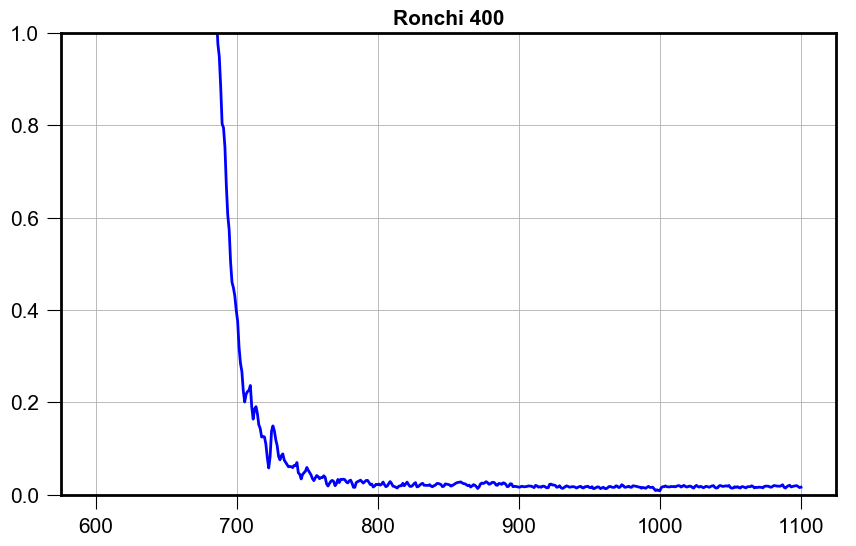

In [57]:
plt.plot(wl_ron400,r_ronn400,"b-")
plt.ylim(0.,1)
plt.title("Ronchi 400")

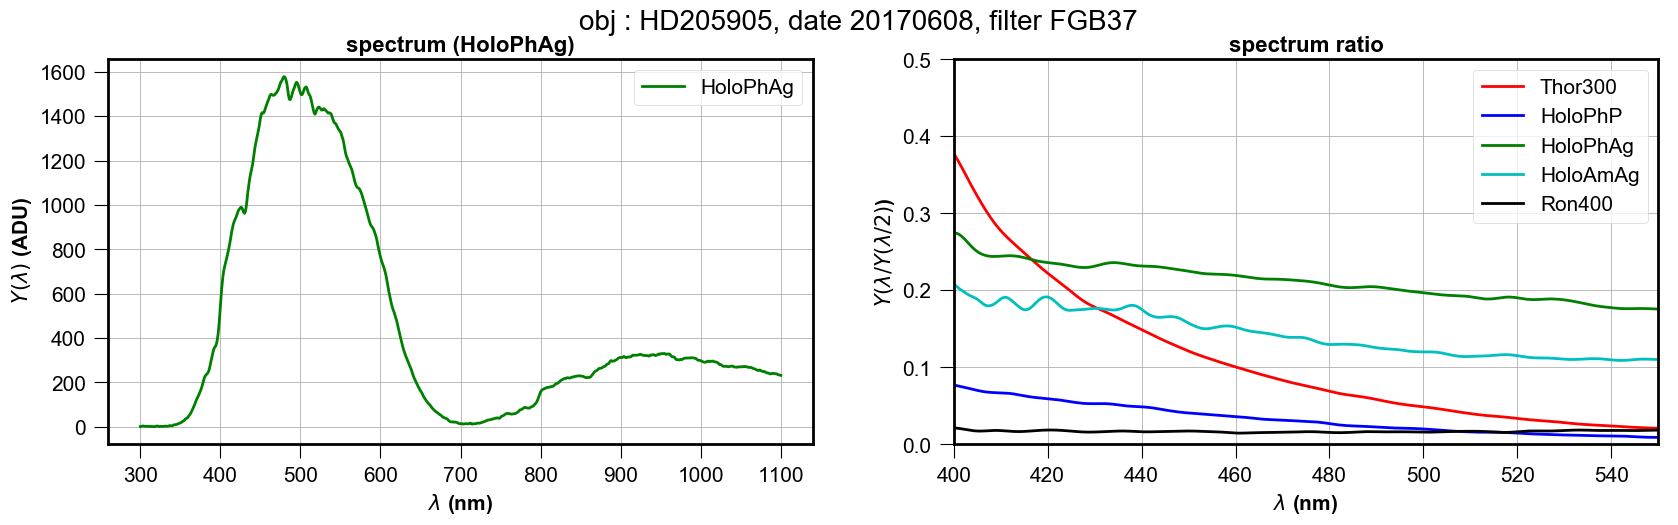

In [58]:
FullPagePlotContaminationinPDF2withRonchi400(lambdas,all_spc,all_interpolate,Selected_Dispersers,dir_top_images,"combinaison_contamin3.pdf",wl_ron400,r_ronn400)

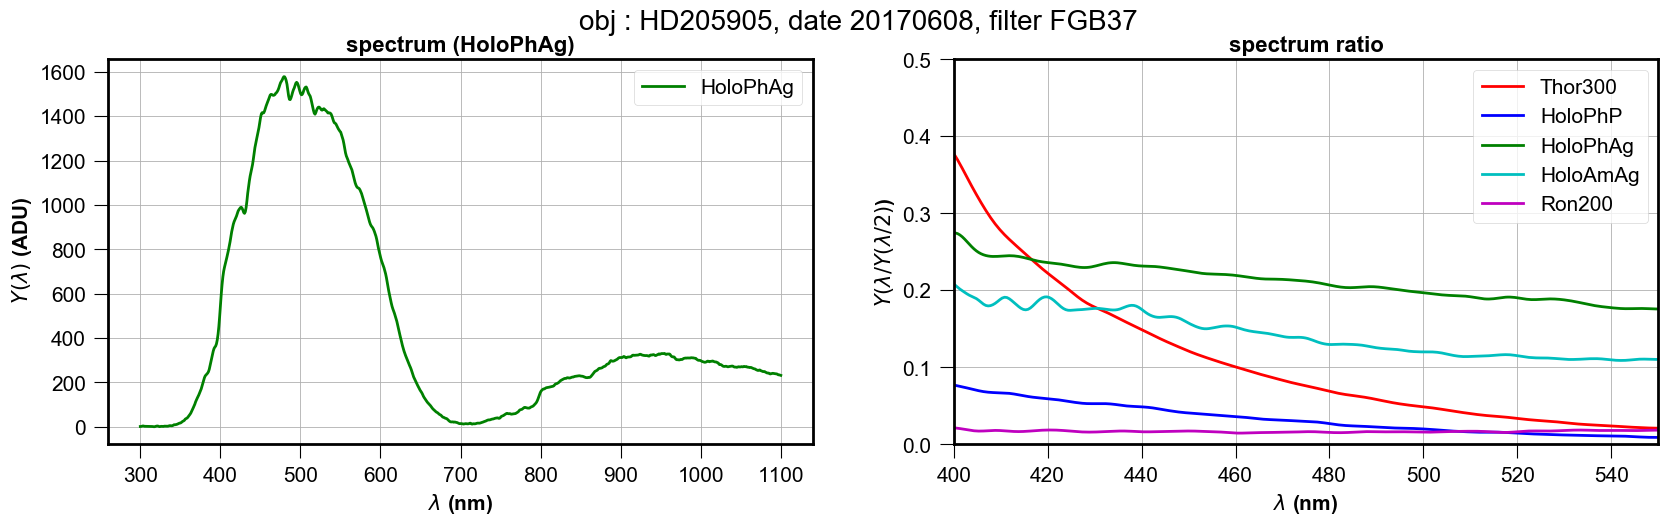

In [59]:
FullPagePlotContaminationinPDF2(lambdas,all_spc,all_interpolate,Selected_Dispersers,dir_top_images,"combinaison_contamin2.pdf")

In [60]:
#FullPagePlotContaminationinPDF3withRonchi400(lambdas,all_spc,all_interpolate,Selected_Dispersers,dir_top_images,"combinaison_contamin3.pdf",wl_ron400,r_ronn400)

# Figures for articles

In [61]:
filterfilename="FGB37_plotdigitizer.txt"

In [62]:
arr=np.loadtxt(filterfilename) 

In [63]:
def smooth2(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

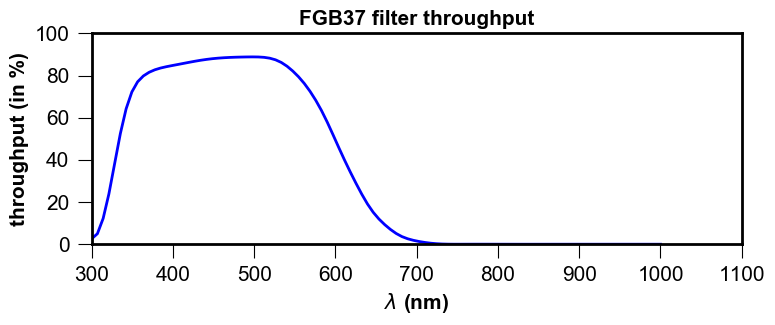

In [64]:
filterfilename="FGB37_plotdigitizer.txt"
arr=np.loadtxt(filterfilename)
f, axarr  = plt.subplots(1, 1,figsize=(8,3.5))
Xint=arr[:,0]
Yint=arr[:,1]

Xint = np.insert(Xint,0, 300.)
Yint = np.insert(Yint,0, 0.)

Xint = np.append(Xint,1100.)
Yint = np.append(Yint,0.)


func_bluefilt = interpolate.interp1d(Xint,Yint,kind="cubic")

FWL=np.array(func_bluefilt(WL))[:]

#axarr.plot(WL,FWL,"b-",label="filter FGB37")

# smooth the throuthput
smF=smooth2(FWL,window_len=9)[4:-4]
axarr.plot(WL,smF,"b-",label="filter FGB37")

axarr.set_xlim(300,1100)
axarr.set_ylim(0,100)
axarr.grid(False)
axarr.set_xlabel("$\lambda$ (nm)",fontweight='bold')
axarr.set_ylabel("throughput (in %)",fontweight='bold')
axarr.set_title("FGB37 filter throughput",fontweight='bold')
plt.tight_layout()
plt.savefig("FGB37_v2.pdf")

In [65]:
len(WL)

100

In [66]:
smooth?

In [67]:
smFWL=smooth2(FWL,window_len=3)

In [68]:
len(smFWL)

102

## Article figure version 0

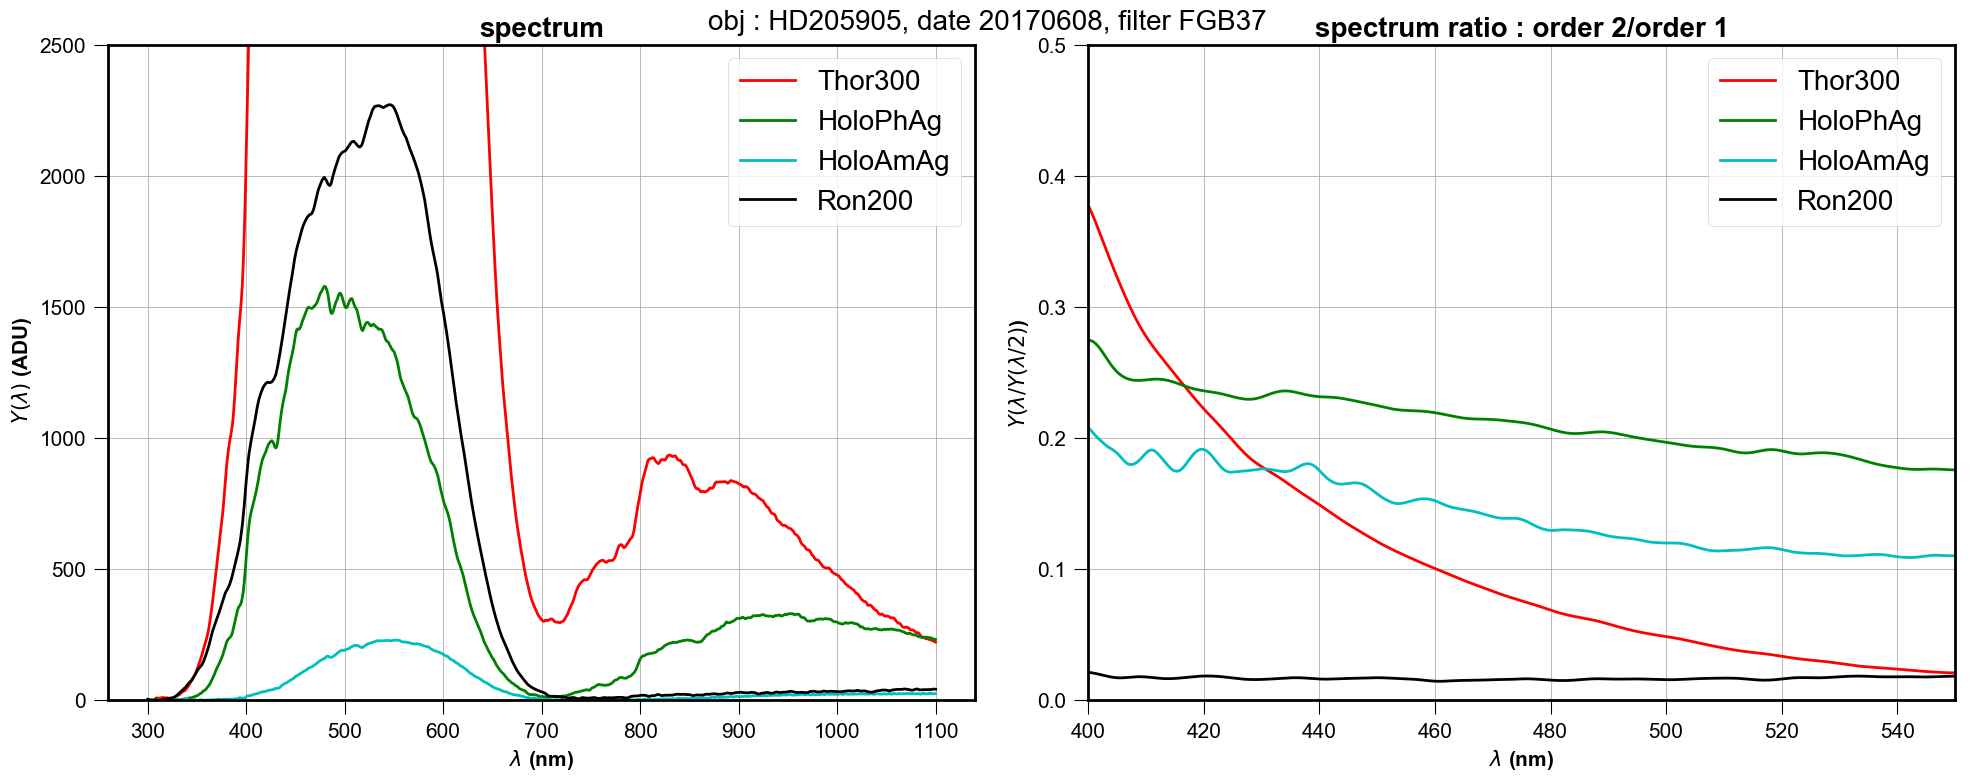

In [69]:
FullPagePlotContaminationinPDF2withRonchi400_NoPhP(lambdas,all_spc,all_interpolate,Selected_Dispersers,dir_top_images,"combinaison_contamin4.pdf",wl_ron400,r_ronn400)

## Article figure version 1

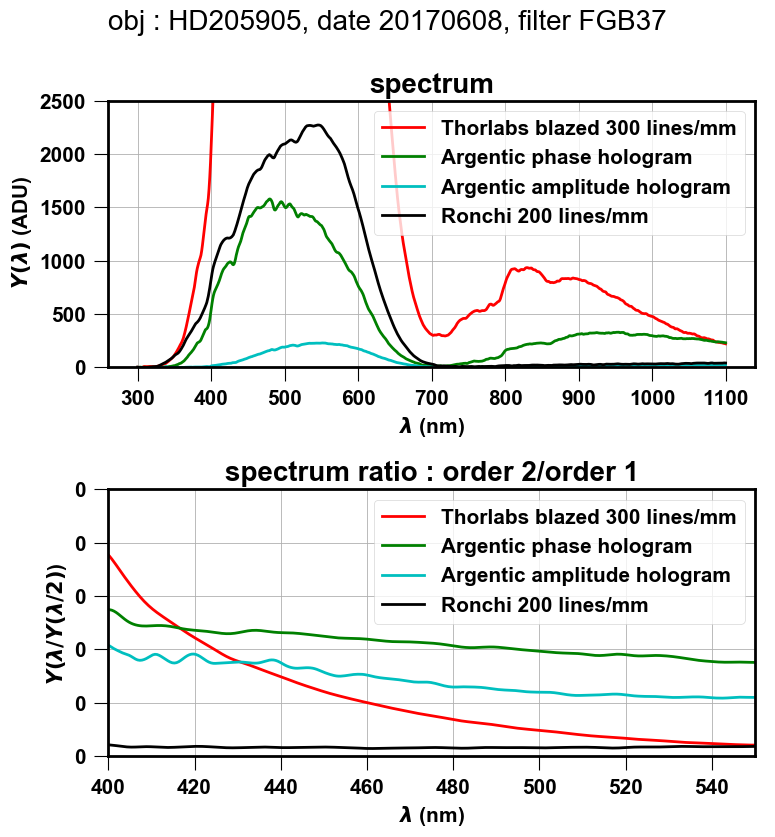

In [70]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
#plt.rcParams["axes.legendsize"] = 10
FullPagePlotContaminationinPDF2withRonchi400_NoPhP3(lambdas,all_spc,all_interpolate,Selected_Dispersers,dir_top_images,"combinaison_contaminFinal.pdf",wl_ron400,r_ronn400)

## Article figure version 2 : multiply by a factor 2

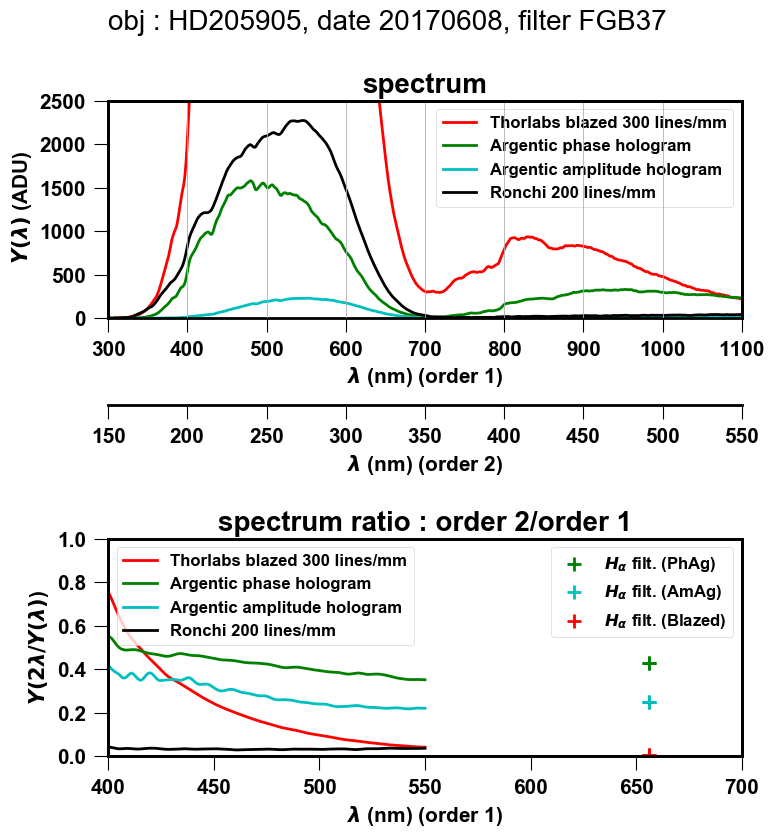

In [71]:
#plt.rcParams["font.weight"] = "bold"
#plt.rcParams["axes.labelweight"] = "bold"
#plt.rcParams["axes.legendsize"] = 10
FullPagePlotContaminationinPDF2withRonchi400_NoPhP4(lambdas,all_spc,all_interpolate,Selected_Dispersers,dir_top_images,"combinaison_contaminFinal.pdf",wl_ron400,r_ronn400)

## Article figure : version 3

(0, ', disperser = ', 'Thorlabs blazed 300 lines/mm', ' dx/dlambda (pix/nm)= ', 0.7338746646740847, ' wavelength = ', 300.0)
(1, ', disperser = ', 'HoloPhP', ' dx/dlambda (pix/nm)= ', 0.7338746646740847, ' wavelength = ', 300.0)
(2, ', disperser = ', 'Argentic phase hologram', ' dx/dlambda (pix/nm)= ', 0.859964171795537, ' wavelength = ', 300.0)
(3, ', disperser = ', 'Argentic amplitude hologram', ' dx/dlambda (pix/nm)= ', 0.859964171795537, ' wavelength = ', 300.0)
(4, ', disperser = ', 'Ronchi 200 lines/mm', ' dx/dlambda (pix/nm)= ', 0.4859519760344783, ' wavelength = ', 300.0)


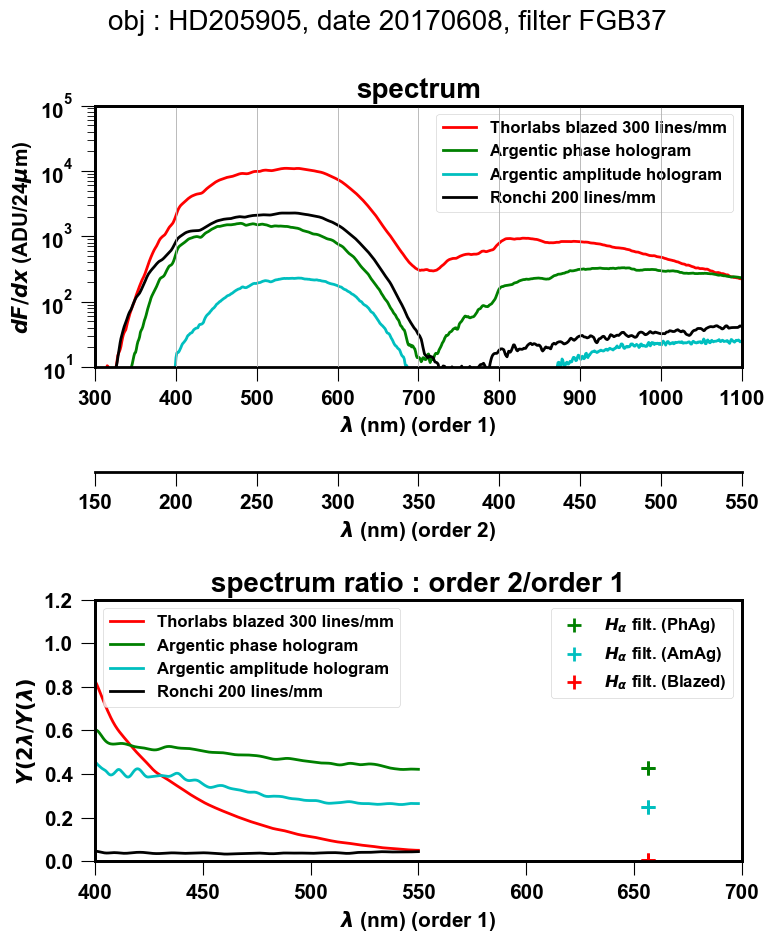

In [72]:
#plt.rcParams["font.weight"] = "bold"
#plt.rcParams["axes.labelweight"] = "bold"
#plt.rcParams["axes.legendsize"] = 10
FullPagePlotContaminationinPDF2withRonchi400_NoPhP5(lambdas,all_spc,all_interpolate,Selected_Dispersers,dir_top_images,"combinaison_contaminFinal.pdf",wl_ron400,r_ronn400)

## Article figure : version 4

(0, ', disperser = ', 'Thorlabs blazed 300 lines/mm', ' dx/dlambda (pix/nm)= ', 0.7338746646740847, ' wavelength = ', 300.0)
(1, ', disperser = ', 'HoloPhP', ' dx/dlambda (pix/nm)= ', 0.7338746646740847, ' wavelength = ', 300.0)
(2, ', disperser = ', 'Argentic phase hologram', ' dx/dlambda (pix/nm)= ', 0.859964171795537, ' wavelength = ', 300.0)
(3, ', disperser = ', 'Argentic amplitude hologram', ' dx/dlambda (pix/nm)= ', 0.859964171795537, ' wavelength = ', 300.0)
(4, ', disperser = ', 'Ronchi 200 lines/mm', ' dx/dlambda (pix/nm)= ', 0.4859519760344783, ' wavelength = ', 300.0)


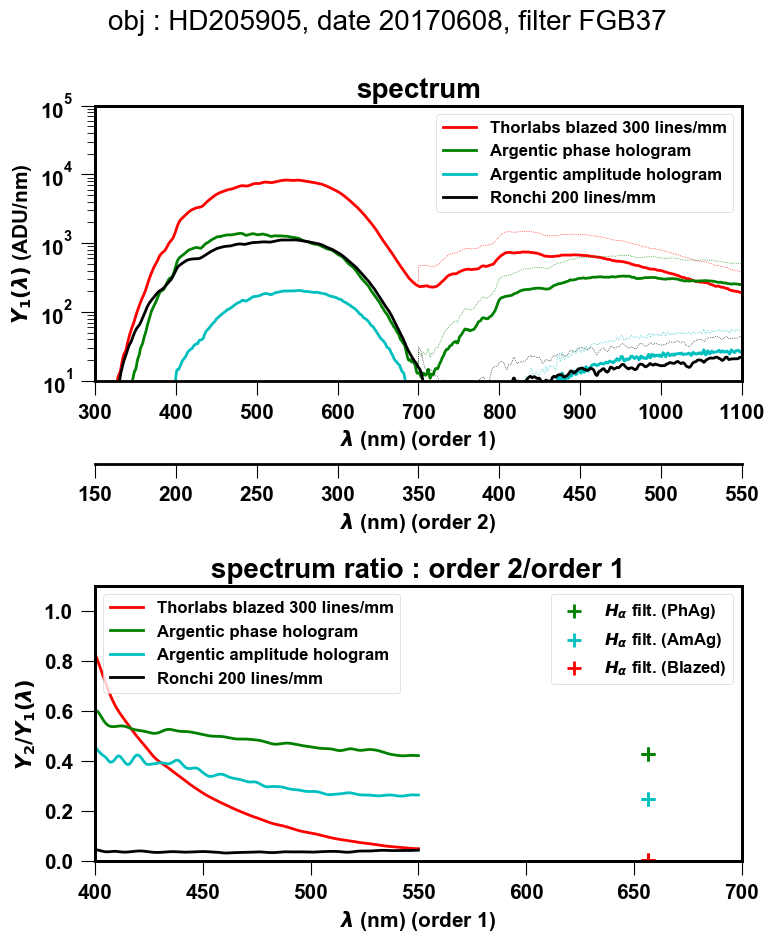

In [73]:
#plt.rcParams["font.weight"] = "bold"
#plt.rcParams["axes.labelweight"] = "bold"
#plt.rcParams["axes.legendsize"] = 10
FullPagePlotContaminationinPDF2withRonchi400_NoPhP6(lambdas,all_spc,all_interpolate,Selected_Dispersers,dir_top_images,"combinaison_contaminFinal.pdf",wl_ron400,r_ronn400)

(0, ', disperser = ', 'Thorlabs blazed 300 lines/mm', ' dx/dlambda (pix/nm)= ', 0.7338746646740847, ' wavelength = ', 300.0)
(1, ', disperser = ', 'HoloPhP', ' dx/dlambda (pix/nm)= ', 0.7338746646740847, ' wavelength = ', 300.0)
(2, ', disperser = ', 'Argentic phase hologram', ' dx/dlambda (pix/nm)= ', 0.859964171795537, ' wavelength = ', 300.0)
(3, ', disperser = ', 'Argentic amplitude hologram', ' dx/dlambda (pix/nm)= ', 0.859964171795537, ' wavelength = ', 300.0)
(4, ', disperser = ', 'Ronchi 200 lines/mm', ' dx/dlambda (pix/nm)= ', 0.4859519760344783, ' wavelength = ', 300.0)


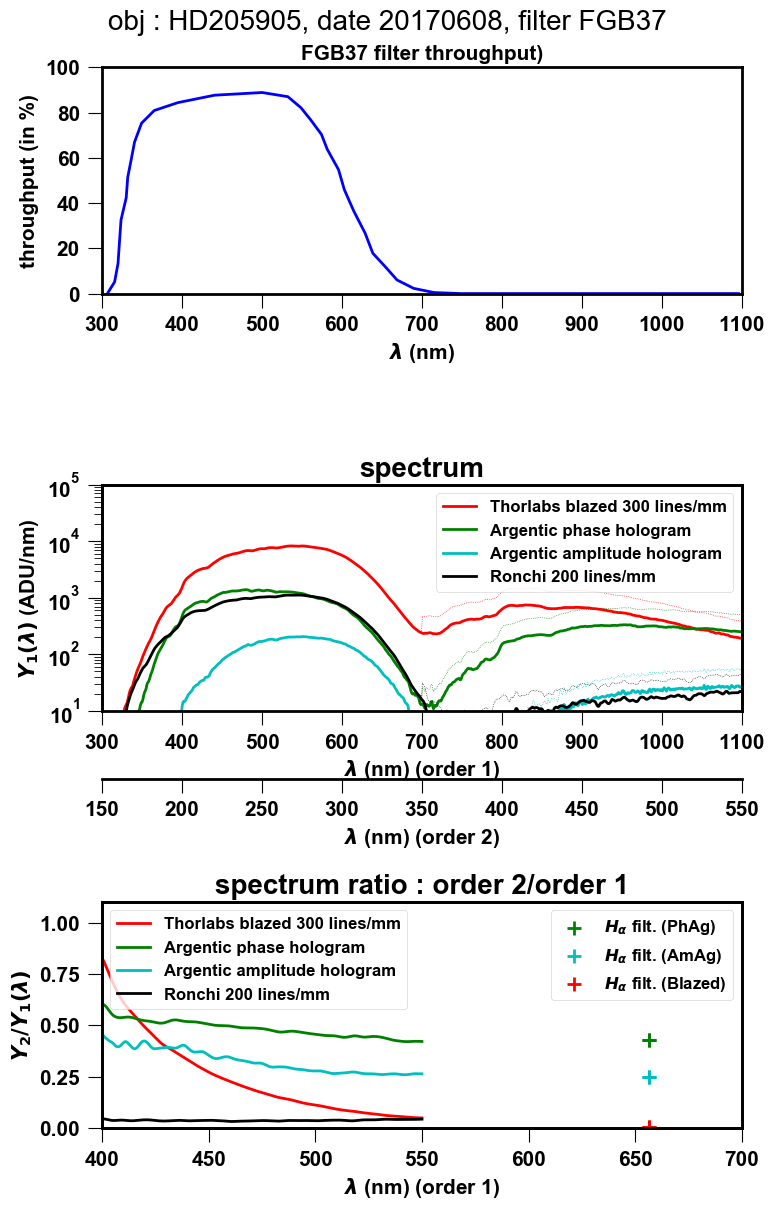

In [74]:
#plt.rcParams["font.weight"] = "bold"
#plt.rcParams["axes.labelweight"] = "bold"
#plt.rcParams["axes.legendsize"] = 10
FullPagePlotContaminationinPDF2withRonchi400_NoPhP7(lambdas,all_spc,all_interpolate,Selected_Dispersers,dir_top_images,"combinaison_contaminFinal_v2.pdf",wl_ron400,r_ronn400)

## Very old plots

(0, ',', 'Thor300')
(1, ',', 'HoloPhP')
(2, ',', 'HoloPhAg')
(3, ',', 'HoloAmAg')
(4, ',', 'Ron200')


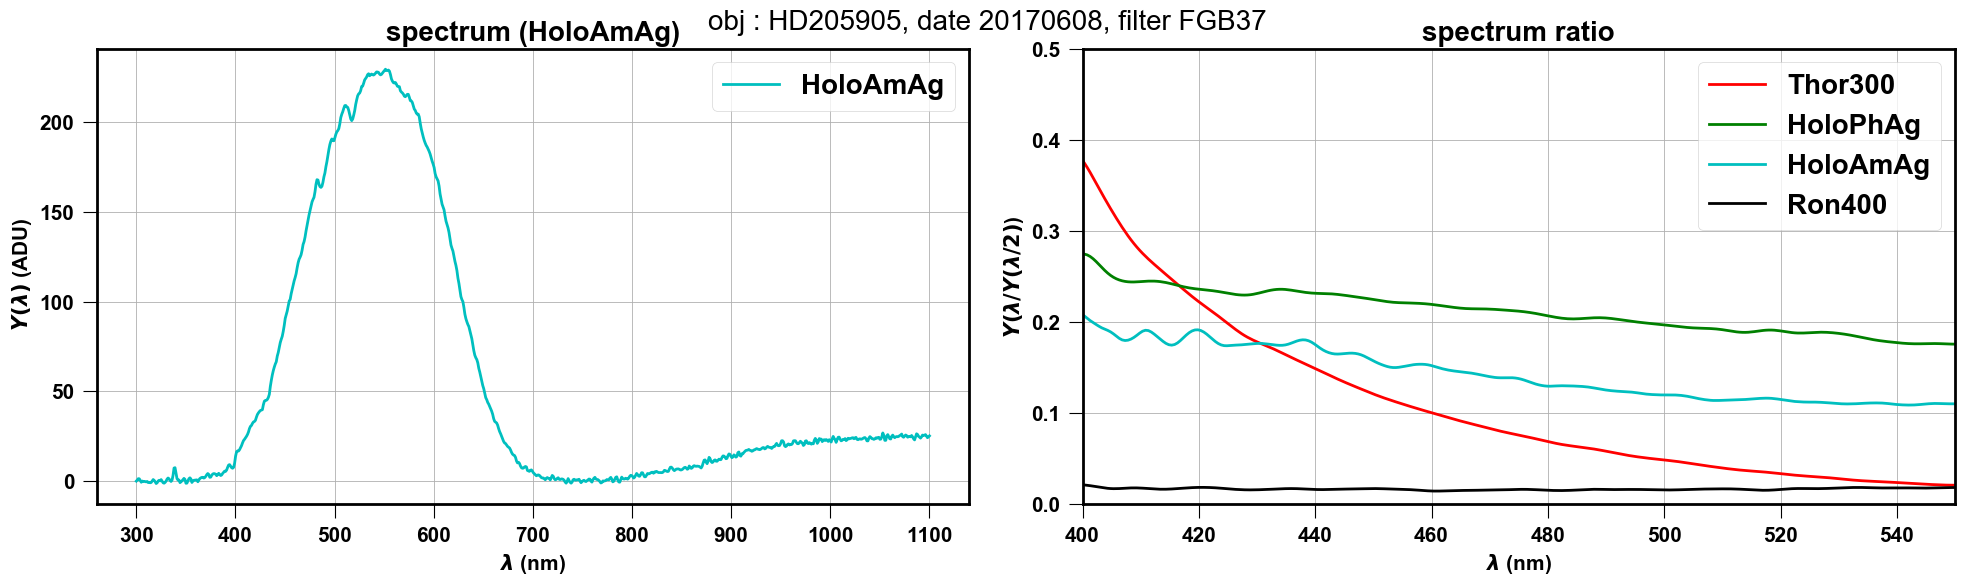

In [75]:
FullPagePlotContaminationinPDF2withRonchi400_NoPhP_2(lambdas,all_spc,all_interpolate,Selected_Dispersers,dir_top_images,"combinaison_contamin5.pdf",wl_ron400,r_ronn400)

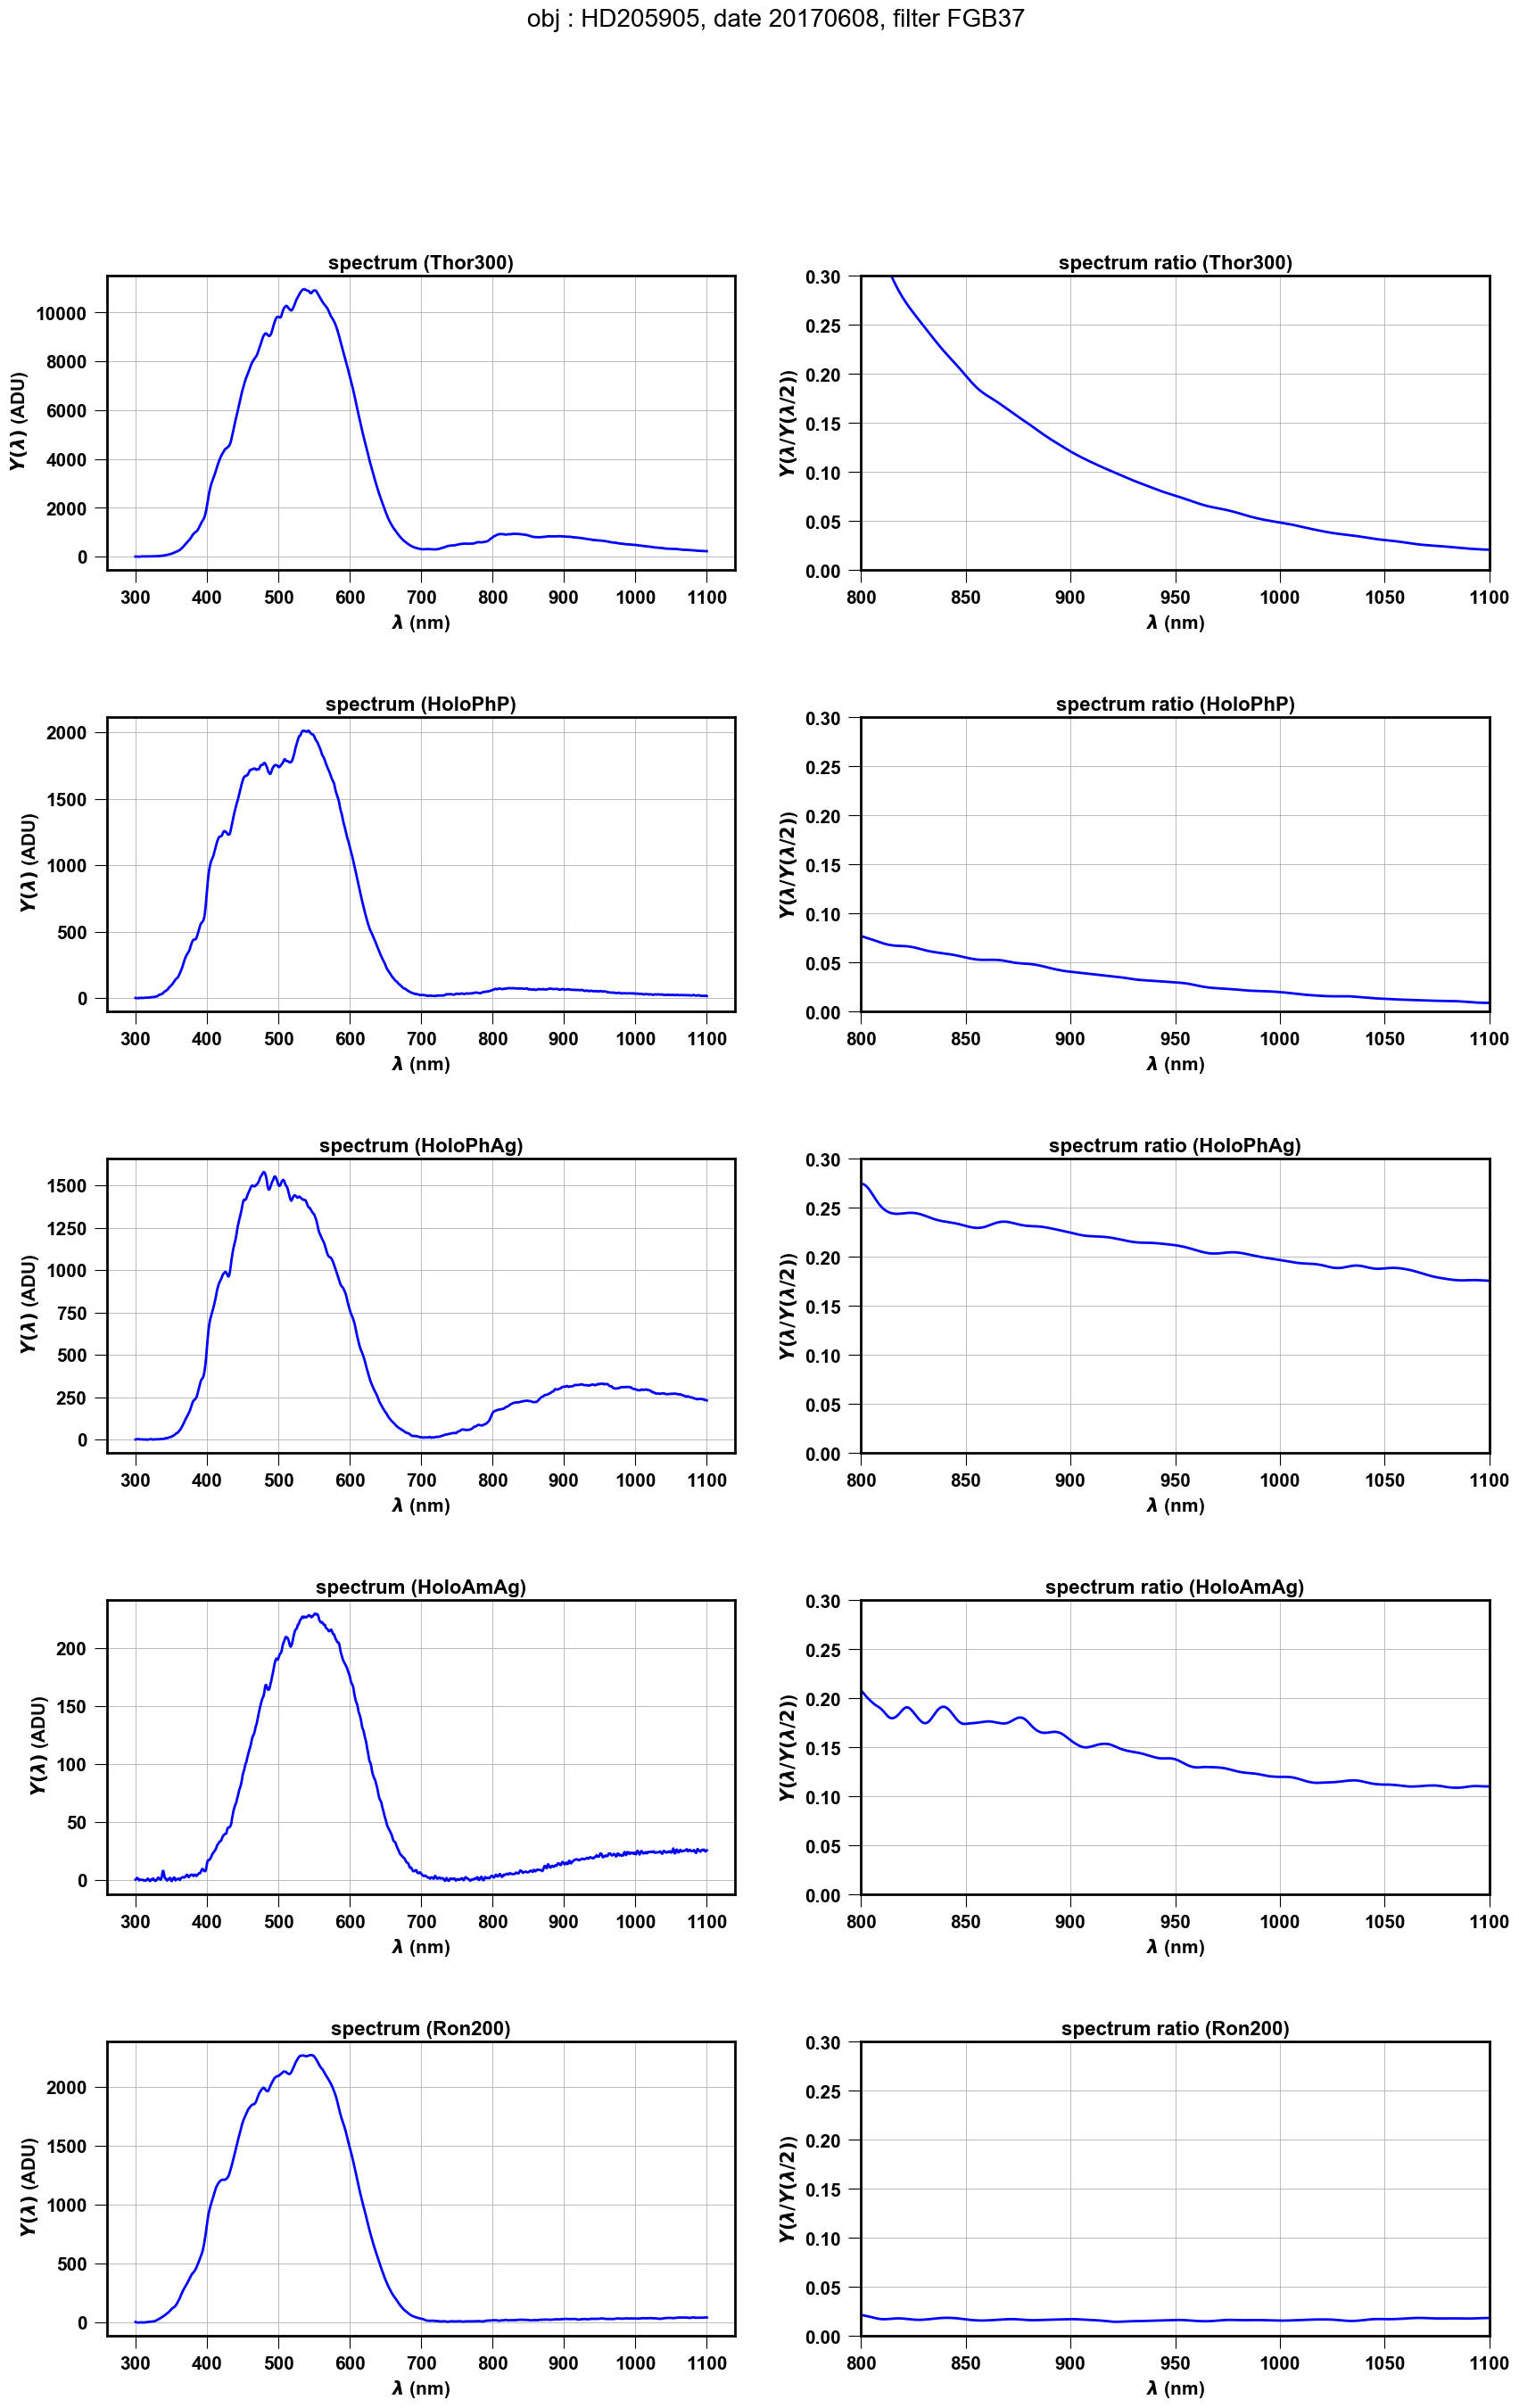

In [76]:
FullPagePlotContaminationinPDF(lambdas,all_spc,all_interpolate,Selected_Dispersers,dir_top_images,"combinaison_contamin.pdf")

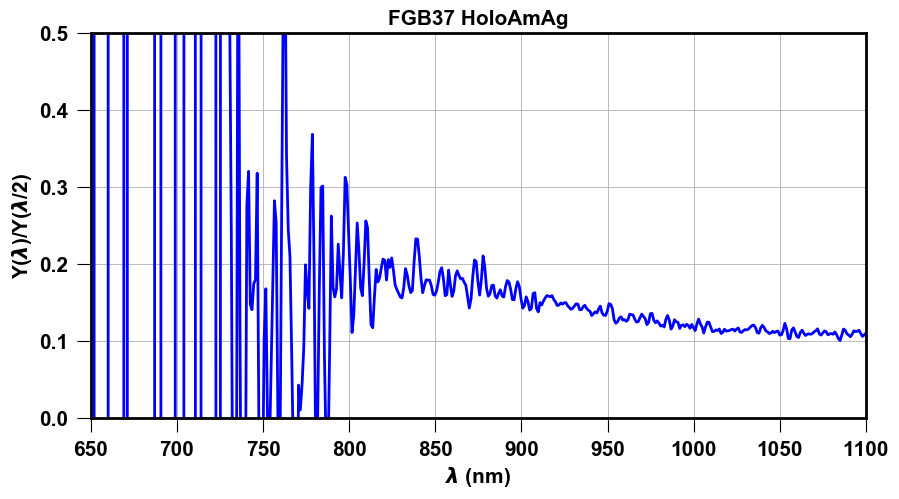

In [77]:
PlotContamination(lambdas,all_spc[sel],all_interpolate[sel],Select_Filt[sel]) 

# Loop

/Users/dagoret/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


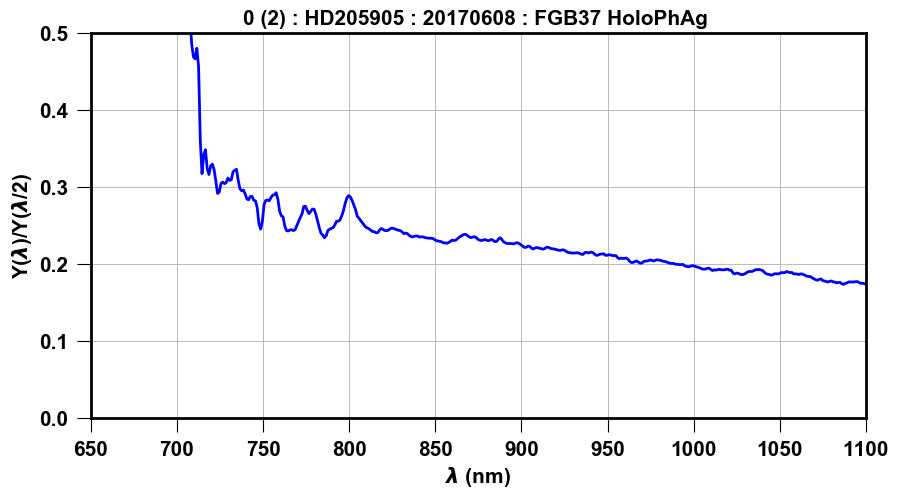

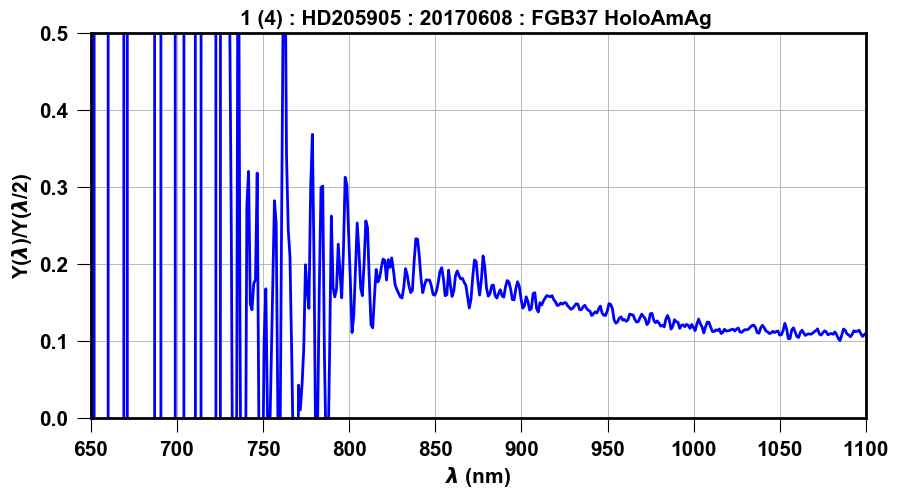

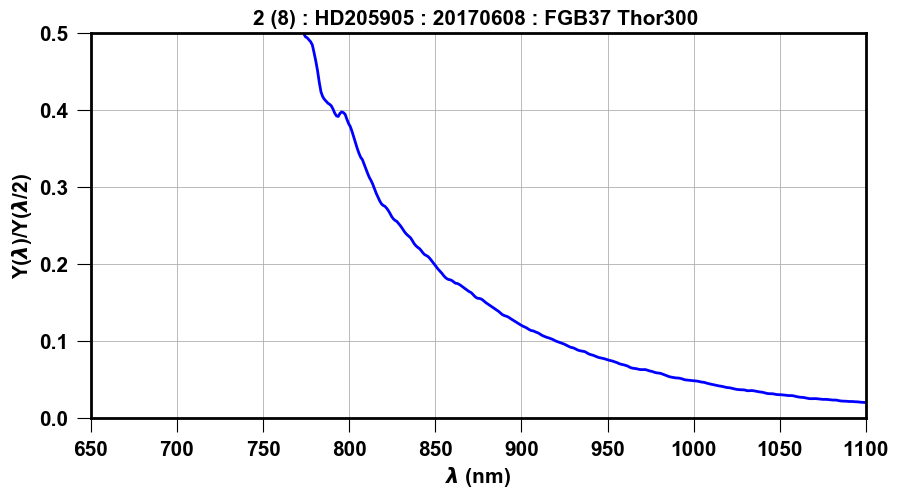

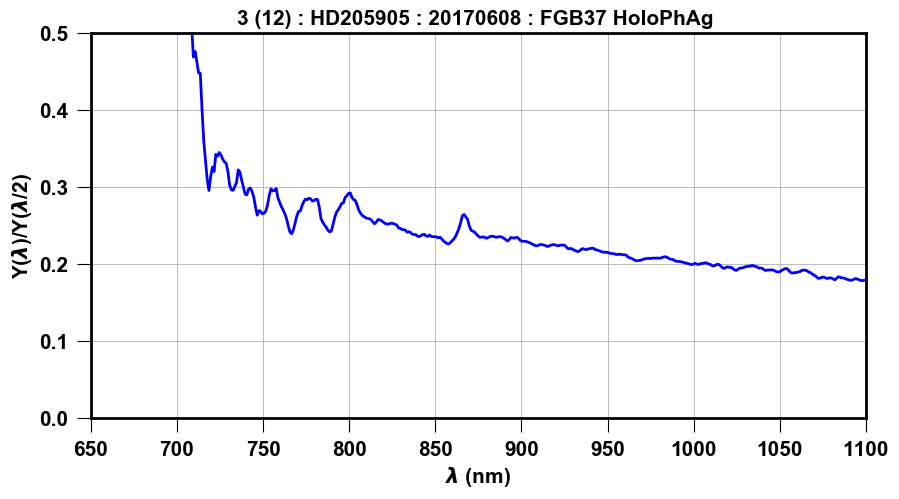

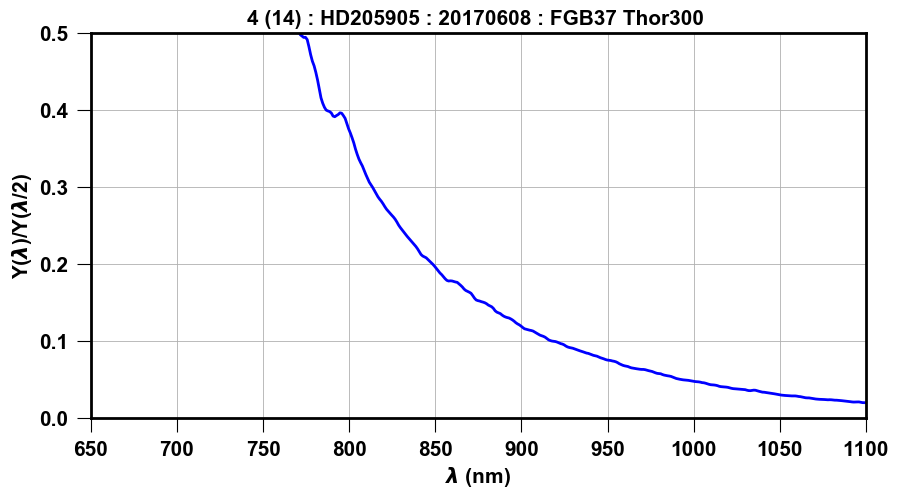

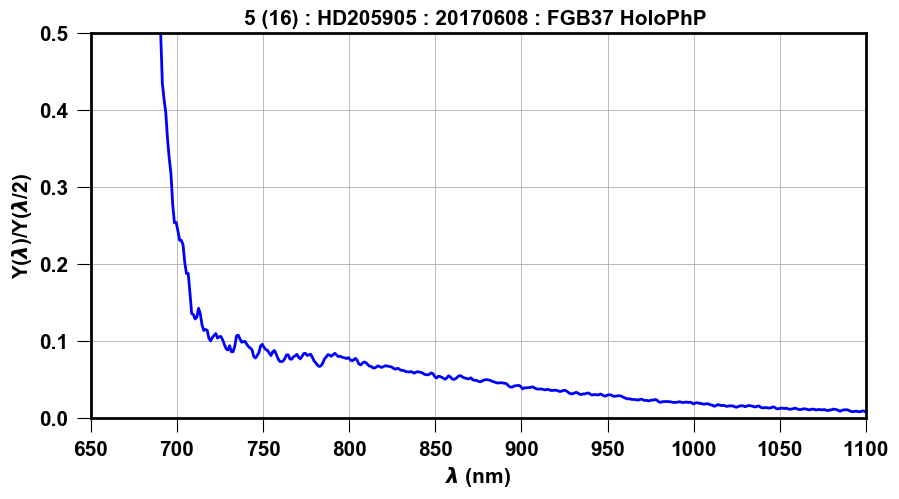

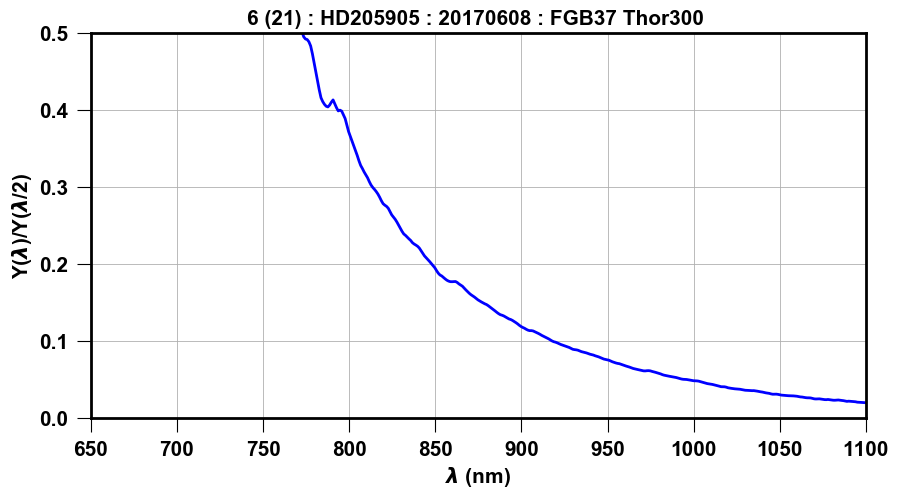

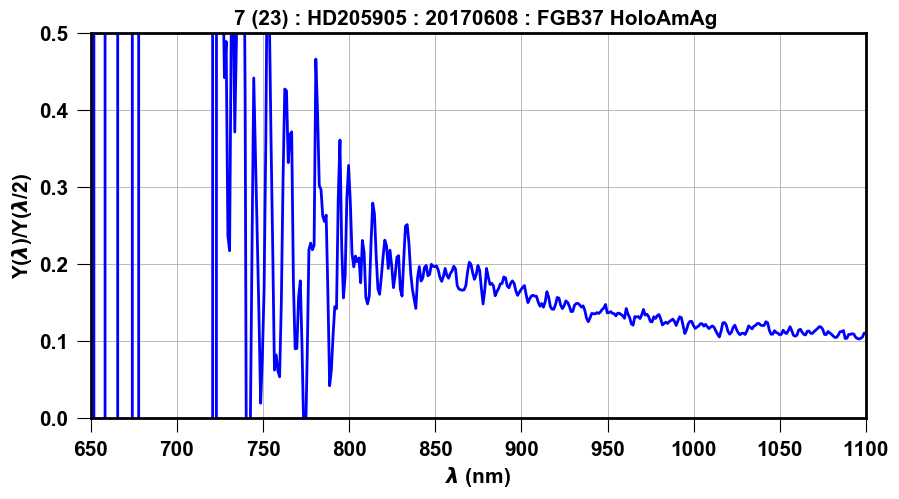

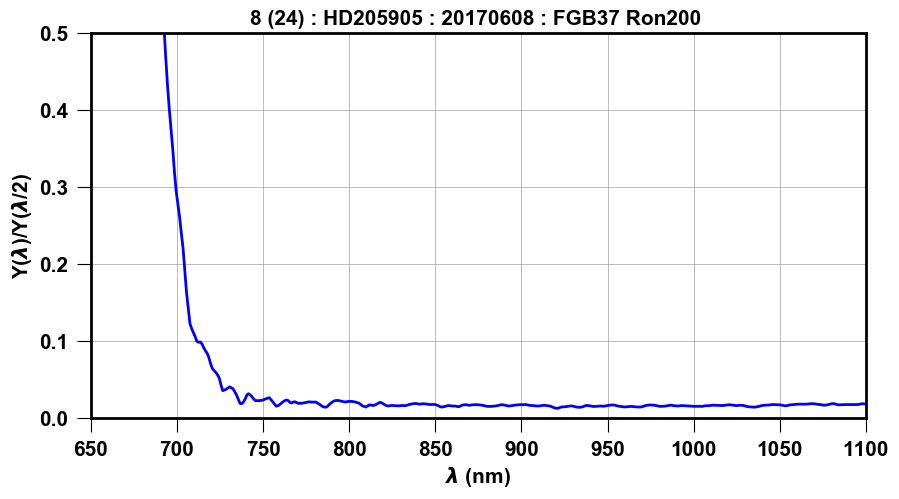

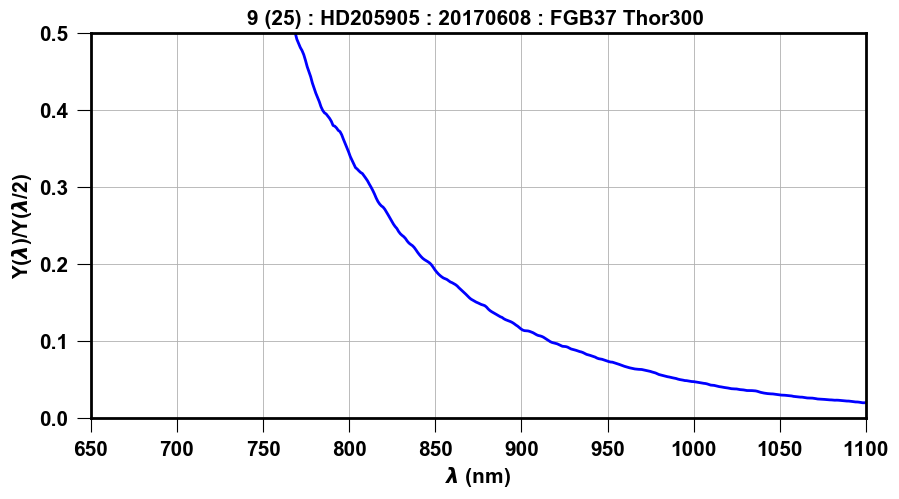

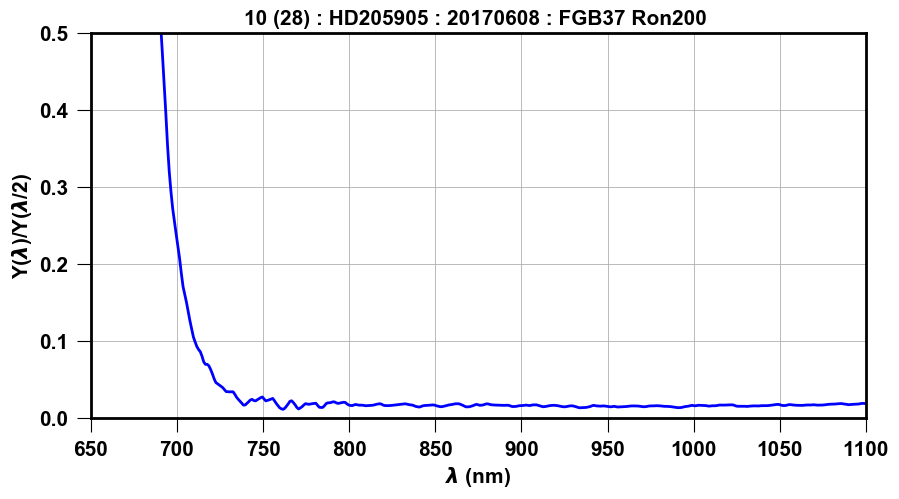

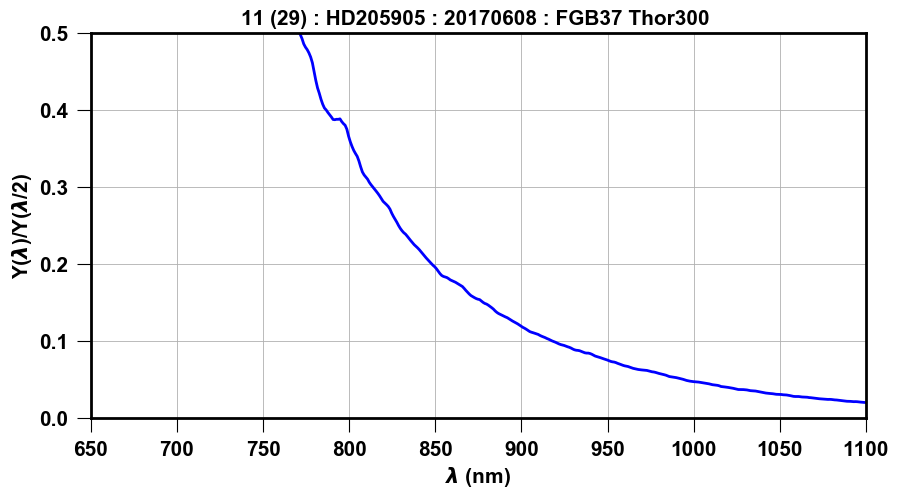

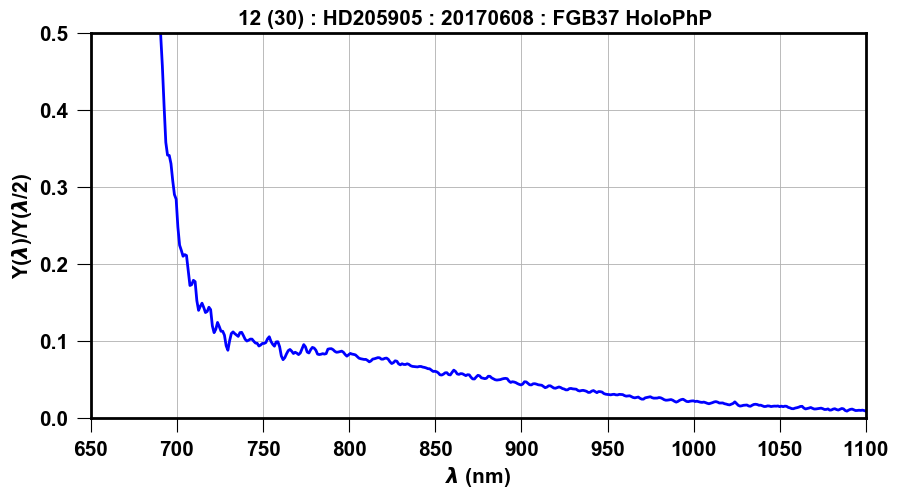

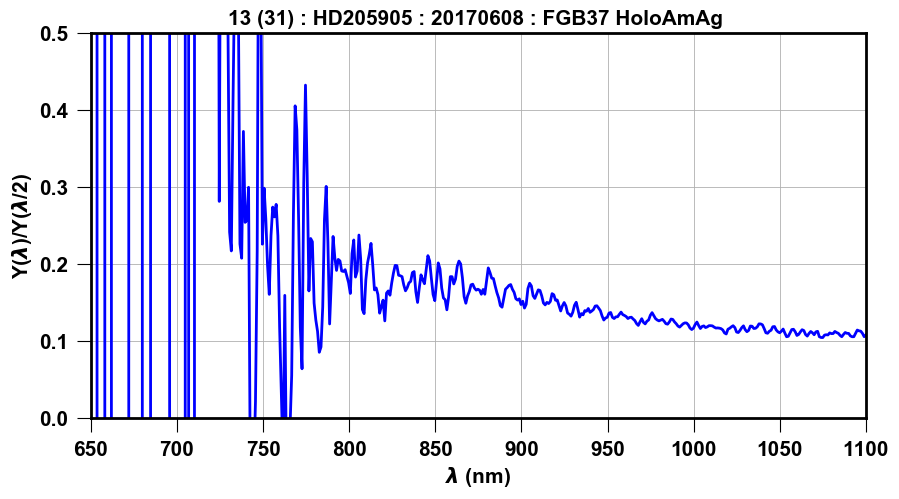

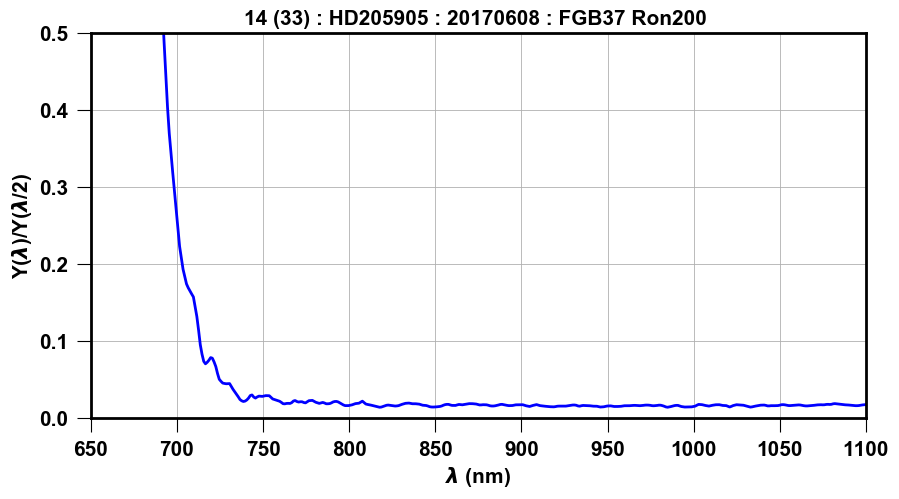

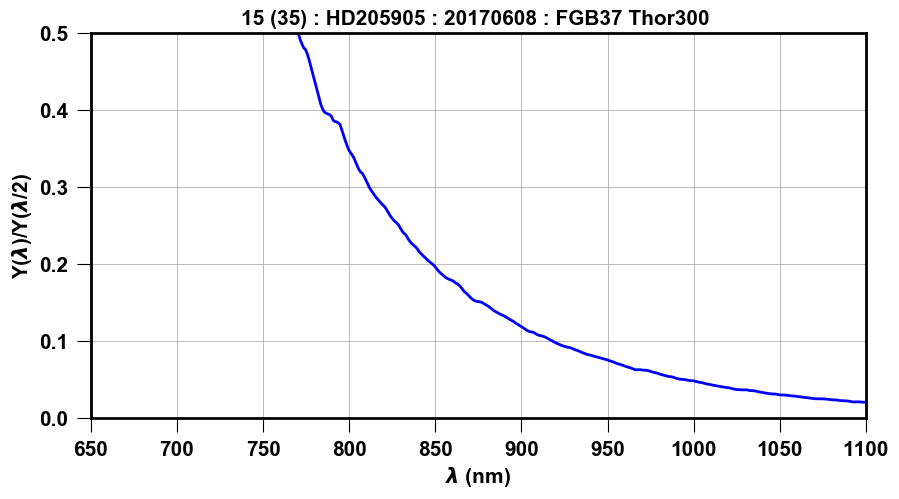

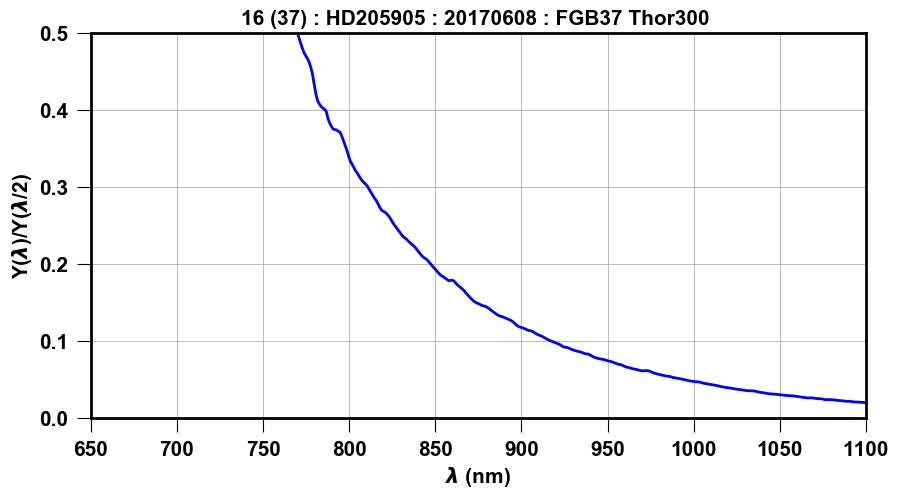

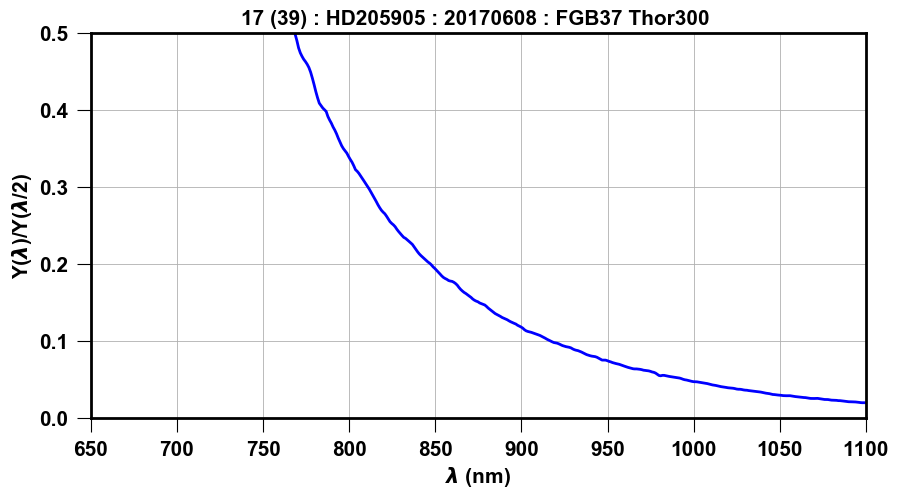

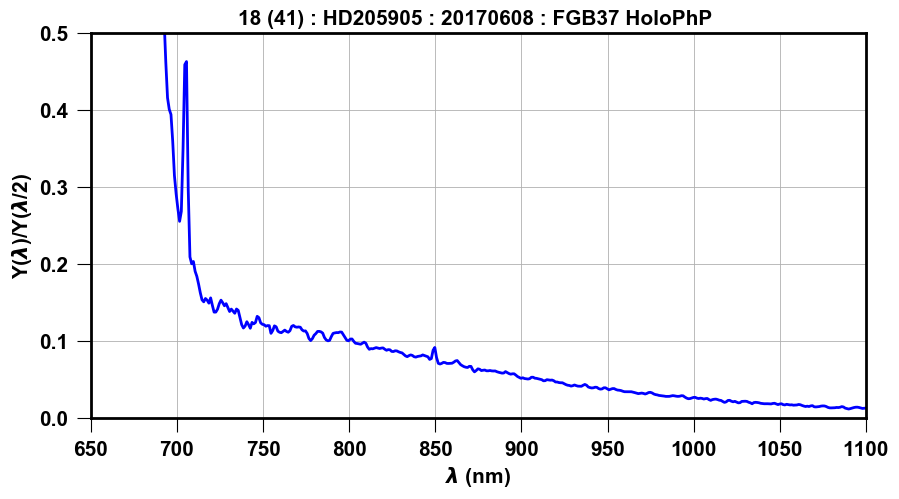

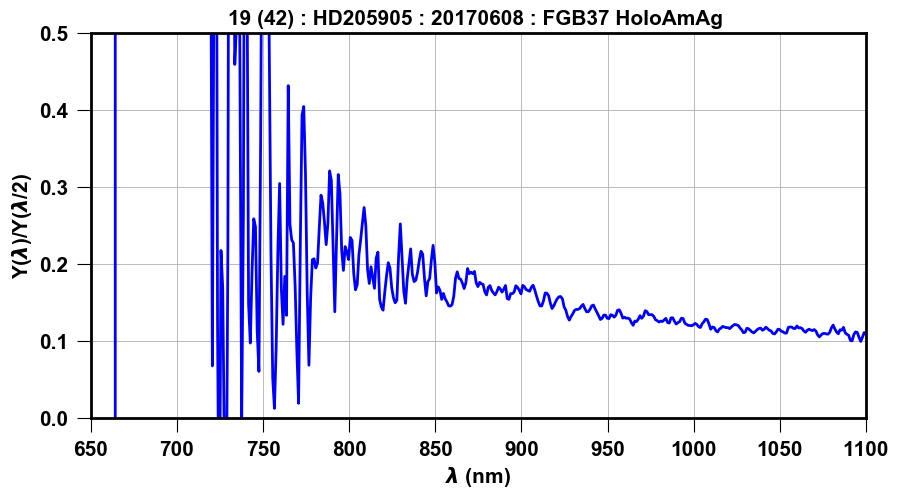

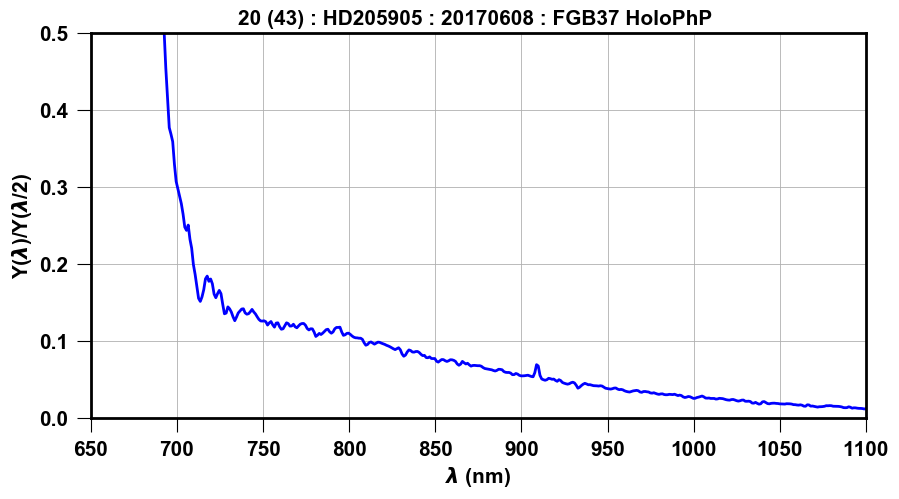

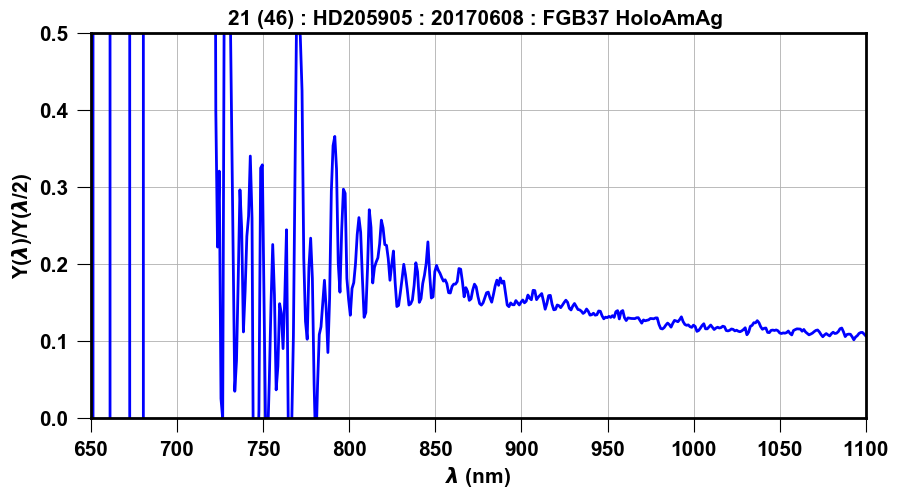

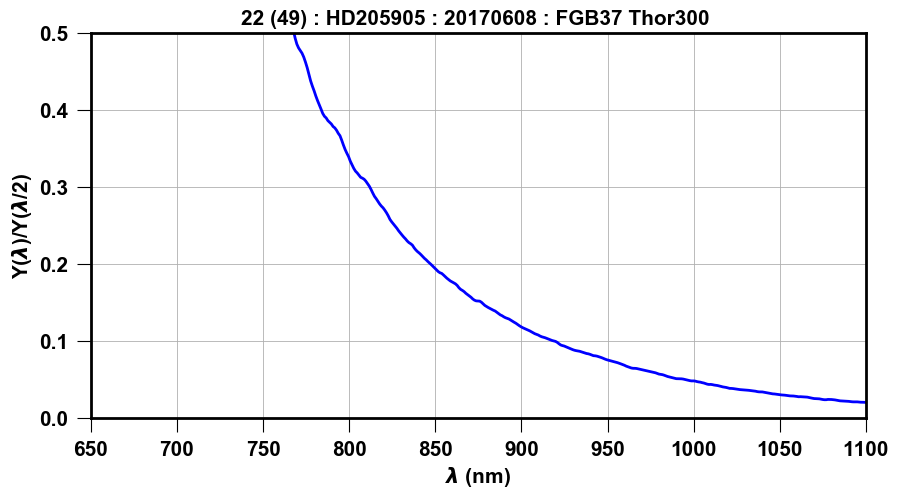

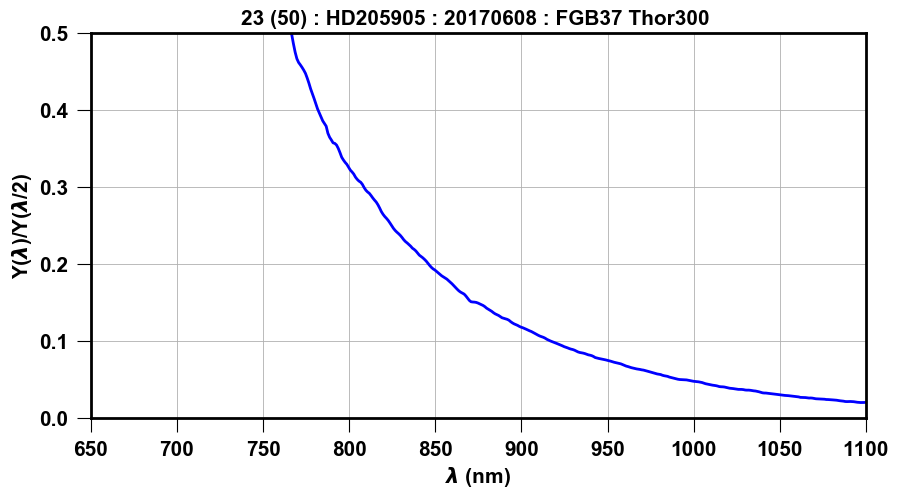

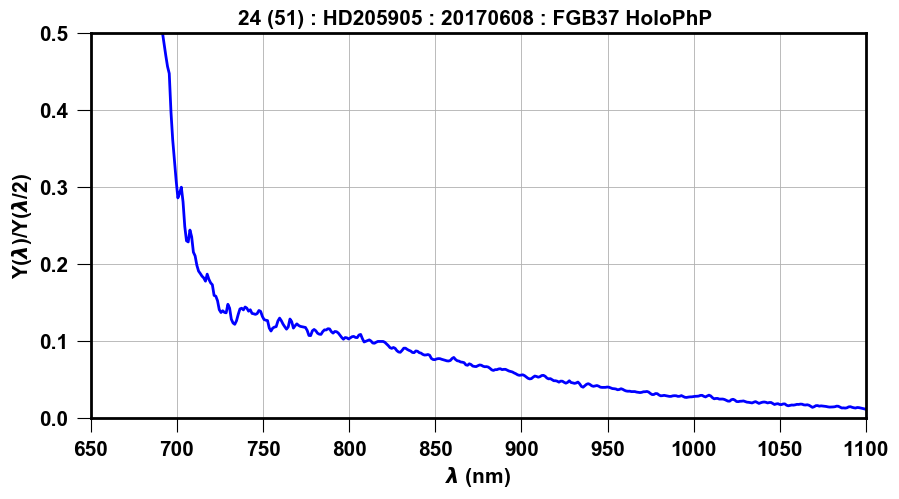

In [78]:
for sel in np.arange(len(Selected_Indexes)):
    title="{} ({}) : {} : {} : {} ".format(sel,Selected_Indexes[sel],object_name,date,Select_Filt[sel])
    PlotContamination(lambdas,all_spc[sel],all_interpolate[sel],title) 

# Produce plots in pdf 

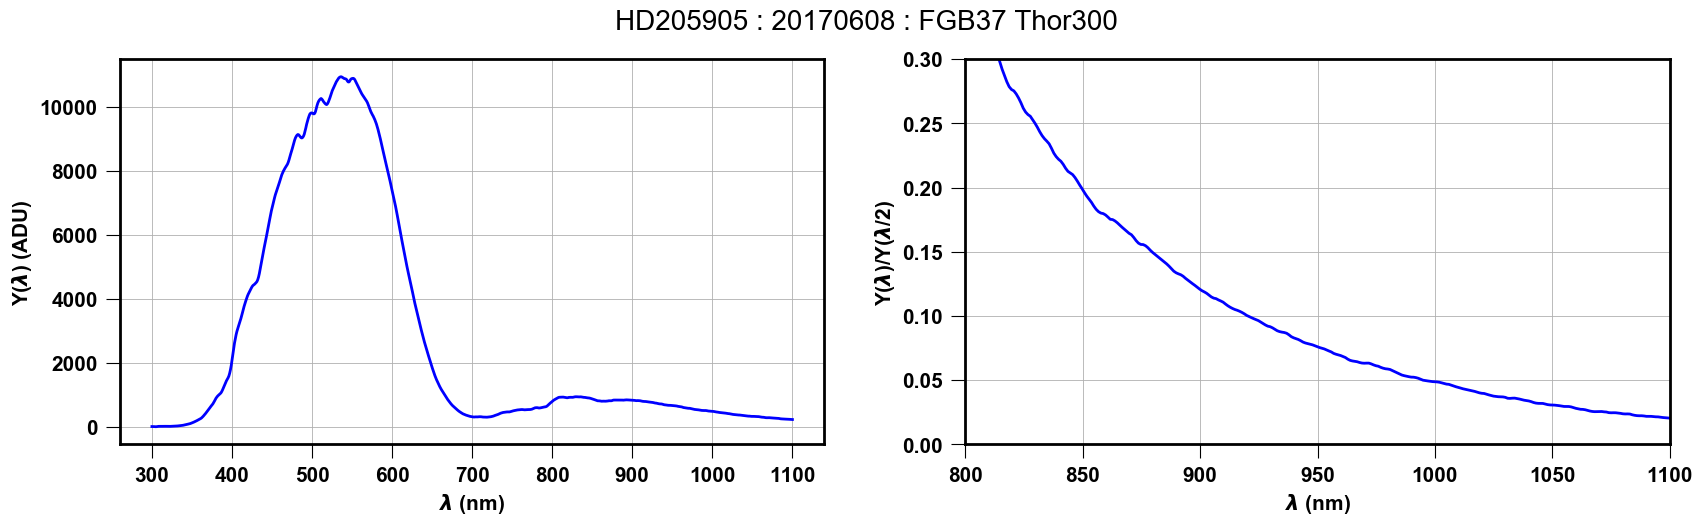

In [79]:
sel=2
title="{} : {} : {} ".format(object_name,date,Select_Filt[sel])
figname='contamination_{}_{}.pdf'.format(Selected_Dispersers[sel],sel)
PlotContaminationinPDF(lambdas,all_spc[sel],all_interpolate[sel],title,dir_top_images,figname)

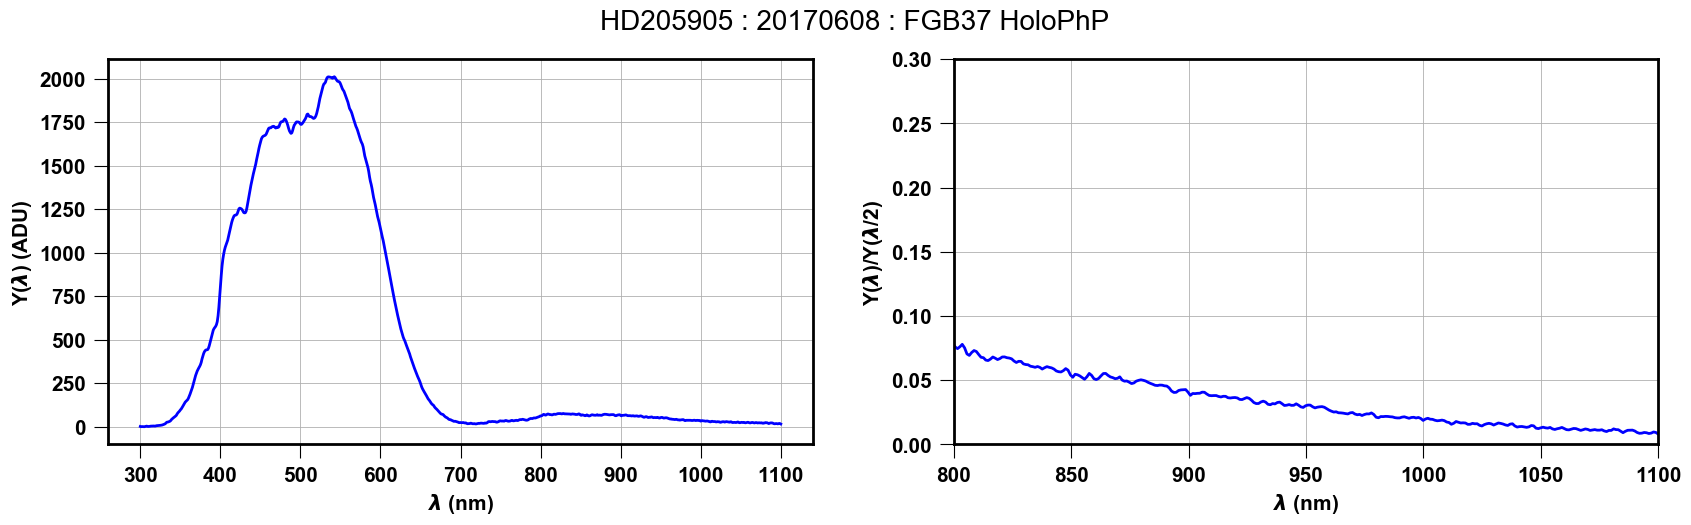

In [80]:
sel=5
title="{} : {} : {} ".format(object_name,date,Select_Filt[sel])
figname='contamination_{}_{}.pdf'.format(Selected_Dispersers[sel],sel)
PlotContaminationinPDF(lambdas,all_spc[sel],all_interpolate[sel],title,dir_top_images,figname)

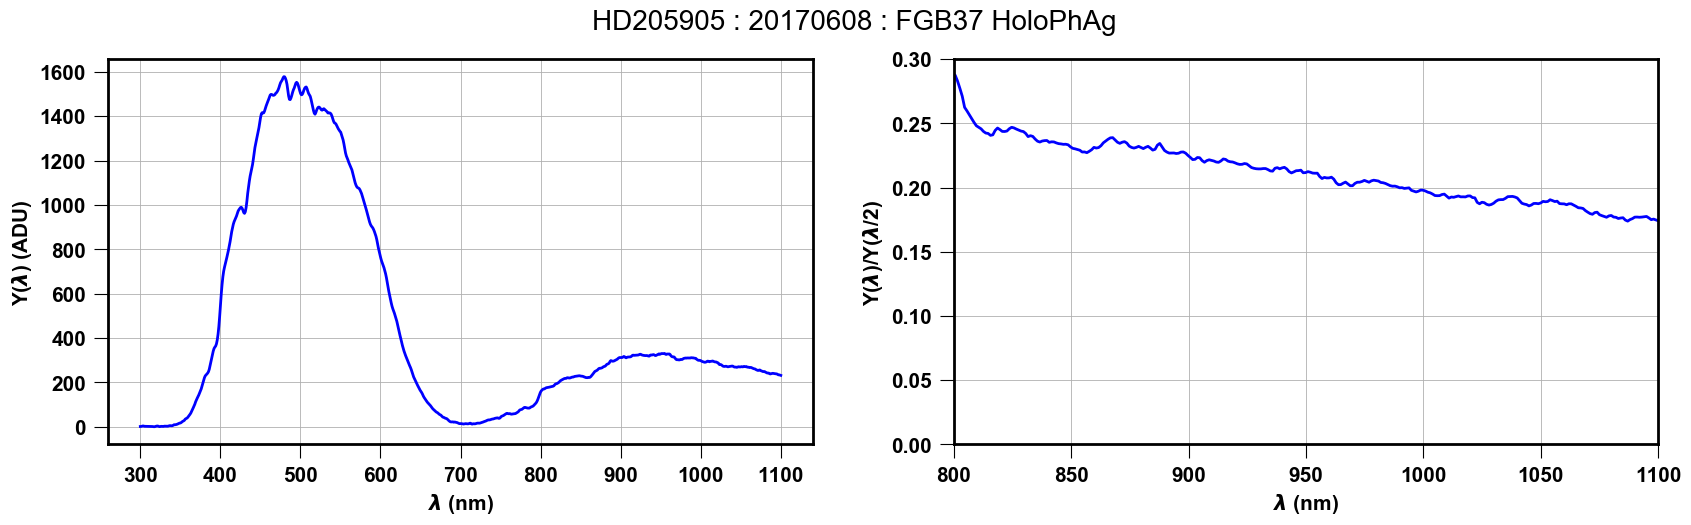

In [81]:
sel=0
title="{} : {} : {} ".format(object_name,date,Select_Filt[sel])
figname='contamination_{}_{}.pdf'.format(Selected_Dispersers[sel],sel)
PlotContaminationinPDF(lambdas,all_spc[sel],all_interpolate[sel],title,dir_top_images,figname)

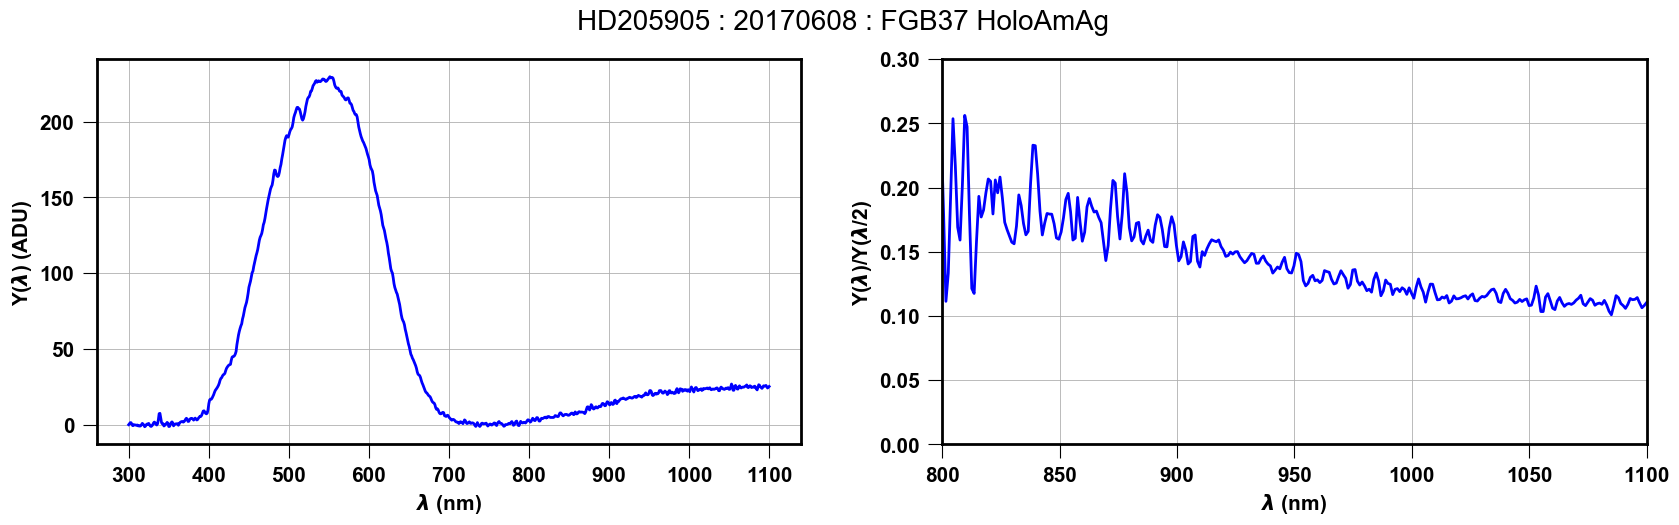

In [82]:
sel=1
title="{} : {} : {} ".format(object_name,date,Select_Filt[sel])
figname='contamination_{}_{}.pdf'.format(Selected_Dispersers[sel],sel)
PlotContaminationinPDF(lambdas,all_spc[sel],all_interpolate[sel],title,dir_top_images,figname)

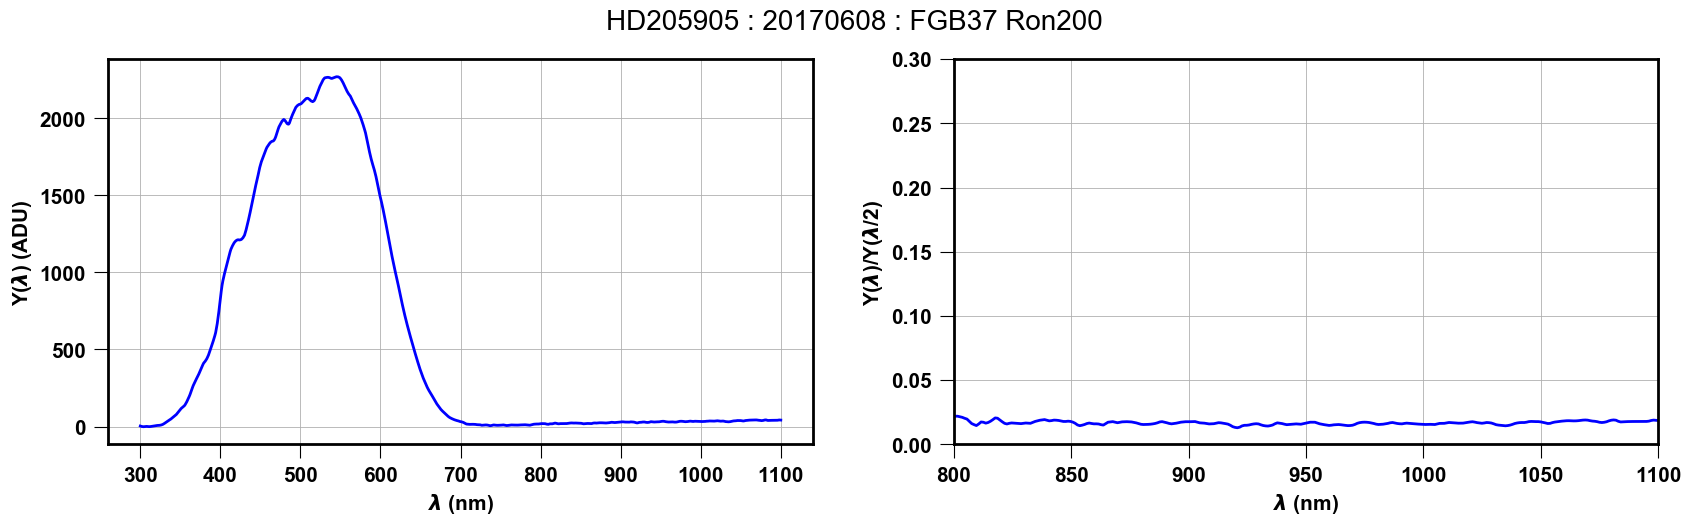

In [83]:
sel=8
title="{} : {} : {} ".format(object_name,date,Select_Filt[sel])
figname='contamination_{}_{}.pdf'.format(Selected_Dispersers[sel],sel)
PlotContaminationinPDF(lambdas,all_spc[sel],all_interpolate[sel],title,dir_top_images,figname)